# Проект 3. Прогнозирование рейтинга отеля на Booking.com (EDA+ML)

![booking.jpg](attachment:36bb94ca-21aa-4d26-846b-ffae311e222f.jpg "Booking.com")
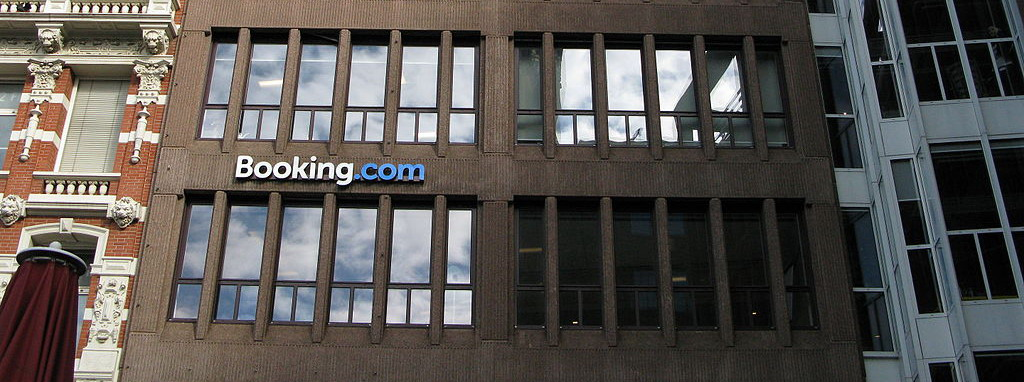

### *Содержание*
-  Загрузка и очистка данных
-  Анализ (EDA)
-  Конструирование новых признаков
-  Итерации обучение модели (RandomForestRegressor) с добавлением новых признаков для улучшения метрики.
- Вывод

### *Вводная*

*Нужно предсказать оценку, которую рецензент поставил отелю на основании отзыва рецензента и других признаков.*

**Описание полей датасета**

-   hotel_address — адрес отеля;
-   review_date — дата, когда рецензент разместил соответствующий отзыв;
-   average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
-   hotel_name — название отеля;
-   reviewer_nationality — страна рецензента;
-   negative_review — отрицательный отзыв, который рецензент дал отелю;
-   review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
-   positive_review — положительный отзыв, который рецензент дал отелю;
-   review_total_positive_word_counts — общее количество слов в положительном отзыве.
-   reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
-   total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
-   total_number_of_reviews — общее количество действительных отзывов об отеле;
-   tags — теги, которые рецензент дал отелю;
-   days_since_review — количество дней между датой проверки и датой очистки;
-   additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
-   lat — географическая широта отеля;
-   lng — географическая долгота отеля.



## Установка и импорт необходимых модулей

In [1]:
%pip install category_encoders nltk comet_ml sweetviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip freeze > requariments.txt

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
#plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6,4)

from IPython.display import display

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import category_encoders as ce

# тесты
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат

import comet_ml as comet
import sweetviz
# ===============================================
# os.environ['COMET_AUTO_LOG_DISABLE']='False'  
# ===============================================
# print(comet.__version__)
# print(sweetviz.__version__)
# Не инициализируем - не используем
COMET_LOG_ENABLE=False
# ===============================================
#WORKSPACE = 'dhegl'
WORKSPACE='dheglsfds'
PROJECT = 'sfds-project-3'
# Для автоотчетов
comet.init(workspace=WORKSPACE, project_name=PROJECT)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_SEED = 42

COMET INFO: Comet API key is valid


In [4]:
## а у нас BLAS, а у вас?
#np.show_config()

# Блок EDA

## Загрузка и первичный обзор

In [5]:
file_id = '11bOevjZ9P69ZJlB9uLPSOzkk-uge7y8W'

google_drive_url='https://drive.google.com/uc?export=download&confirm=no_antivirus&id='
remote_url  = google_drive_url + file_id
local_file  = '../input/sf-booking/hotels_train.zip'

if os.path.exists('../input/sf-booking/') and os.path.exists(local_file):
    print('Load local:', local_file)
    url = local_file
else:
    print('Load remote:', remote_url)
    url = remote_url

Load remote: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=11bOevjZ9P69ZJlB9uLPSOzkk-uge7y8W


In [6]:
hotels_df = pd.read_csv(url, compression='zip')
hotels_df.head(2)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

In [7]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
hotels_df.duplicated().sum()

307

In [9]:
# в "боевом" варианте этого делать не будем
hotels_df.drop_duplicates(inplace=True)

In [10]:
hotels_df.describe(include='object')

hotel_address review_date  \
count                                              386496      386496   
unique                                               1493         731   
top     163 Marsh Wall Docklands Tower Hamlets London ...    8/2/2017   
freq                                                 3587        1910   

                                        hotel_name reviewer_nationality  \
count                                       386496               386496   
unique                                        1492                  225   
top     Britannia International Hotel Canary Wharf      United Kingdom    
freq                                          3587               183952   

       negative_review positive_review  \
count           386496          386496   
unique          248828          311737   
top        No Negative     No Positive   
freq             95833           26863   

                                                     tags days_since_review  
count                                              386496            386496  
unique                                              47135               731  
top     [' Leisure trip ', ' Couple ', ' Double Room '...            1 days  
freq                                                 3853              1910

In [11]:
hotels_df.describe().round(2)

additional_number_of_scoring  average_score  \
count                     386496.00      386496.00   
mean                         498.50           8.40   
std                          500.37           0.55   
min                            1.00           5.20   
25%                          169.00           8.10   
50%                          342.00           8.40   
75%                          660.00           8.80   
max                         2682.00           9.80   

       review_total_negative_word_counts  total_number_of_reviews  \
count                          386496.00                386496.00   
mean                               18.54                  2744.68   
std                                29.70                  2316.93   
min                                 0.00                    43.00   
25%                                 2.00                  1161.00   
50%                                 9.00                  2134.00   
75%                                23.00                  3633.00   
max                               408.00                 16670.00   

       review_total_positive_word_counts  \
count                          386496.00   
mean                               17.78   
std                                21.72   
min                                 0.00   
25%                                 5.00   
50%                                11.00   
75%                                22.00   
max                               395.00   

       total_number_of_reviews_reviewer_has_given  reviewer_score        lat  \
count                                   386496.00       386496.00  384048.00   
mean                                         7.18            8.40      49.44   
std                                         11.05            1.64       3.47   
min                                          1.00            2.50      41.33   
25%                                          1.00            7.50      48.21   
50%                                          3.00            8.80      51.50   
75%                                          8.00            9.60      51.52   
max                                        355.00           10.00      52.40   

             lng  
count  384048.00  
mean        2.82  
std         4.58  
min        -0.37  
25%        -0.14  
50%        -0.00  
75%         4.83  
max        16.43

In [12]:
#  Часть описательных признаков переведем в категориальные 
# для ускорения обработки и уменьшения занимаемой датасетом памяти
category_columns = ['hotel_address', 'hotel_name', 'reviewer_nationality']
hotels_df[category_columns] = hotels_df[category_columns].astype('category')

## Очистка данных

In [13]:
hotels_df.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

In [14]:
#  "Утереную" локацию отелей востановим по средней величине страны расположения. Все равно все вокруг столиц "крутится". 
# Точность тут не так важна, т.к. процент отелей без указаных координат крайне мал.
# Выделим страну из адреса отеля и заполним среднем по широте и дологоте
hotels_df['country'] = hotels_df['hotel_address'].str.extract(r'.+ (.+)$')\
    .astype('category').replace('Kingdom', 'United Kingdom')

In [15]:
lat_mean = hotels_df.groupby('country')['lat'].mean()
lat_mean

country
Austria           48.203367
France            48.863806
Italy             45.479617
Netherlands       52.362211
Spain             41.389125
United Kingdom    51.510737
Name: lat, dtype: float64

In [16]:
lng_mean = hotels_df.groupby('country')['lng'].mean()
lng_mean

country
Austria           16.367176
France             2.326842
Italy              9.191845
Netherlands        4.885346
Spain              2.169152
United Kingdom    -0.139075
Name: lng, dtype: float64

In [17]:
# Вариант 1 (наглядный)
def set_lat(x:pd.Series):
    return lat_mean[x['country']]
#--------------------------------
hotels_df.loc[hotels_df['lat'].isna(),'lat'] = hotels_df[hotels_df['lat'].isna()].apply(set_lat, axis=1)
#hotels_df['lat'].isna().sum()

In [18]:
# Вариант 2 (лямбда)
hotels_df.loc[hotels_df['lng'].isna(),'lng'] = \
    hotels_df[hotels_df['lng'].isna()].apply(lambda x: lng_mean[x['country']], axis=1)
#hotels_df['lng'].isna().sum()

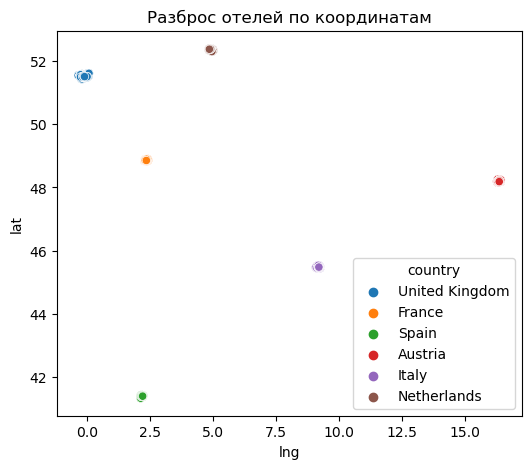

In [19]:
#plt.scatter(hotels_df['lat'], hotels_df['lng']);
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(hotels_df.sample(30000), x='lng', y='lat', hue='country')
# и без geopandas понятно, что где то в европах.
plt.title('Разброс отелей по координатам');
# ну или координаты разброса. кому как нравится

## Разведовательный анализ и создание новых признаков

### *Оценка рецензента, поставленая отелю в ревью* (reviewer_score)

Целевой показатель, который необходимо смоделировать

In [20]:
print('Rev`s score min:', hotels_df.reviewer_score.min())
print('Rev`s score max:', hotels_df.reviewer_score.max())
print('Rev`s score mean:', hotels_df.reviewer_score.mean().round(1))
print('Rev`s score median:', hotels_df.reviewer_score.median())

Rev`s score min: 2.5
Rev`s score max: 10.0
Rev`s score mean: 8.4
Rev`s score median: 8.8


### *Cредняя оценка рейтинга отеля* (average_score)

Один из важных базовых признаков.

In [21]:
print('Hotel avg score min:', hotels_df.average_score.min())
print('Hotel avg score max', hotels_df.average_score.max())
print('Hotel score mean:', hotels_df.average_score.mean().round(1))
print('Hotel score median:', hotels_df.average_score.median())

Hotel avg score min: 5.2
Hotel avg score max 9.8
Hotel score mean: 8.4
Hotel score median: 8.4


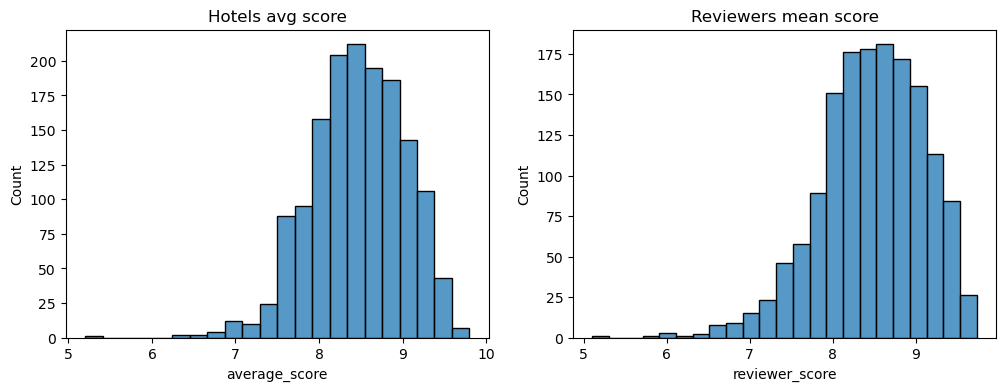

In [22]:
# Распределение средних оценок -средней за последний год и за весь период выборки
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4) )
sns.histplot(hotels_df.groupby('hotel_name')['average_score'].mean(), ax=ax[0], bins=22);
ax[0].set_title('Hotels avg score');
sns.histplot(hotels_df.groupby('hotel_name')['reviewer_score'].mean(), ax=ax[1], bins=23);
ax[1].set_title('Reviewers mean score');

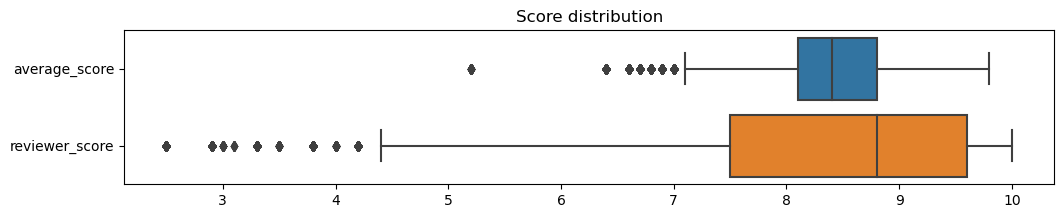

In [23]:
fig,ax = plt.subplots(figsize=(12,2))
sns.boxplot(hotels_df[['average_score','reviewer_score']], orient='h');
plt.title("Score distribution");

Сравнивать эти два показателя не совсем корректно, т.к. average_score это уже усредненная оценка. Поэтому получим усредненую оценку от рецензентов по отелям за весь период выборки.

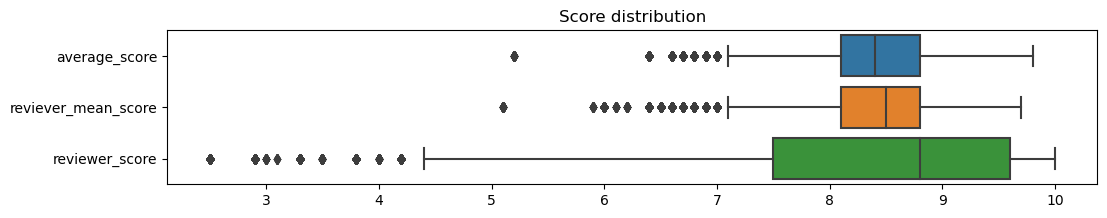

In [24]:
by_mean_score = hotels_df.groupby('hotel_name')['reviewer_score'].mean().round(1)
hotels_df['reviever_mean_score'] =  hotels_df.hotel_name.apply(lambda n: by_mean_score.loc[n])
fig,ax = plt.subplots(figsize=(12,2))
sns.boxplot(hotels_df[['average_score', 'reviever_mean_score', 'reviewer_score']], orient='h');
plt.title("Score distribution");

То же самое, но с медианным показателем (с учетом выбросов)

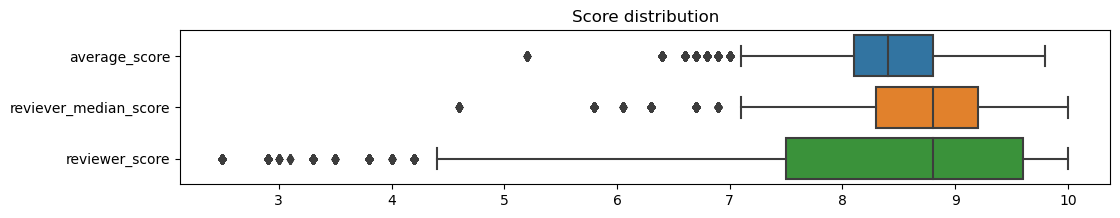

In [25]:
by_mean_score = hotels_df.groupby('hotel_name')['reviewer_score'].median()
hotels_df['reviever_median_score'] =  hotels_df.hotel_name.apply(lambda n: by_mean_score.loc[n])
fig,ax = plt.subplots(figsize=(12,2))
sns.boxplot(hotels_df[['average_score', 'reviever_median_score', 'reviewer_score']], orient='h');
plt.title("Score distribution");

Вот теперь заметно что медиана средней оценки от постояльцев несколько завышена, по сравнению с указаной в датасете, усредненой за последний год . Но поскольку нас интересует средняя оценка *по конкретному отелю*, статистическая значимость отличия в целом не имеет смысла. Просто учтем это при моделировании.

>Оба признака имею скорее категориальный порядковый тип, представленый двухразрядным числом.

In [26]:
print('Кол-во уникальных')
print('  reviewer_score:', hotels_df.reviewer_score.nunique())
print('  average_score:', hotels_df.average_score.nunique())
print('  reviever_mean_score:', hotels_df.reviever_mean_score.nunique())
print('  reviever_median_score:', hotels_df.reviever_median_score.nunique())

Кол-во уникальных
  reviewer_score: 37
  average_score: 34
  reviever_mean_score: 39
  reviever_median_score: 31


> Среднее рашрияет диапазон оценок, а вот медианное значение наоборот его сужает.

### Дата ревью и порядковй день от начала выборки день

review_date и days_since_review, взаимо заменяемые признаки.   
*  Из первого можно получить месяц, характиризующий сезон.
*  Второй малоинформативен. 

In [27]:
hotels_df['review_date'] = pd.to_datetime(hotels_df['review_date'],format= "%m/%d/%Y")
hotels_df['days_since_review'] = hotels_df['days_since_review'].str.extract(r'(\d+) day')
hotels_df['days_since_review'] = pd.to_numeric(hotels_df['days_since_review'], downcast='integer')

`days_since_review`

Распределение +/- равномерное, а значить можно учитывать влияние "сезонности" на оценку оставленую посетителем.

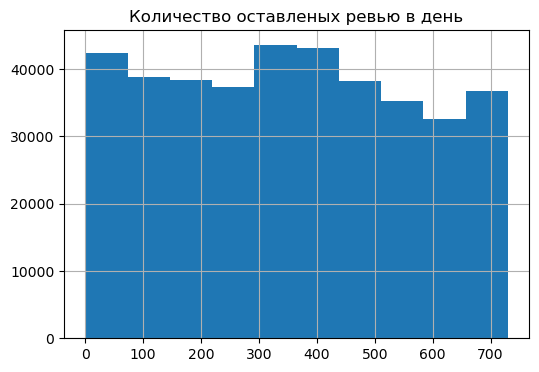

In [28]:
hotels_df['days_since_review'].hist();
plt.title("Количество оставленых ревью в день");

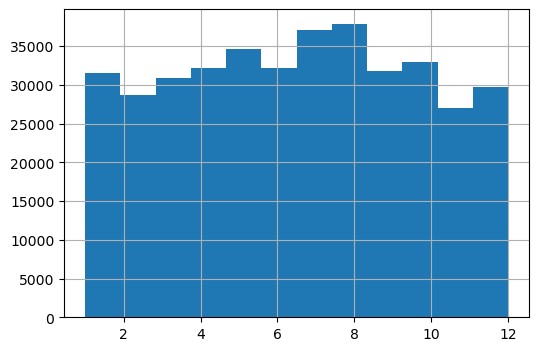

In [29]:
# Условная "сезоность", но более детализированная по месяцам
# В целом ничего интересного, +/- ~7тыс. ревью, uniform
hotels_df['month'] = hotels_df['review_date'].dt.month.astype(int)
hotels_df['month'].hist(bins=12);

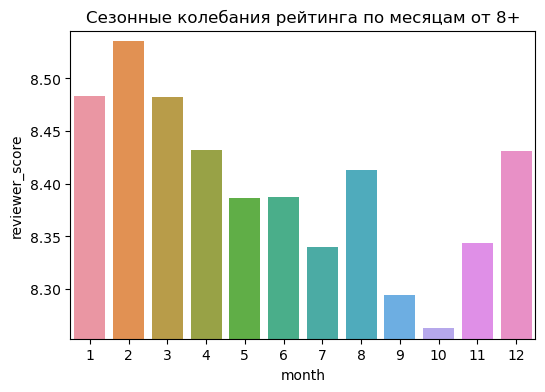

In [30]:
by_month = hotels_df.groupby('month')['reviewer_score'].mean()
ax=sns.barplot(by_month.reset_index(), x='month', y='reviewer_score');
ax.set_ylim(by_month.min()-0.01, by_month.max()+0.01)
ax.set_title("Сезонные колебания рейтинга по месяцам от 8+");

### **Страна рецензента** (reviewer_nationality)

Еще один из важных признаков, т.к. как имеем дело с культурными особеностями гостей. 

In [31]:
# Кол-во гостей в разрезе национальности. Первая семерка
print('Rev-s nationality count:', hotels_df['reviewer_nationality'].nunique())
hotels_df['reviewer_nationality'].value_counts().head(7)
# Заметен явное преобладание гостей из Англии (в разы)

Rev-s nationality count: 225


 United Kingdom               183952
 United States of America      26494
 Australia                     16216
 Ireland                       11119
 United Arab Emirates           7612
 Saudi Arabia                   6716
 Netherlands                    6598
Name: reviewer_nationality, dtype: int64

> Так как попытка использовать этот признак через бинарное кодирование особо ситуацию не улучшило, пойдем другим путем. Выделим лидеров по высокой и низкой даваемой отелю оценке (ПыСы - получили -0.0001 в MAPE :D)

In [32]:
# выделим из топ50 по количеству топ10 с высоким средним рейтингом и топ10 с низким
by_nationality = hotels_df.groupby('reviewer_nationality')[['reviewer_nationality', 'reviewer_score']].agg(['count', 'mean']).round(1)

display(by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=False).head(10))

top_10_nation = by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=False).head(10).index.to_list()

reviewer_score     
                                    count mean
reviewer_nationality                          
 United States of America           26494  8.8
 Israel                              4912  8.7
 Canada                              5977  8.6
 Australia                          16216  8.6
 New Zealand                         2443  8.6
 United Kingdom                    183952  8.5
 Hungary                             1666  8.5
 China                               2562  8.5
 Malta                               1250  8.5
 Ireland                            11119  8.5

In [33]:
display(by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=True).head(10))

low_10_nation = by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=True).head(10).index.to_list()

reviewer_score     
                                count mean
reviewer_nationality                      
 United Arab Emirates            7612  7.9
 Saudi Arabia                    6716  7.9
 Qatar                           2044  7.9
 Oman                            1019  7.9
 India                           2556  7.9
 Bahrain                         1179  8.0
 Portugal                        1379  8.0
 Lebanon                         1697  8.0
 Kuwait                          3700  8.0
 Turkey                          4102  8.0

In [34]:
# бинарный признак top_10_nation по среднему рейтингу
hotels_df['top_10_nation'] = hotels_df['reviewer_nationality'].apply(lambda x: 1 if x in top_10_nation else 0)
hotels_df[hotels_df['top_10_nation']==1][['reviewer_nationality']].sample(7)

reviewer_nationality
60514               Israel 
212208              Canada 
341458      United Kingdom 
312369      United Kingdom 
324829      United Kingdom 
3992        United Kingdom 
285360           Australia

In [35]:
# бинарный признак low_10_nation по среднему рейтингу
hotels_df['low_10_nation'] = hotels_df['reviewer_nationality'].apply(lambda x: 1 if x in low_10_nation else 0)
hotels_df[hotels_df['low_10_nation']==1][['reviewer_nationality']].sample(7)

reviewer_nationality
318063        Saudi Arabia 
204390               Qatar 
64613         Saudi Arabia 
262926            Portugal 
215421        Saudi Arabia 
49407         Saudi Arabia 
208737              Turkey

### Страна расположения отеля

In [36]:
# Этот признак мы уже выделяли в блоке очистки данных для получения "средних по больницам" координат
hotels_df['country'].value_counts()

United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: country, dtype: int64

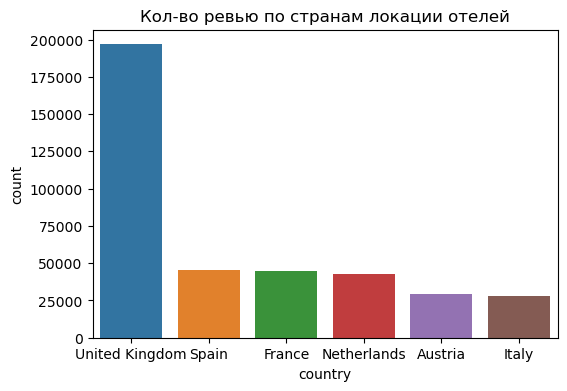

In [37]:
ax = sns.countplot(hotels_df, x='country', order=hotels_df['country'].value_counts().index)
ax.set_title('Кол-во ревью по странам локации отелей');
# На острове все педантичненько, без ревью с гостиницы не съедишь

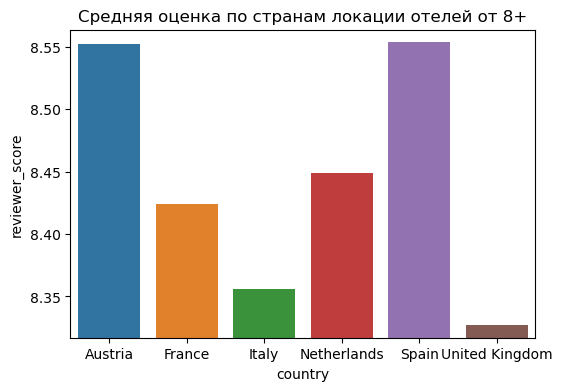

In [38]:
by_country = hotels_df.groupby('country')['reviewer_score'].mean()
ax=sns.barplot(by_country.reset_index(), x='country', y='reviewer_score');
ax.set_ylim(by_country.min()-0.01, by_country.max()+0.01)
ax.set_title("Средняя оценка по странам локации отелей от 8+");

In [39]:
# "Цель прибывания" или что то типа того. Разделим на деловую и просто пошарахаться/отдых/шоппинг
hotels_df['purpose_arrival'] = hotels_df['tags'].str.extract(r'([LB].+) trip') # .?\'?
hotels_df['purpose_arrival'].value_counts()

Leisure     313353
Business     61934
Name: purpose_arrival, dtype: int64

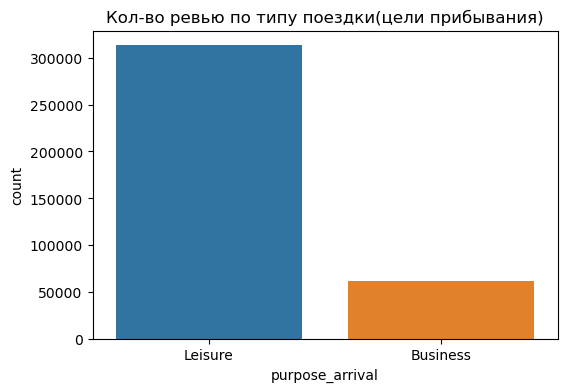

In [40]:
ax=sns.countplot(hotels_df, x='purpose_arrival');
ax.set_title('Кол-во ревью по типу поездки(цели прибывания)');

In [41]:
# Возмем отдельно только признак "бизнес-тур, а все остальное - в остальное. 
hotels_df['is_business'] = hotels_df['purpose_arrival'].apply(lambda x: 1 if x=='Business' else 0)

### Заявленое время проживания (из тэгов)

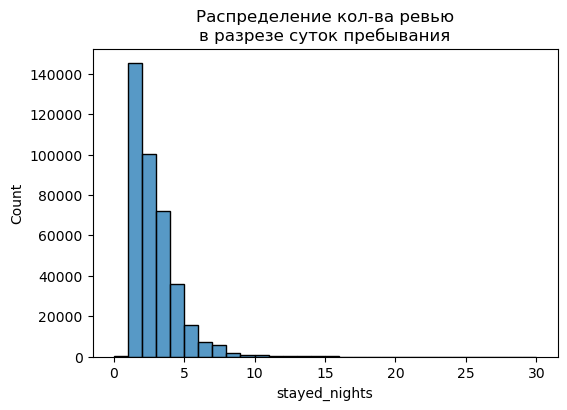

In [42]:
# Похоже на кол-во заявленых суток пребывания. Не факт, что факт, но планы то были. 
# учтем-с как числовой. Мало-ли, вдруг влияет на субъективность оценки.
hotels_df['stayed_nights'] = hotels_df['tags'].str.extract(r'Stayed (\d+) night').fillna(0).astype(int)
#hotels_df['stayed_nights'].value_counts().head(5)
sns.histplot(hotels_df, x='stayed_nights', bins=30);
plt.title("Распределение кол-ва ревью\nв разрезе суток пребывания");

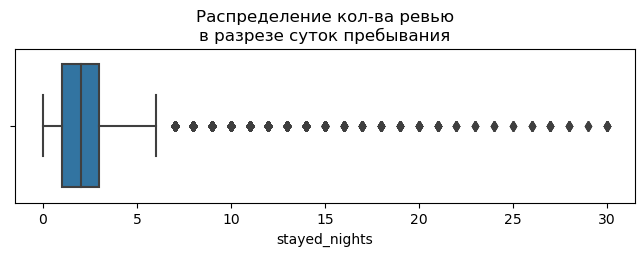

In [43]:
fig, ax = plt.subplots(figsize=(8,2))
sns.boxplot(hotels_df, x='stayed_nights', ax=ax);
plt.title("Распределение кол-ва ревью\nв разрезе суток пребывания");

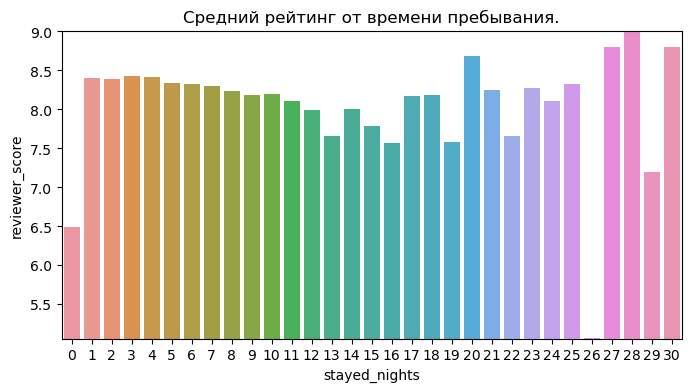

In [44]:
by_stayed_nights = hotels_df.groupby('stayed_nights')['reviewer_score'].mean()
fig, ax = plt.subplots(figsize=(8,4))
ax=sns.barplot(by_stayed_nights.reset_index().\
               sort_values(by='stayed_nights'), x='stayed_nights', y='reviewer_score');
ax.set_ylim(by_stayed_nights.min()-.01, by_stayed_nights.max()+.01)
ax.set_title("Средний рейтинг от времени пребывания.");

Так как после 10-15 суток условно-потенциальные выбросы, интересен только низкий рейтин в нуле. Хотя заметен спад рейтига по мере увеличения времени прибывания.

### Доп. признаки-индикаторы состава проживающих на ревью (из тэгов)
Количествово проживающих на ревью: соло, пара, семья, группа.

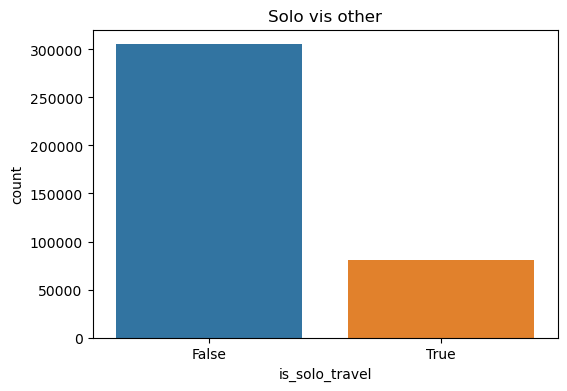

In [45]:
hotels_df['is_solo_travel'] = hotels_df['tags'].str.contains(r'Solo traveler')
ax = sns.countplot(hotels_df, x='is_solo_travel');
ax.set_title('Solo vis other');

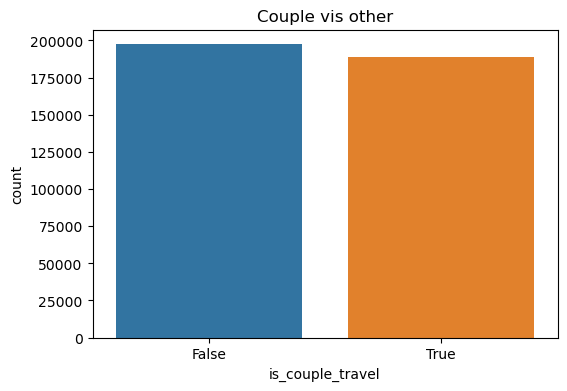

In [46]:
hotels_df['is_couple_travel'] = hotels_df['tags'].str.contains(r'Couple')
ax=sns.countplot(hotels_df, x='is_couple_travel');
ax.set_title('Couple vis other');

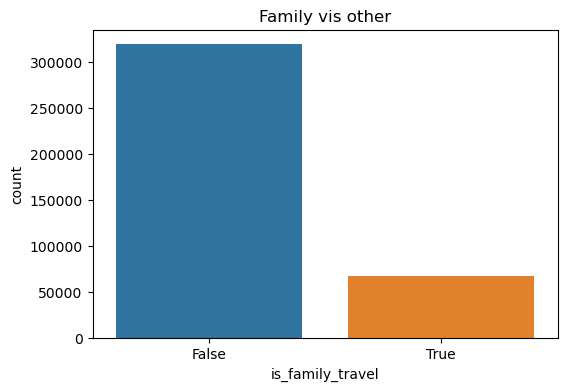

In [47]:
hotels_df['is_family_travel'] = hotels_df['tags'].str.contains(r'Family')
ax=sns.countplot(hotels_df, x='is_family_travel');
ax.set_title('Family vis other');

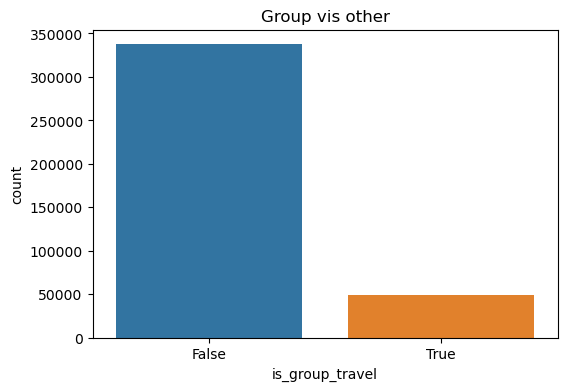

In [48]:
hotels_df['is_group_travel'] = hotels_df['tags'].str.contains(r'Group')
ax=sns.countplot(hotels_df, x='is_group_travel');
ax.set_title('Group vis other');

### Негативные и позитивные комментарии
-  Весма странная картина, особено в негативных. Низкое качество парсинга.

In [49]:
hotels_df[['negative_review']].value_counts().head(10)
# "No Negative" еще ладно, но "Breakfast"... это разве плохо? гораздо хуже когда его нет

negative_review
No Negative        95833
 Nothing           10733
 Nothing            3152
 nothing            1658
 N A                 802
 None                737
                     606
 N a                 384
 Breakfast           296
 Small room          283
dtype: int64

In [50]:
hotels_df[['positive_review']].value_counts().head(10)

positive_review
No Positive        26863
 Location           6824
 Everything         1697
 location           1248
 Nothing             930
 The location        828
 Great location      807
 Good location       690
 Location            663
 Breakfast           455
dtype: int64

### **Ревью - Самые.Важные.Признаки**
-  Количество негатива в обзоре
-  Количества позитива в обзоре

>Они то и формируют объективный и субъективный отклик проживающего.


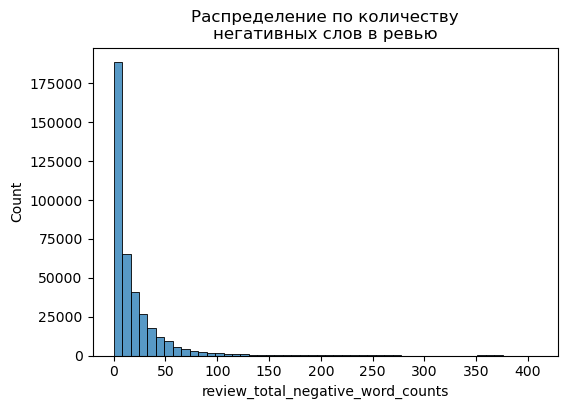

In [51]:
sns.histplot(hotels_df, x='review_total_negative_word_counts', bins=50);
plt.title("Распределение по количеству\nнегативных слов в ревью");

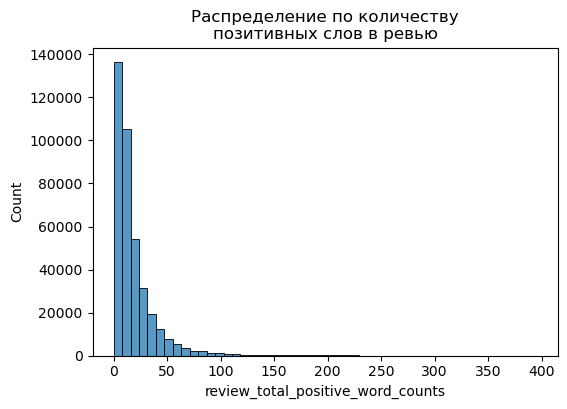

In [52]:
sns.histplot(hotels_df, x='review_total_positive_word_counts', bins=50);
plt.title("Распределение по количеству\nпозитивных слов в ревью");

In [53]:
score_period = (hotels_df['review_date'].max() - hotels_df['review_date'].min()).days
print('Временой период обработки данных(дни):', score_period)

Временой период обработки данных(дни): 730


## Отдельный анализ положительных и отрицательных отзывов

> Так как распределение положительных оценок и отрицательных в обзорах слегка не соответсвуют действительности, сформируем пару признаков отражающих эти оценки более реалистично.

-  В позитивных меняем "No Positive", в негативных "No Negative" на их смысловые противоположности. с диалектикой у nltk не очень.
-  склеиваем negative_review + positive_review и анализируем через nltk 


In [54]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# nltk.downloader.download('stopwords')
# from nltk.corpus import stopwords

#  Очень долго работает на Colab и Kaggle. Если нужен подбор других 
# параметров(или отладка), можно этот этап и пропустить, оставив константами.
hotels_df[['neg_ratio', 'pos_ratio']] = [.5, .5]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
# Пойдем самым линейным путем
# в "No Negative" вложим позитивную коннотацию
hotels_df['negative_review_'] = hotels_df['negative_review'].str.replace("No Negative", "Positive")

# в "No Positive" вложим негативную коннотацию
hotels_df['positive_review_'] = hotels_df['positive_review'].str.replace("No Positive", "Negative")

In [56]:
hotels_df[['negative_review_']].value_counts().head(7)

negative_review_
Positive            95833
 Nothing            10733
 Nothing             3152
 nothing             1658
 N A                  802
 None                 737
                      606
dtype: int64

In [57]:
hotels_df[['positive_review_']].value_counts().head(7)

positive_review_
Negative            26863
 Location            6824
 Everything          1697
 location            1248
 Nothing              930
 The location         828
 Great location       807
dtype: int64

In [58]:
%%time
sent_analyzer = SentimentIntensityAnalyzer()
def _analyzer(review):
    result = sent_analyzer.polarity_scores(review)
    return pd.Series([result['neg'], result['pos']])

# склеим ревью и расчитаем показатели
hotels_df[['neg_ratio', 'pos_ratio']] = (hotels_df['negative_review_'] + ';' + hotels_df['positive_review_']).apply(_analyzer)
hotels_df.drop(columns=['negative_review_', 'positive_review_'], inplace=True)

CPU times: total: 3min 30s
Wall time: 3min 31s


In [59]:
# пощелкаем в сэмплах
hotels_df[['negative_review', 'neg_ratio', 'positive_review', 'pos_ratio']].sample(10)

negative_review  neg_ratio  \
72281    The glass shower in the middle of the room Th...      0.139   
262051   I think you need a usher in the cinema 20 min...      0.000   
268796   rooms are quite small also think breakfast co...      0.134   
69230                        Room was smaller than photo       0.000   
136811   Not enough info on how to make the most of th...      0.000   
136437                                        No Negative      0.000   
90593                                         No Negative      0.010   
90301    Sauna wasn t on when we went to use it but wa...      0.000   
36578                                         No Negative      0.000   
152115   A greater range of fruit at breakfast would h...      0.000   

                                          positive_review  pos_ratio  
72281                                         No Positive      0.000  
262051   The friendliness of the staff and such a beau...      0.182  
268796   well decorated rooms and shower is to die for...      0.141  
69230                                            Location      0.000  
136811   Lovely d cor quality fittings sophisticated t...      0.388  
136437   The service was excellent It was my parents g...      0.448  
90593    We really enjoyed this accommodation with its...      0.243  
90301    Nice friendly staff who are more than happy t...      0.472  
36578                                         Room dising      0.643  
152115   Very clean and tidy hotel with good facilitie...      0.476

In [60]:
# такое себе, но попробуем отдельным экспериментом. ( Спойлер - оказался не прав ;) )

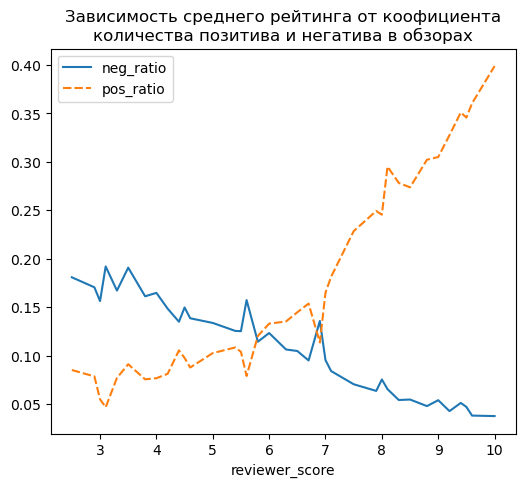

In [61]:
by_target = hotels_df.groupby('reviewer_score')[['neg_ratio', 'pos_ratio']].mean()
fig, ax = plt.subplots(figsize=(6,5))
sns.lineplot(by_target)
plt.title('Зависимость среднего рейтинга от коофициента\nколичества позитива и негатива в обзорах');

### Итог по анализу комментариев из ревью
Как видим, близкая к линейной зависимости целевой переменной от комбинации позитивной и негативной коннотации в ревью.

## Общий отчет по датасету средствами Sweetviz
*  Относительно затратная по времени операция, используем сугубо один раз

In [62]:
%%time
### Уменьшаем объем отчета, по уже обработаным признакам на данном этапе
no_report_columns = ['hotel_address', 'tags', 'positive_review', 'negative_review']
report = sweetviz.analyze(hotels_df.drop(columns=no_report_columns), target_feat='reviewer_score')

                                             |                                   | [  0%]   00:00 -> (? left)

CPU times: total: 1min 50s
Wall time: 1min 50s


In [63]:
### (!) Лучше так не делать. Смешивая с ML эксперементами - ломается основная панель Comet/ML с графиками метрик
### + у меня перестал логироваться HTML, возможно это связано с... чертегознаетсчем.

# ### Сохраним аналитику в отчете sweetviz в ML трекере.
# exp_version[1] += 1
# experiment = comet.Experiment(**EXPERIMENT_PARAMS)
# experiment.set_name('Analitics')
# experiment.add_tag('EDA {}.{}'.format(exp_version[0], exp_version[1]))

# ### Сохраняем в трекер
# report.log_comet(experiment)
# experiment.end()

In [64]:
# experiment.end()


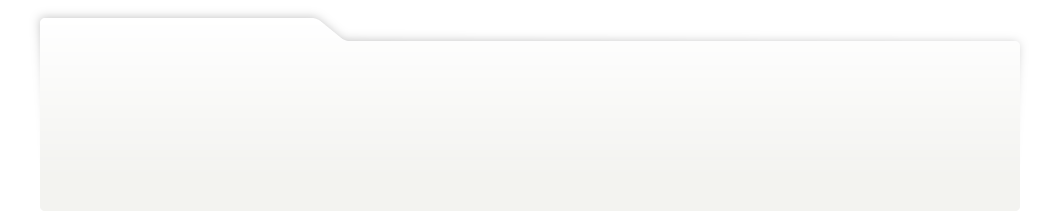
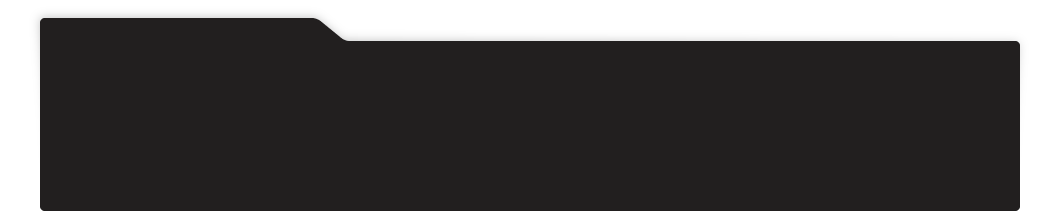
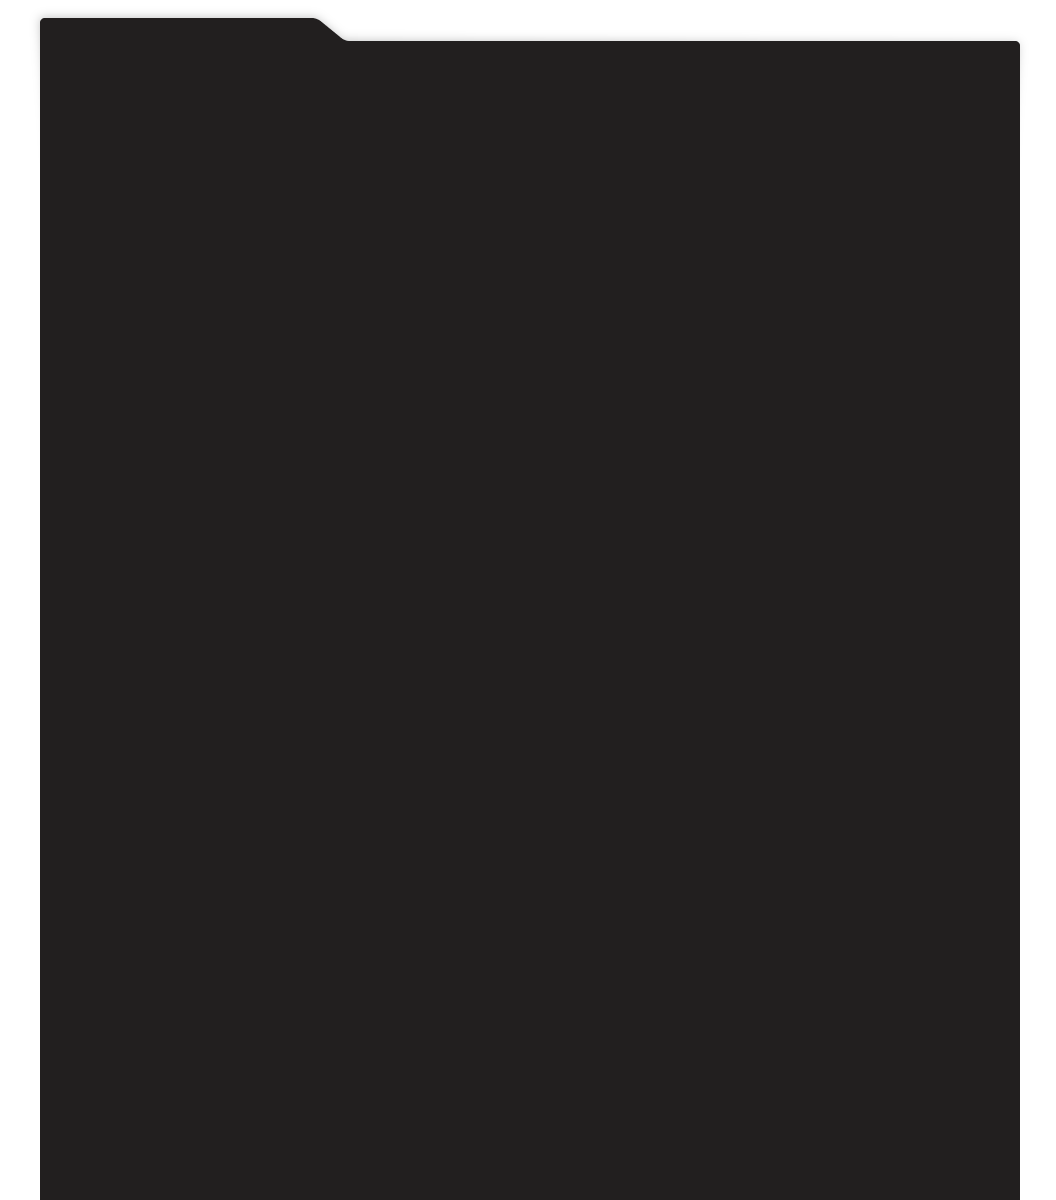
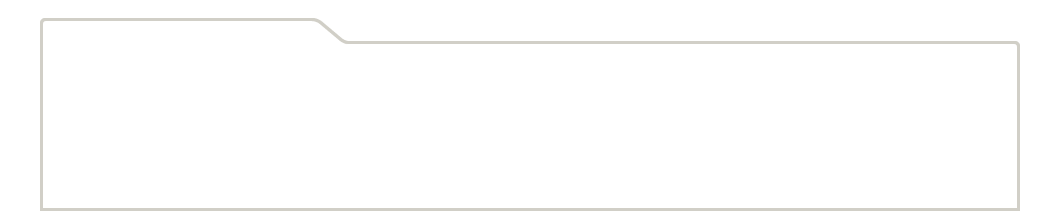
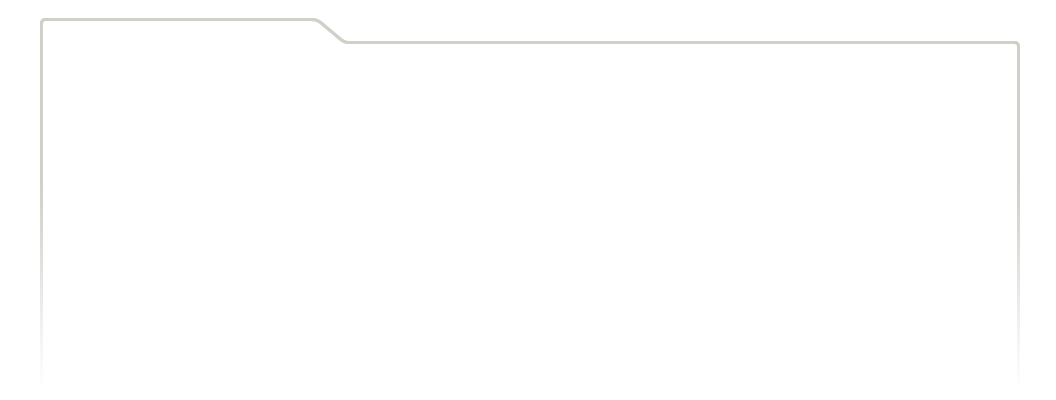
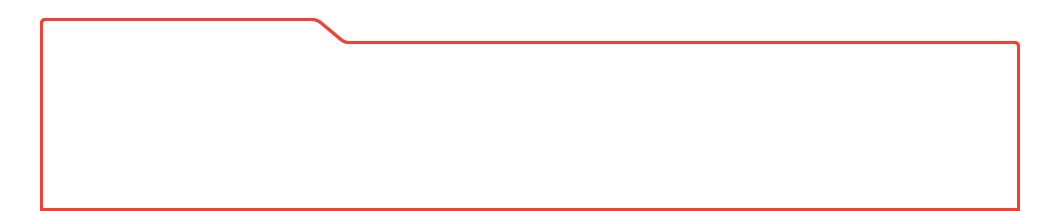
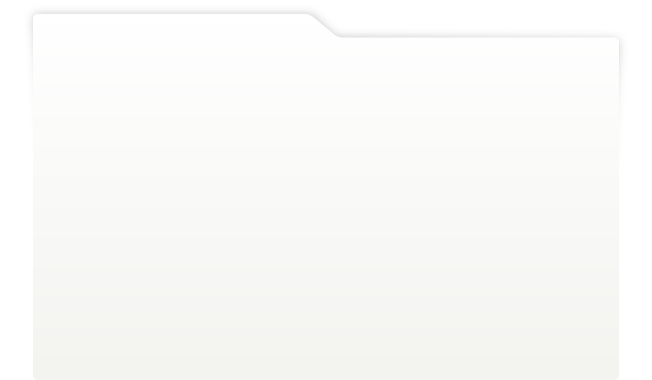
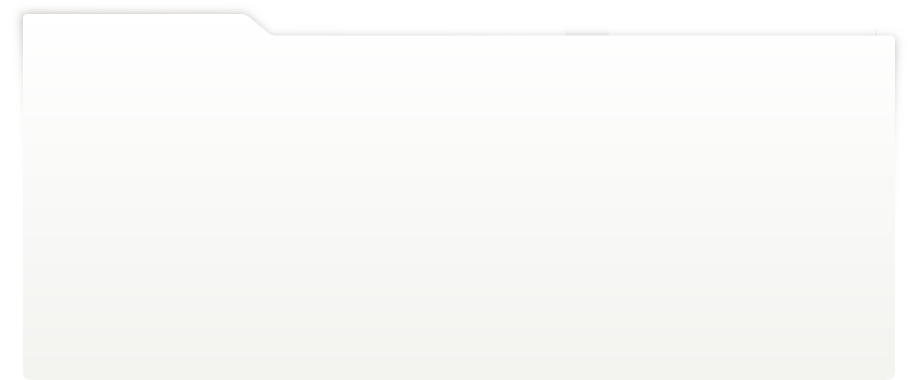
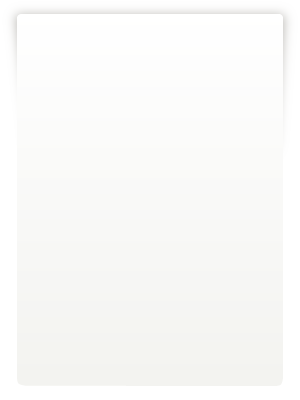
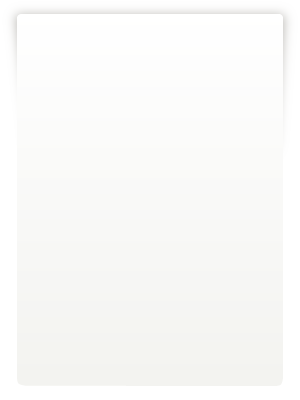
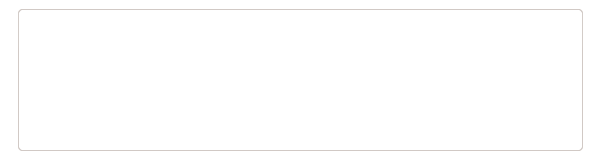
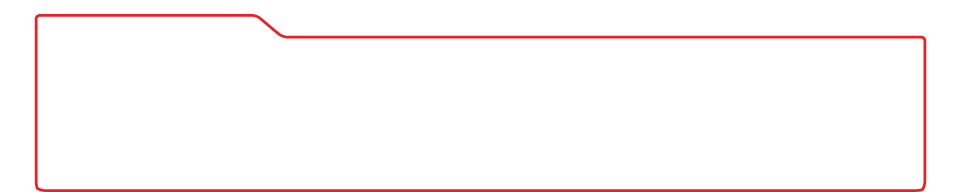
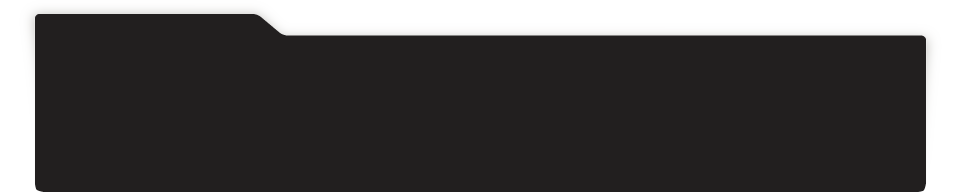
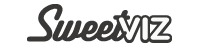
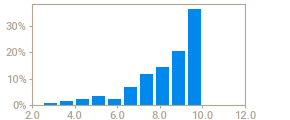
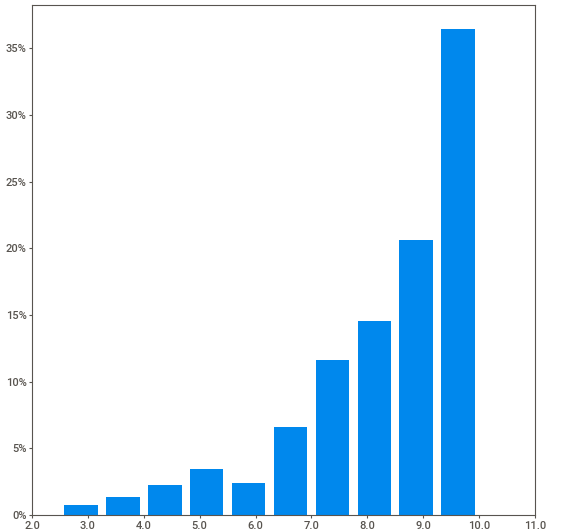
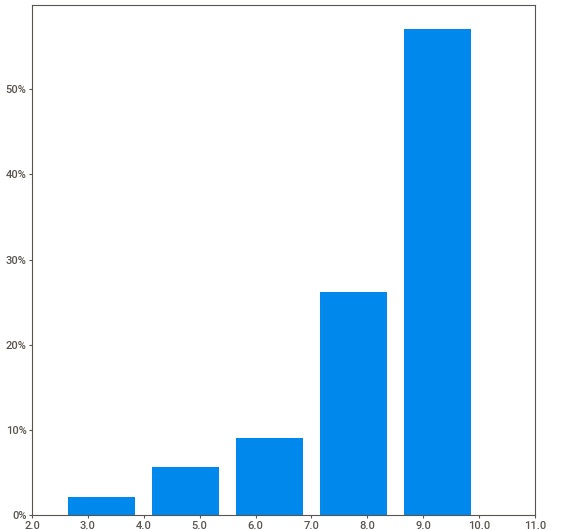
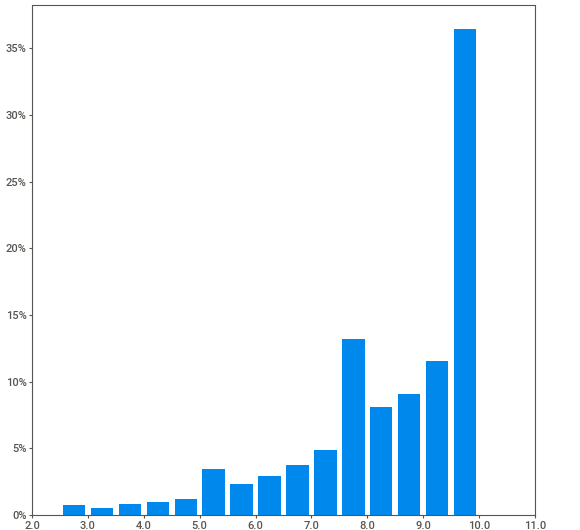
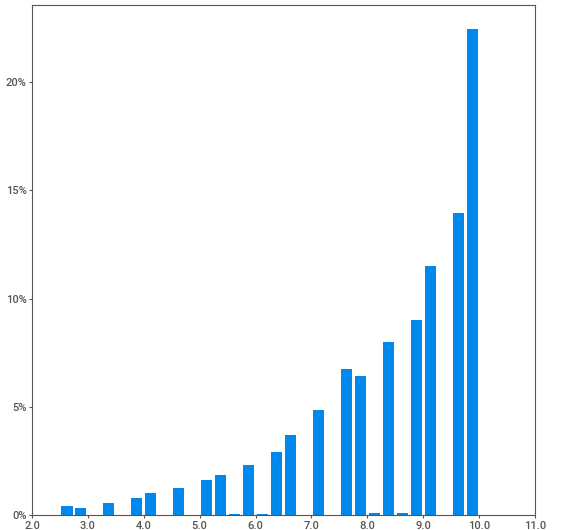
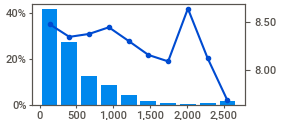
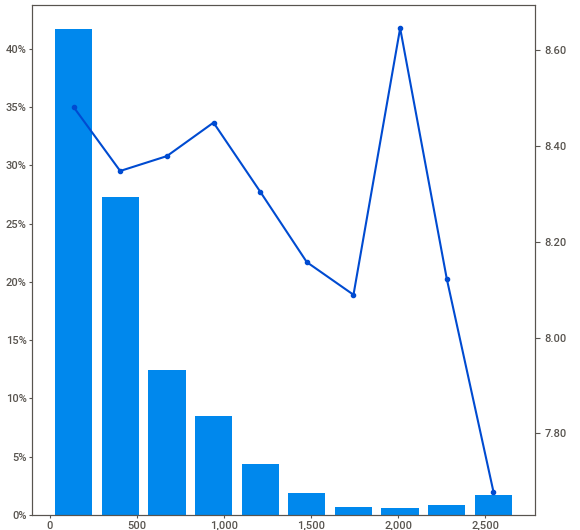
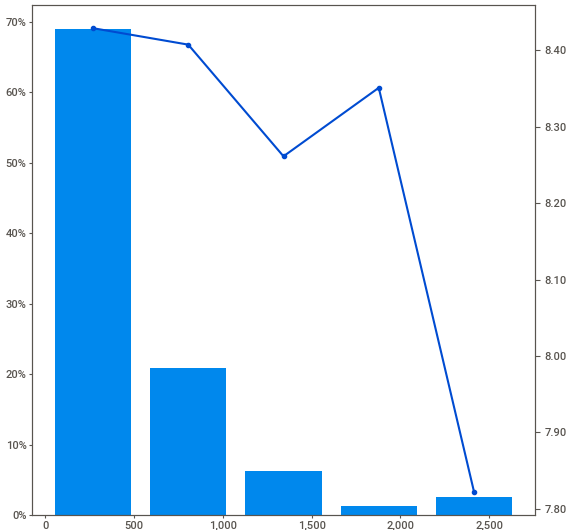
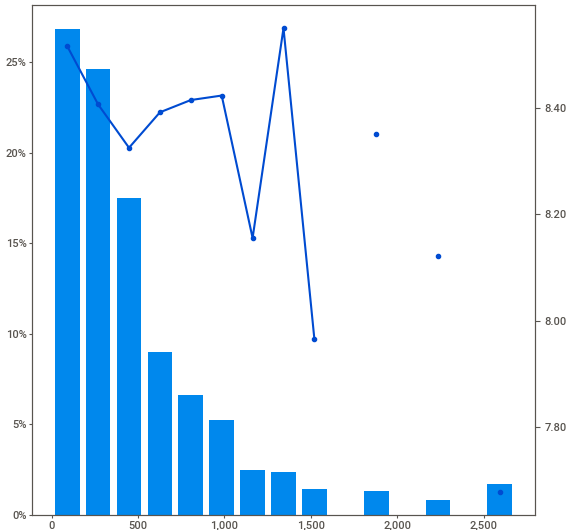
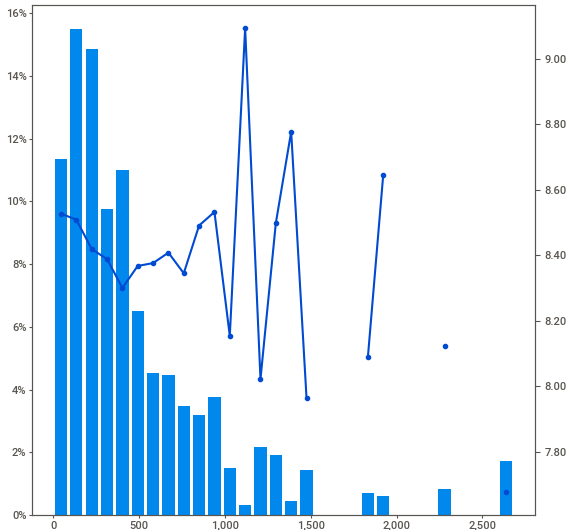
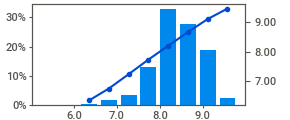
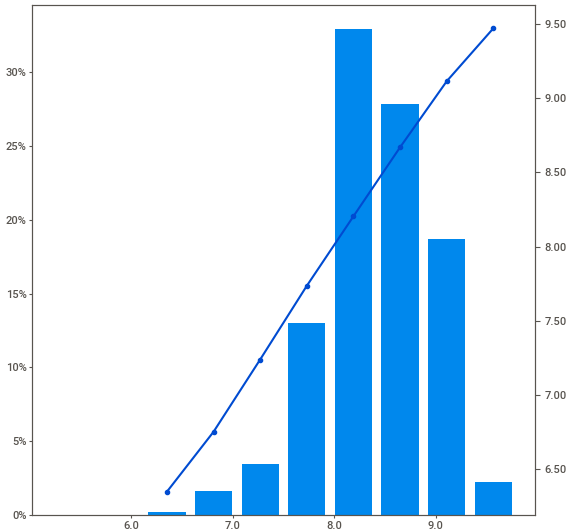
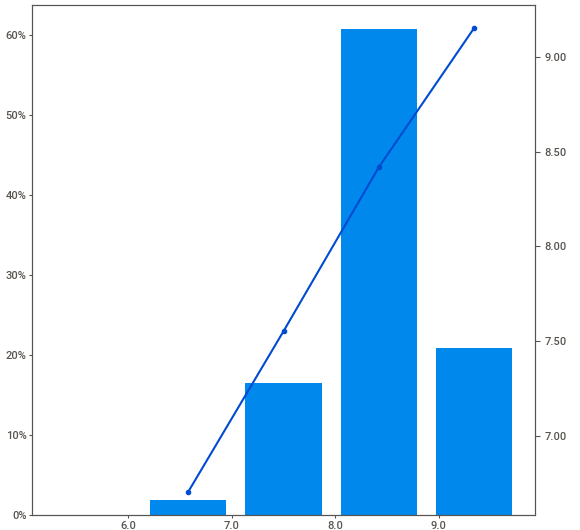
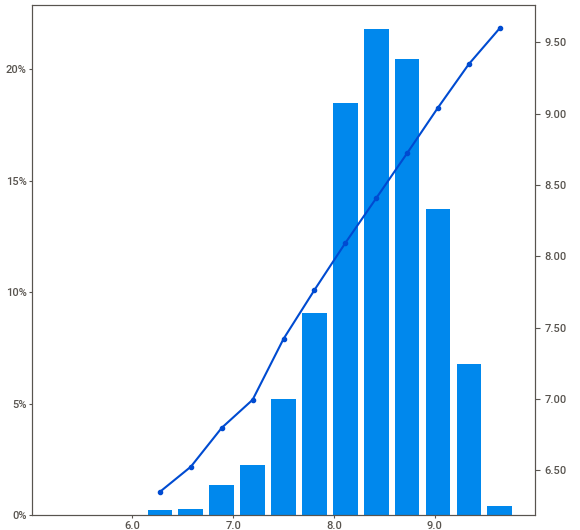
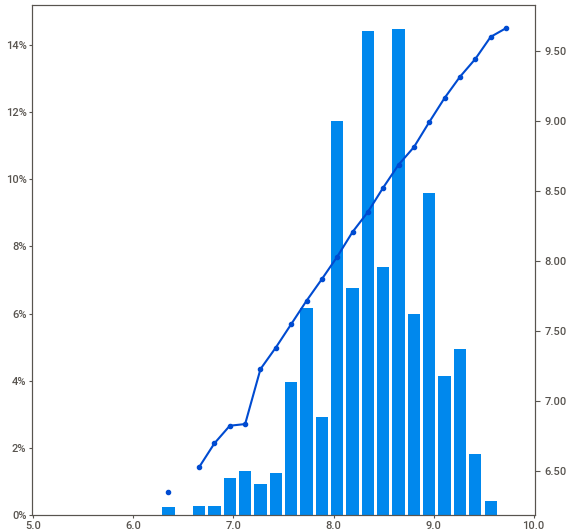
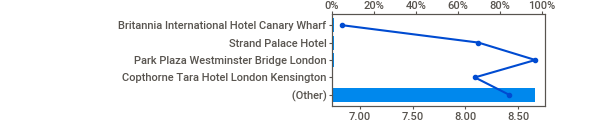
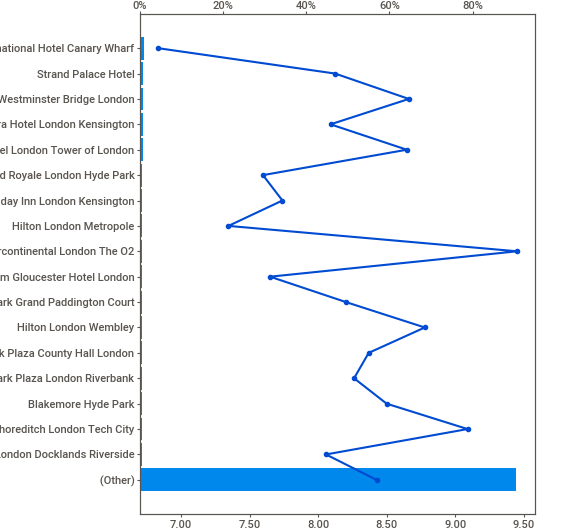
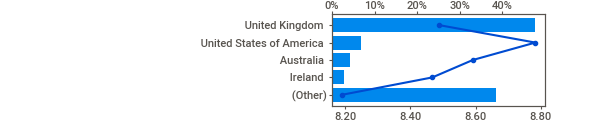
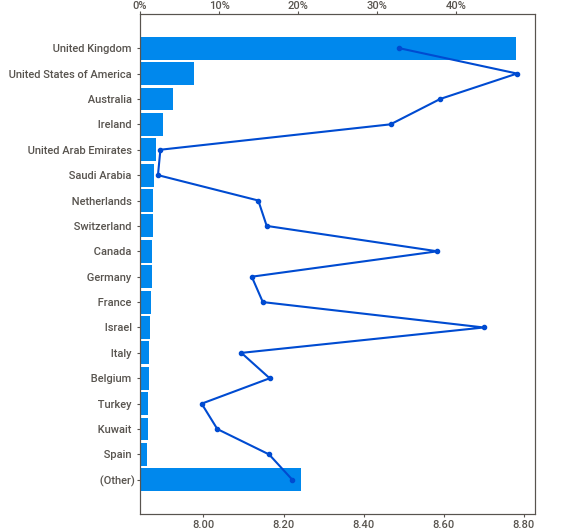
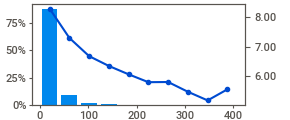
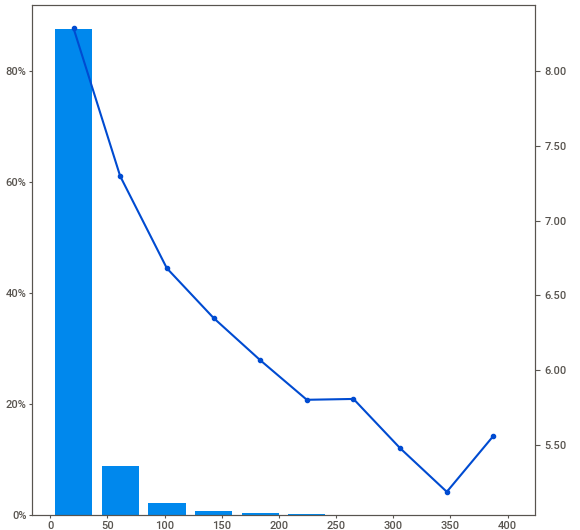
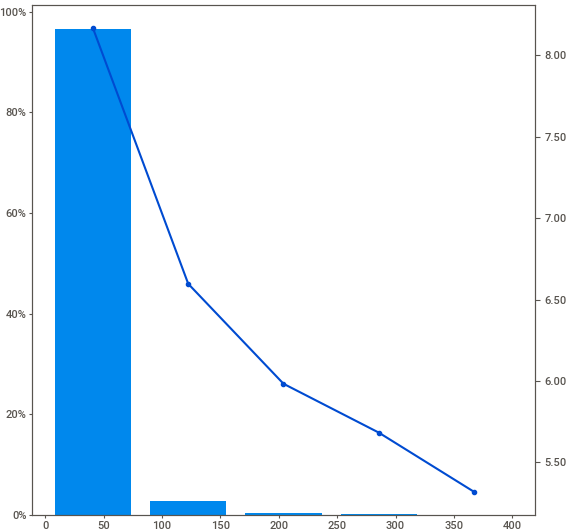
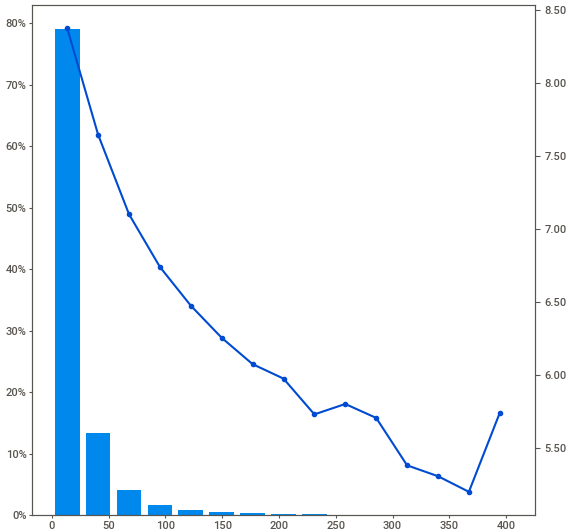
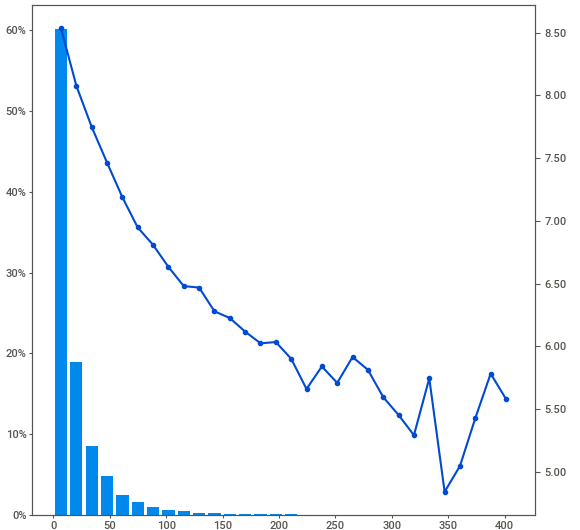
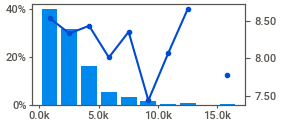
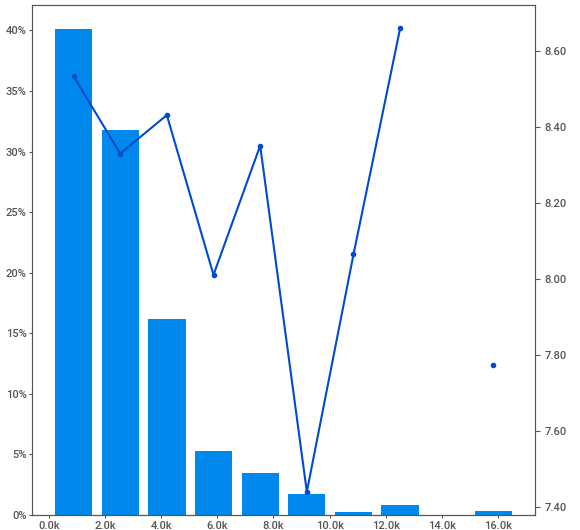
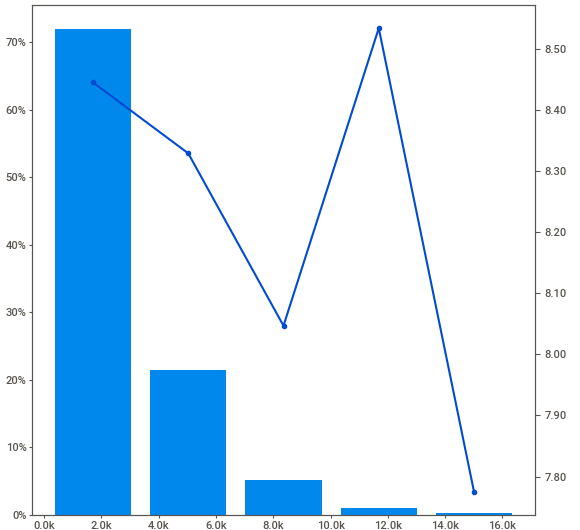
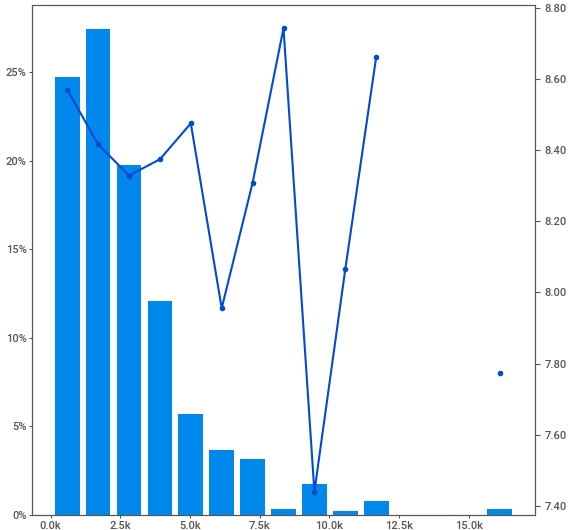
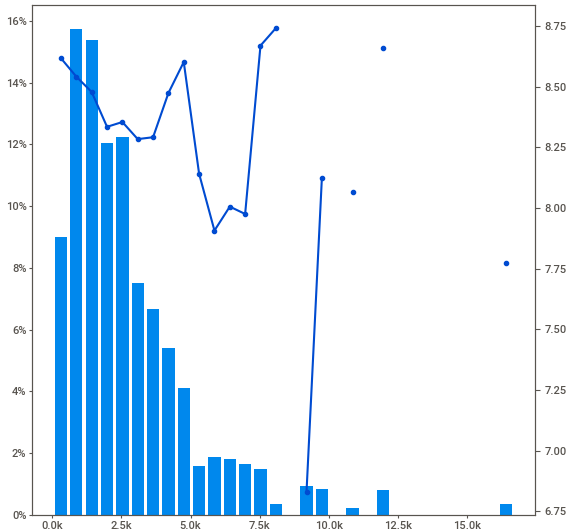
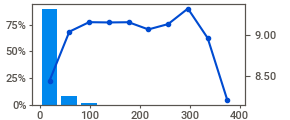
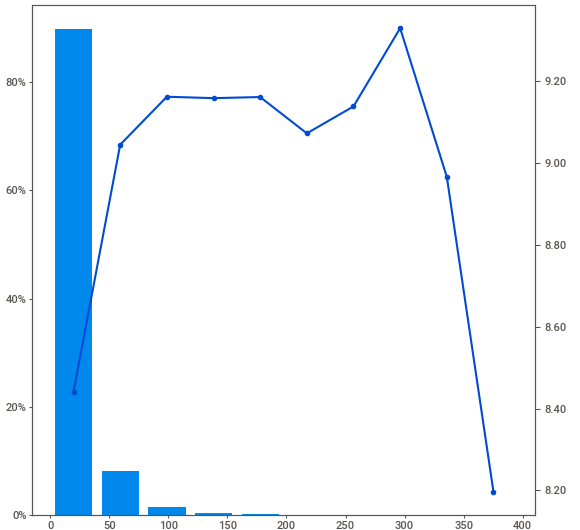
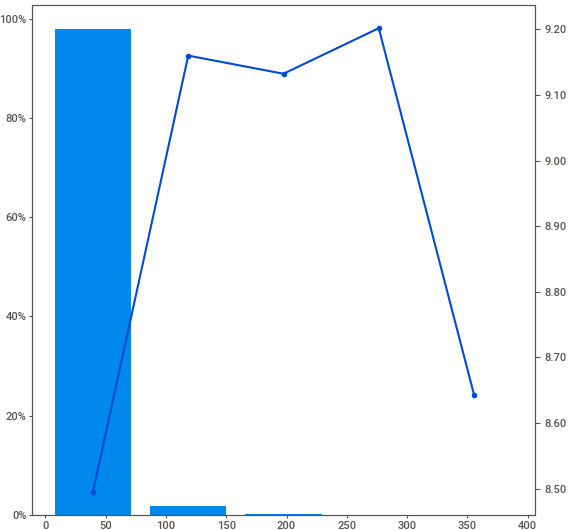
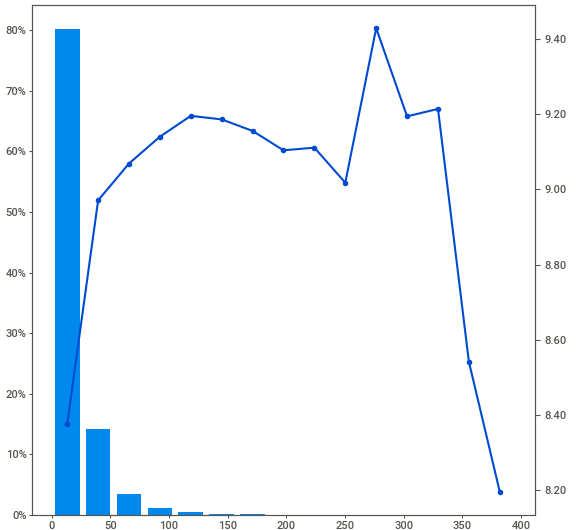
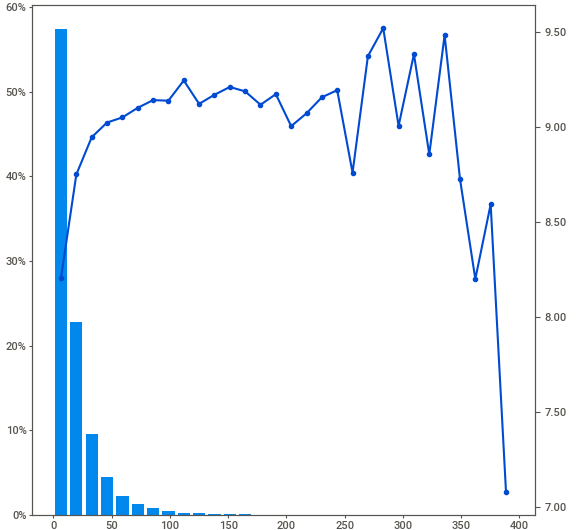
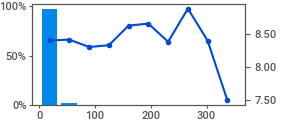
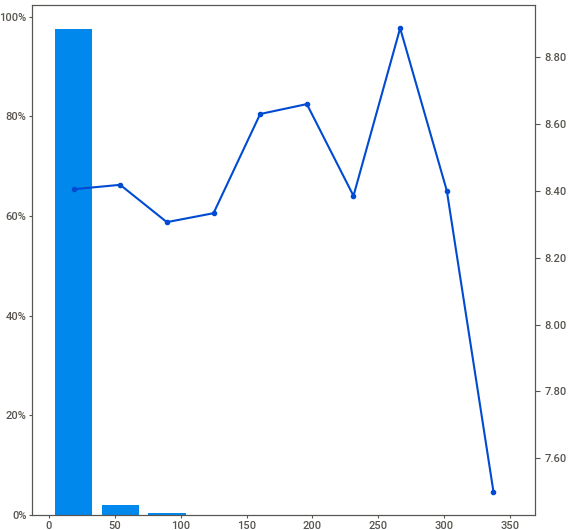
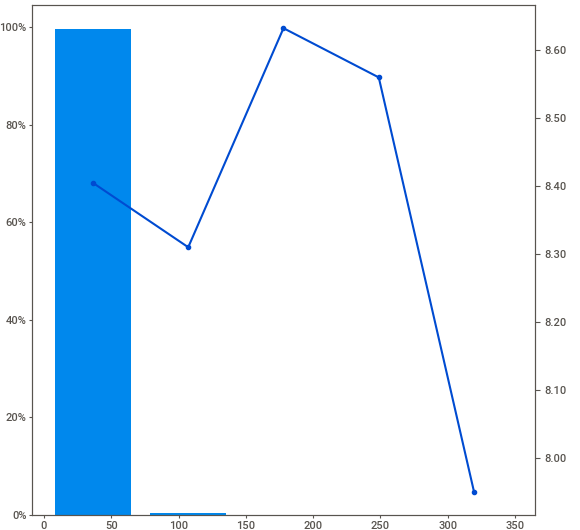
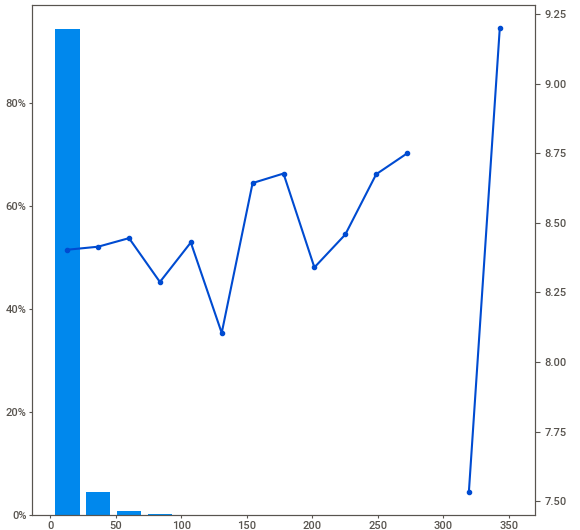
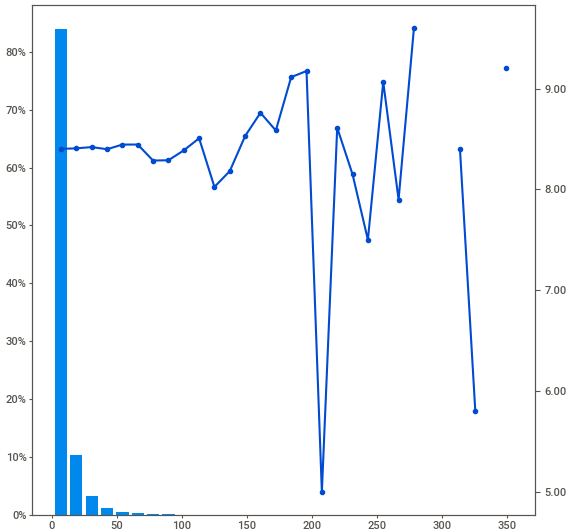
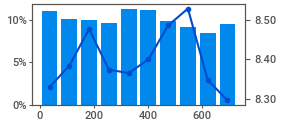
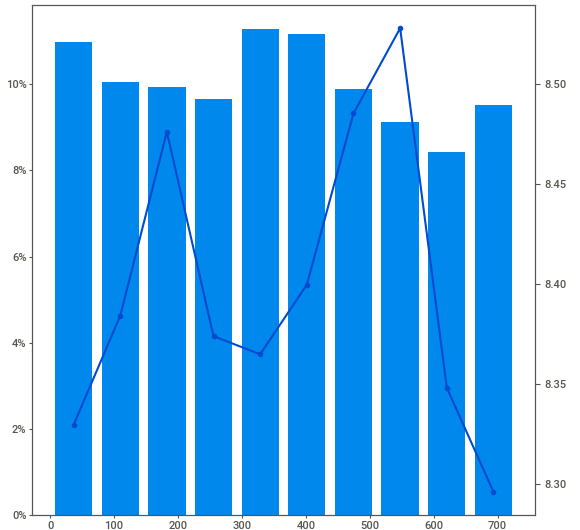
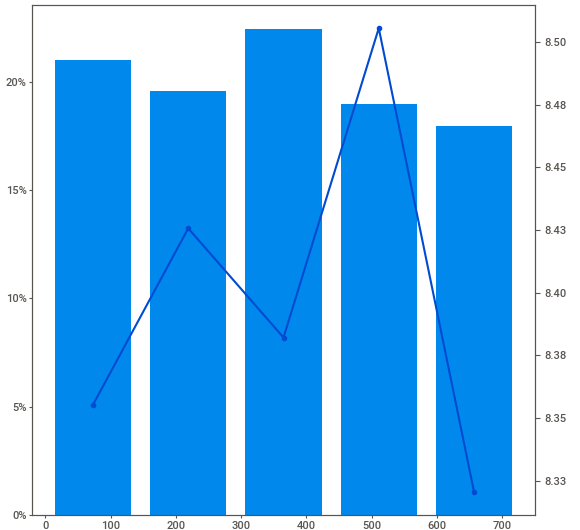
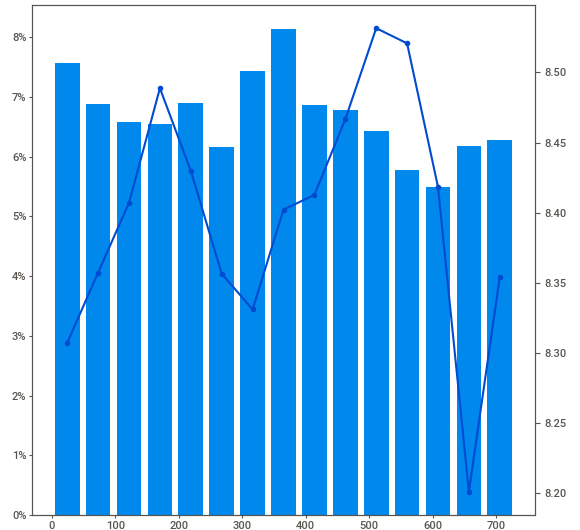
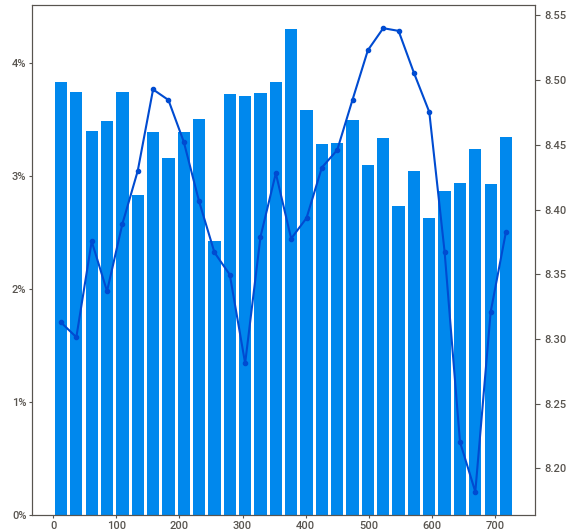
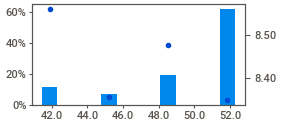
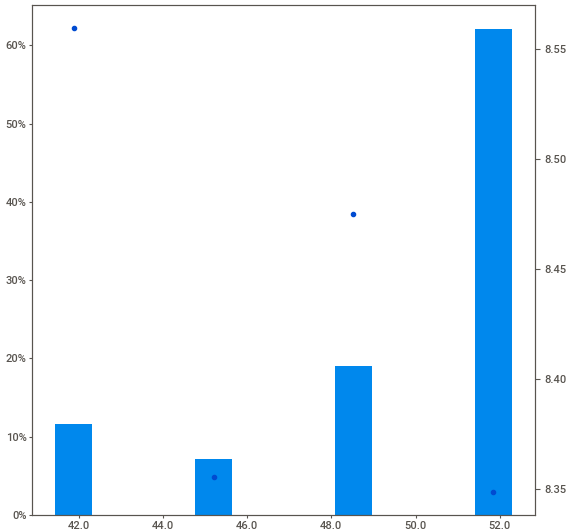
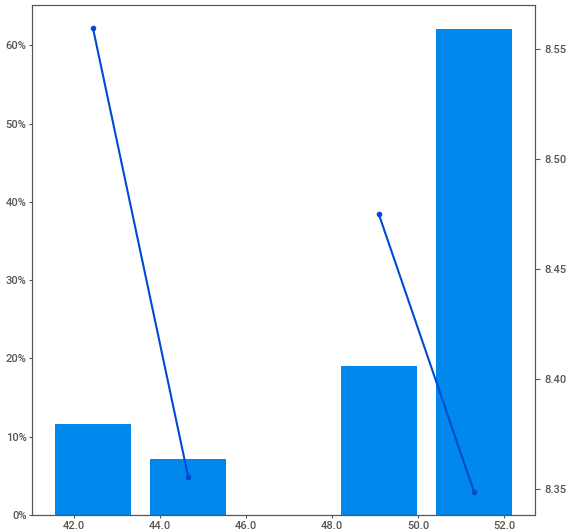
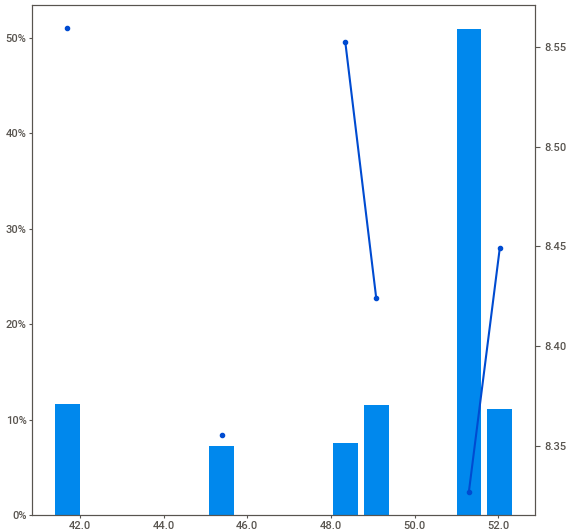
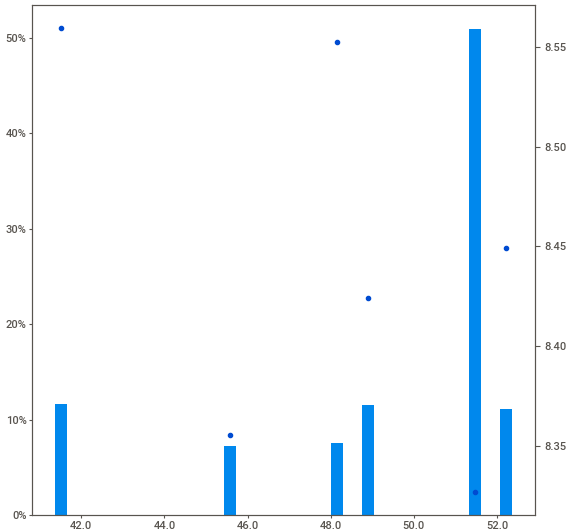
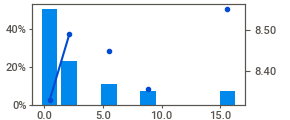
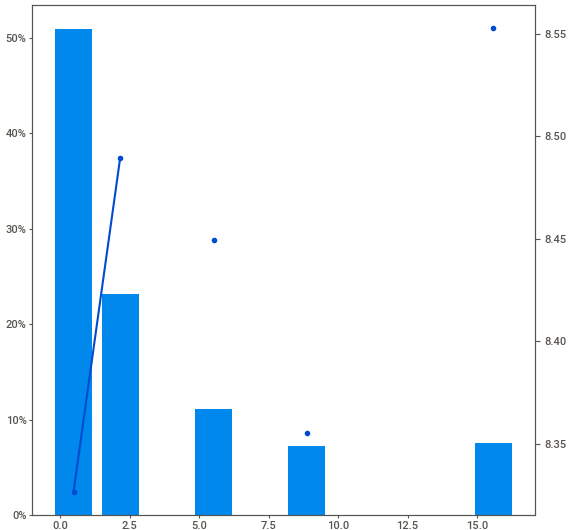
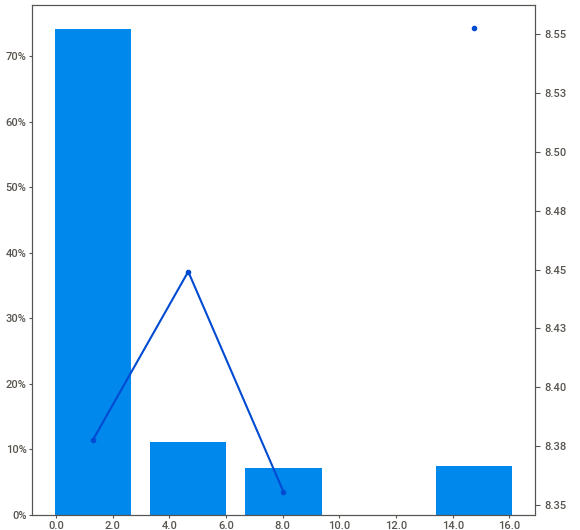
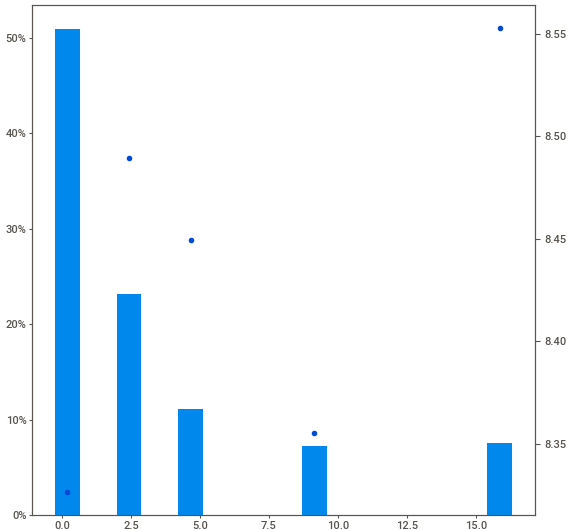
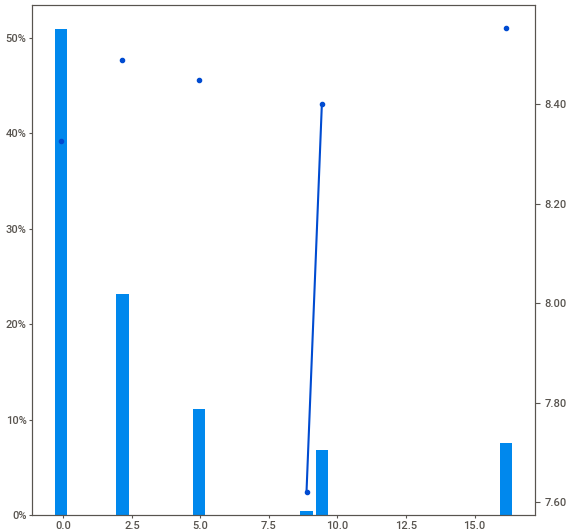
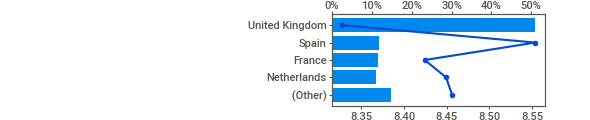
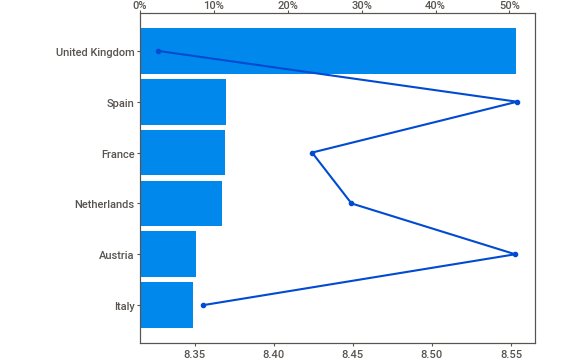
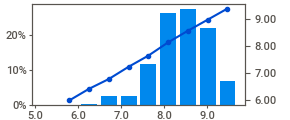
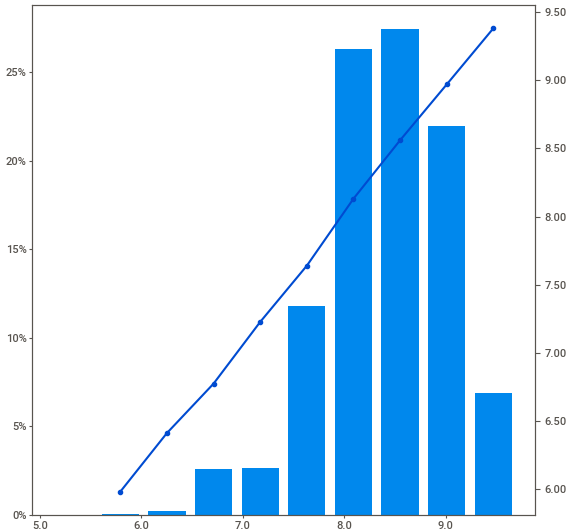
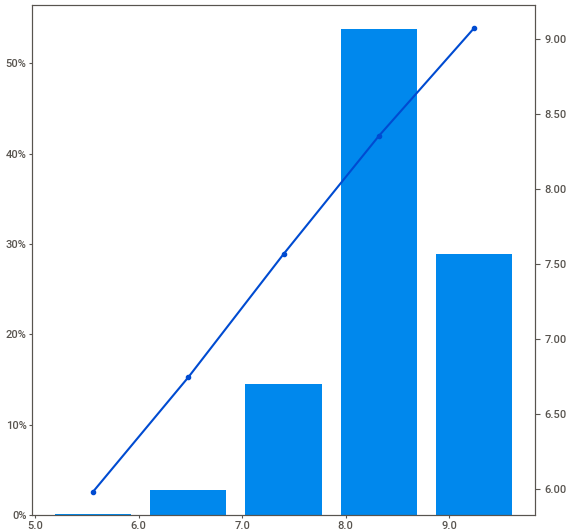
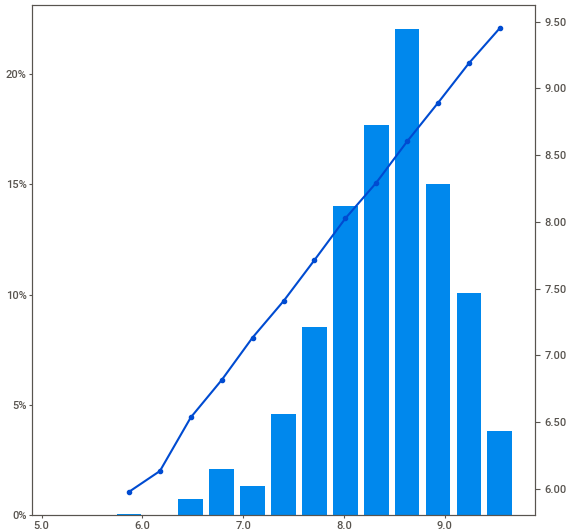
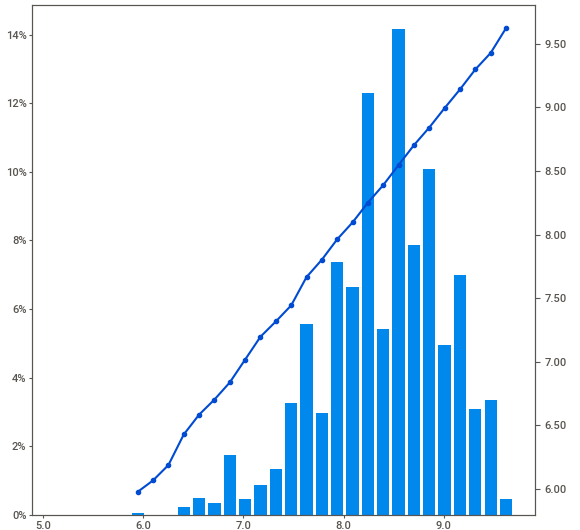
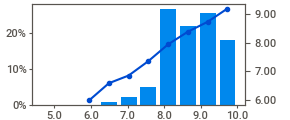
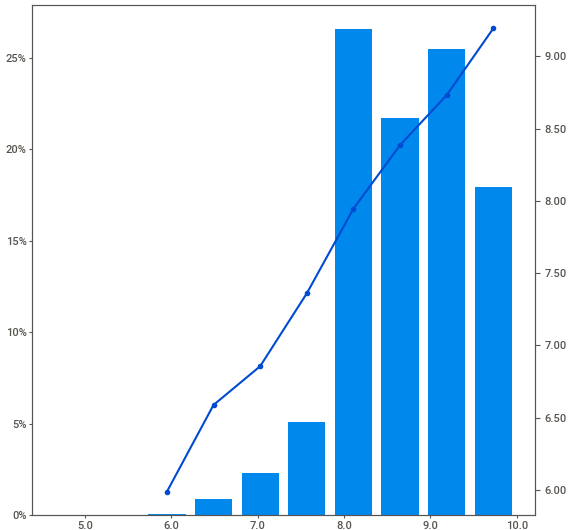
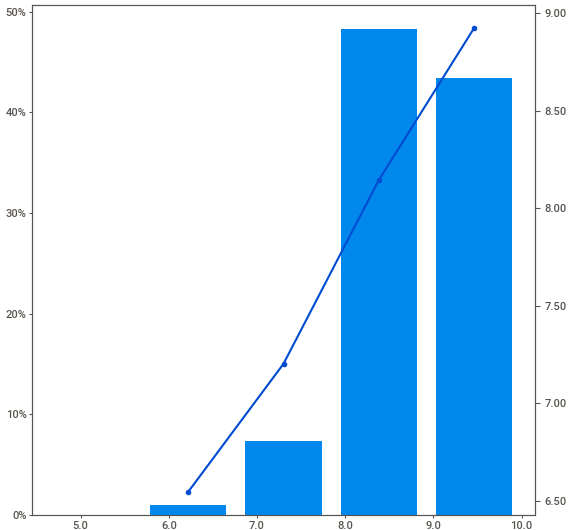
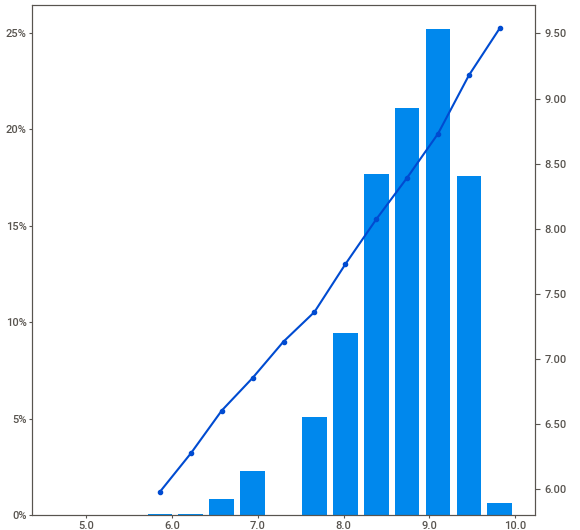
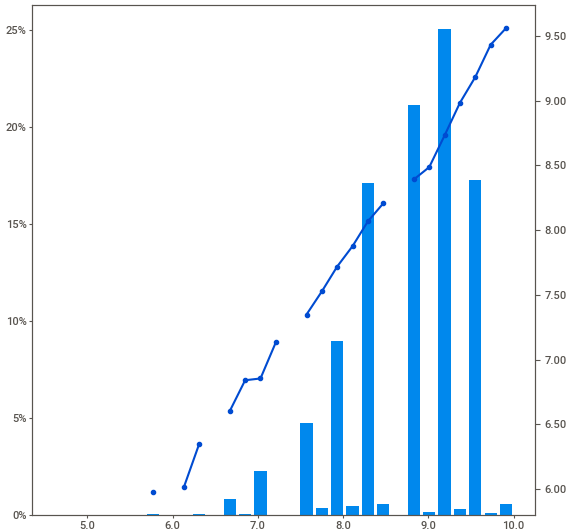
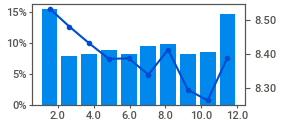
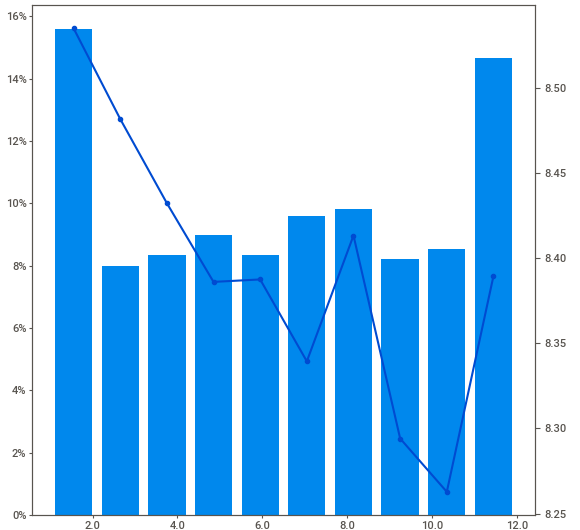
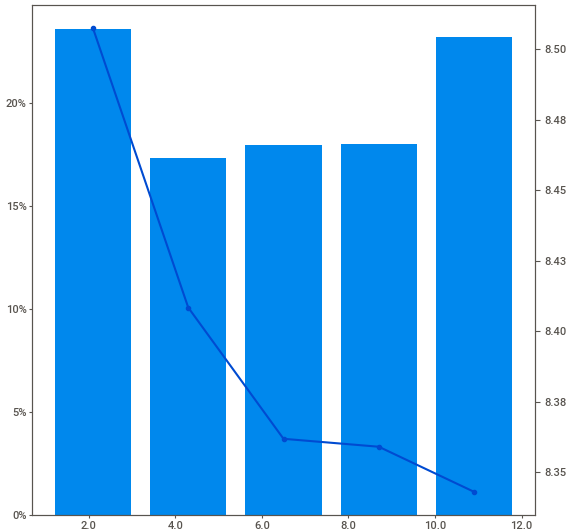
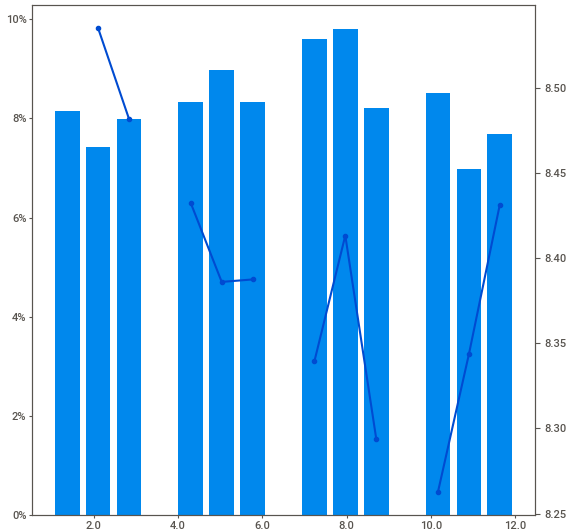
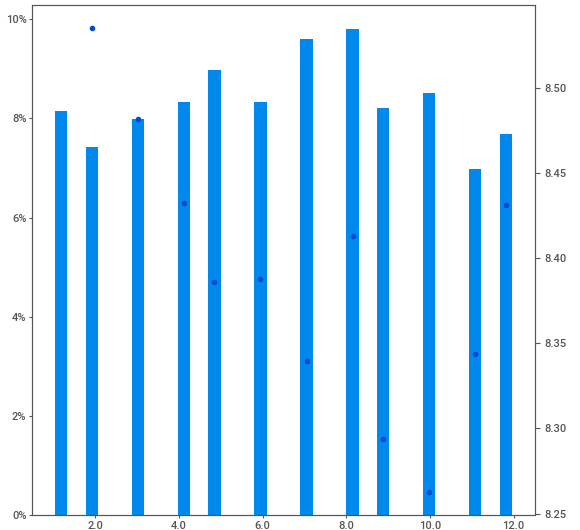
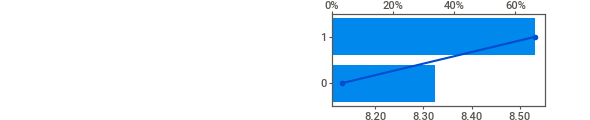
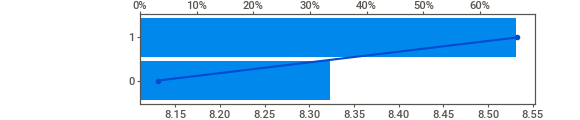
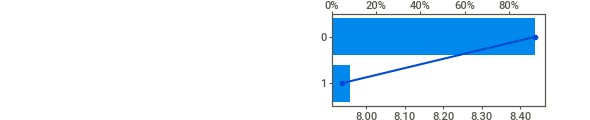
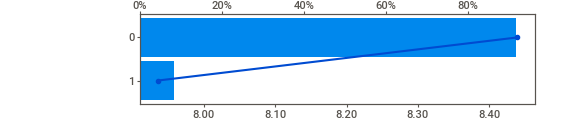
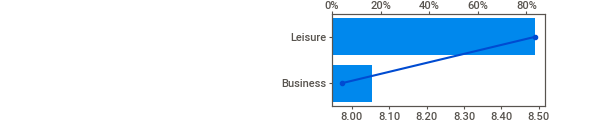
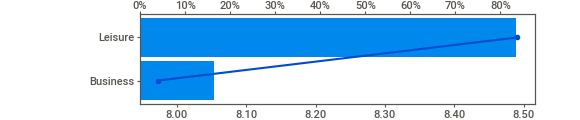
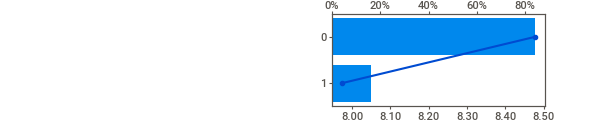
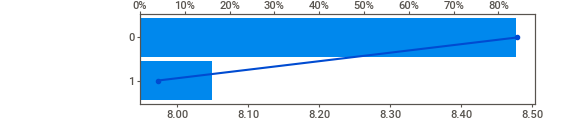
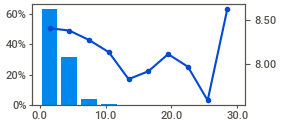
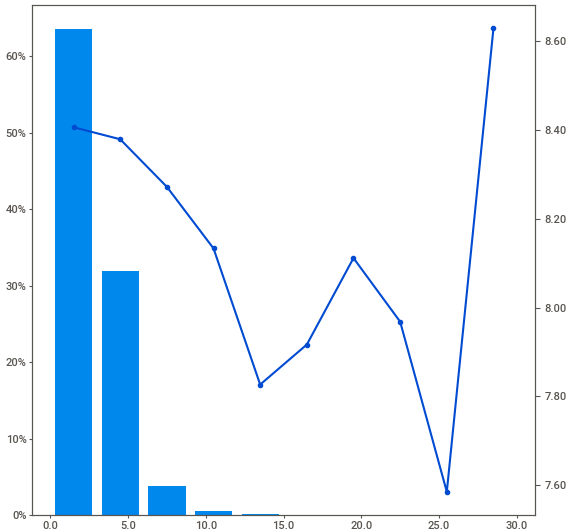
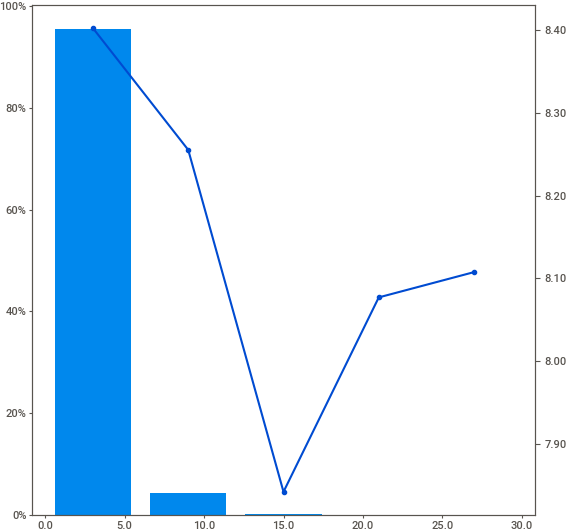
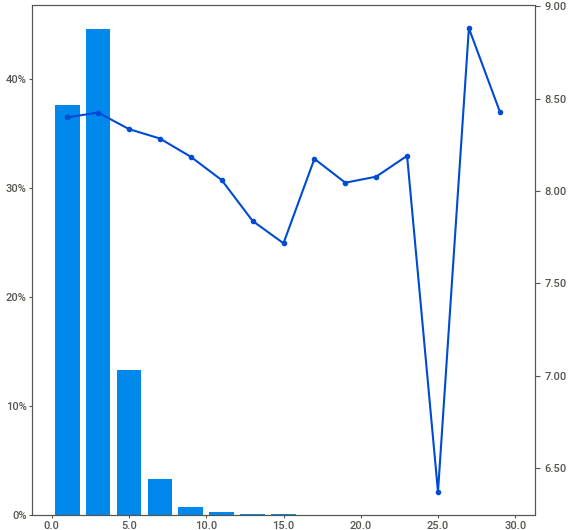
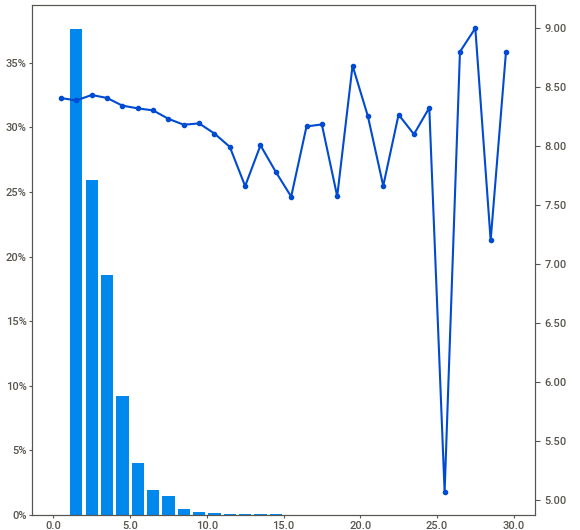
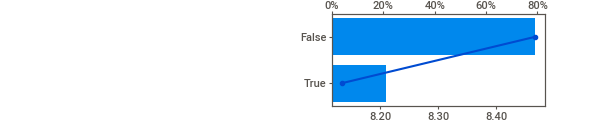
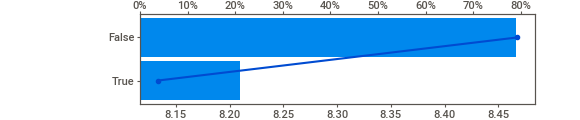
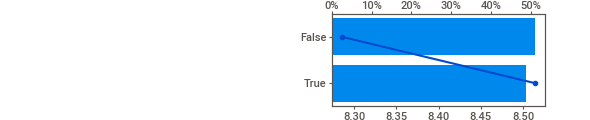
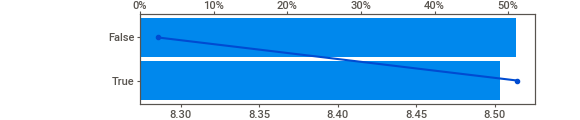
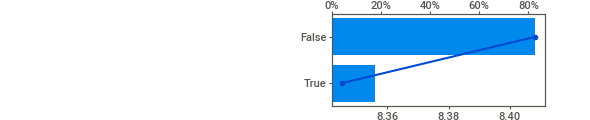
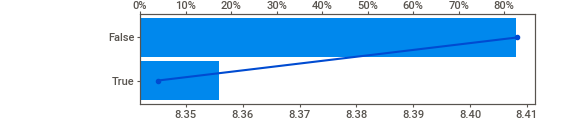
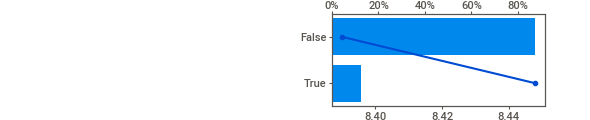
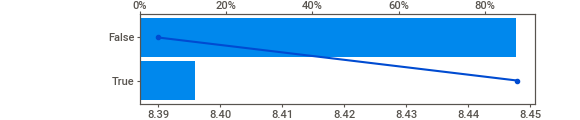
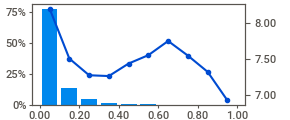
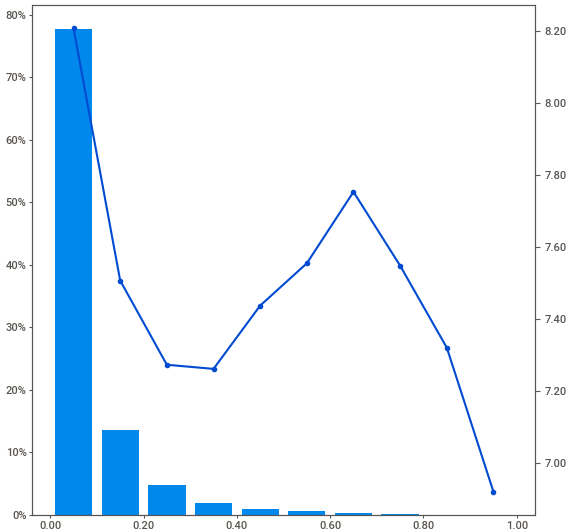
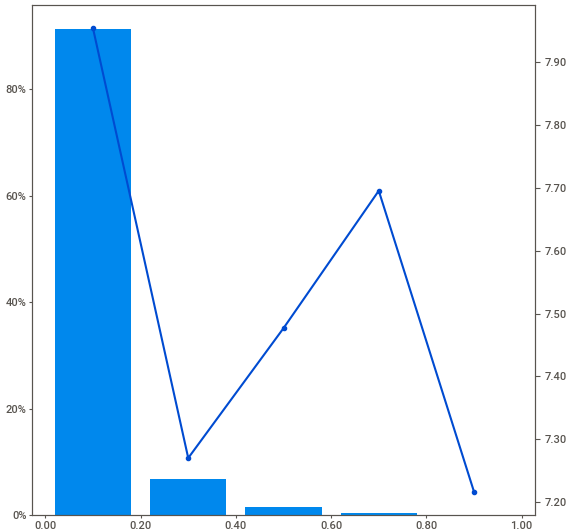
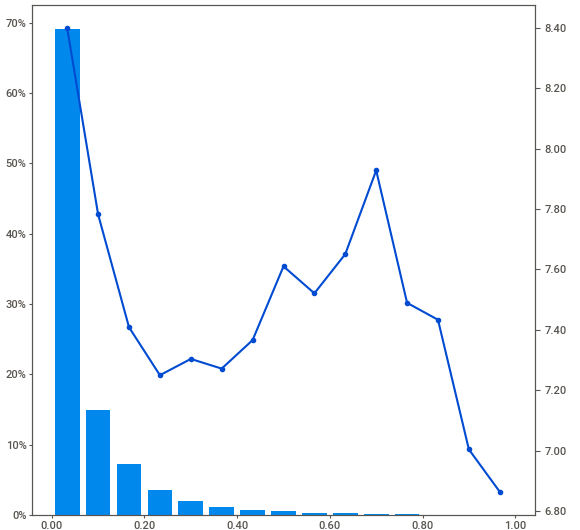
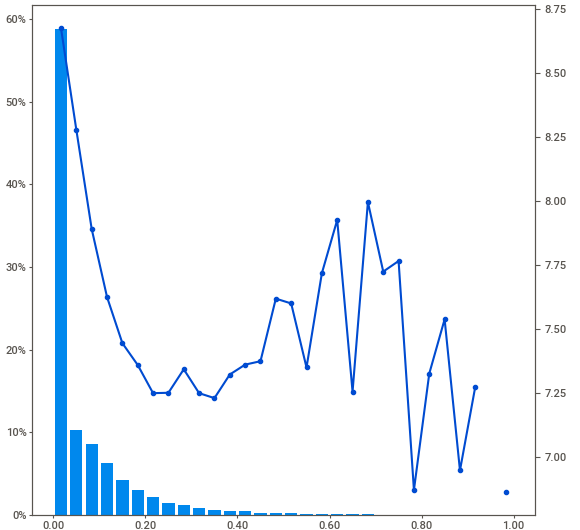
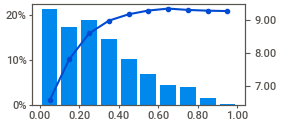
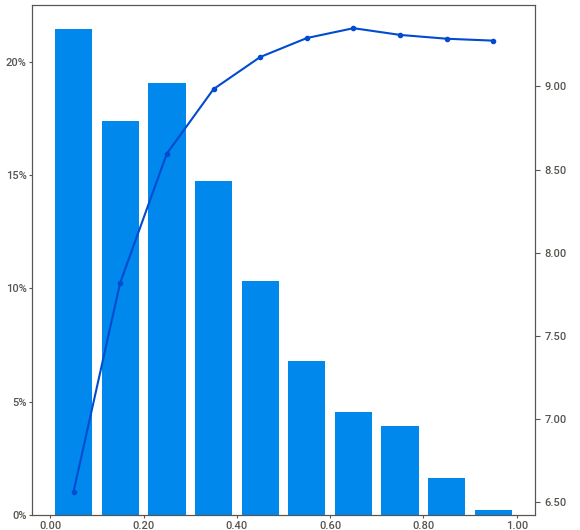
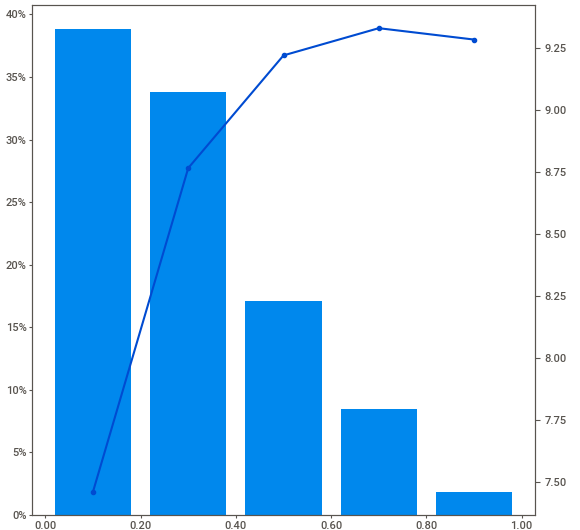
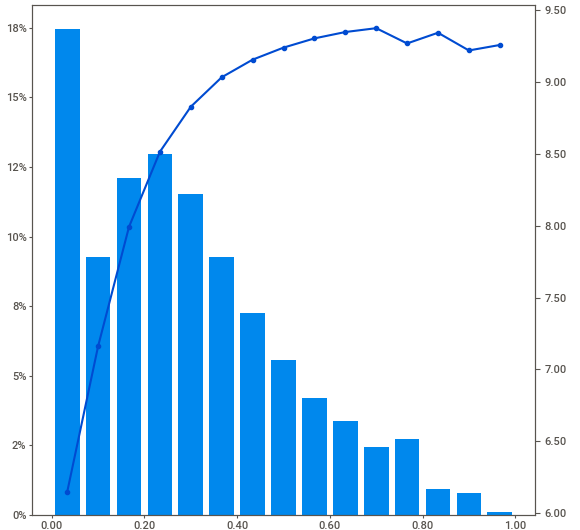
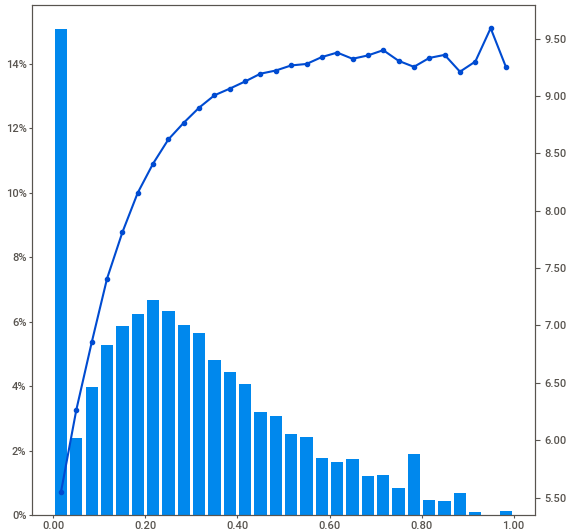
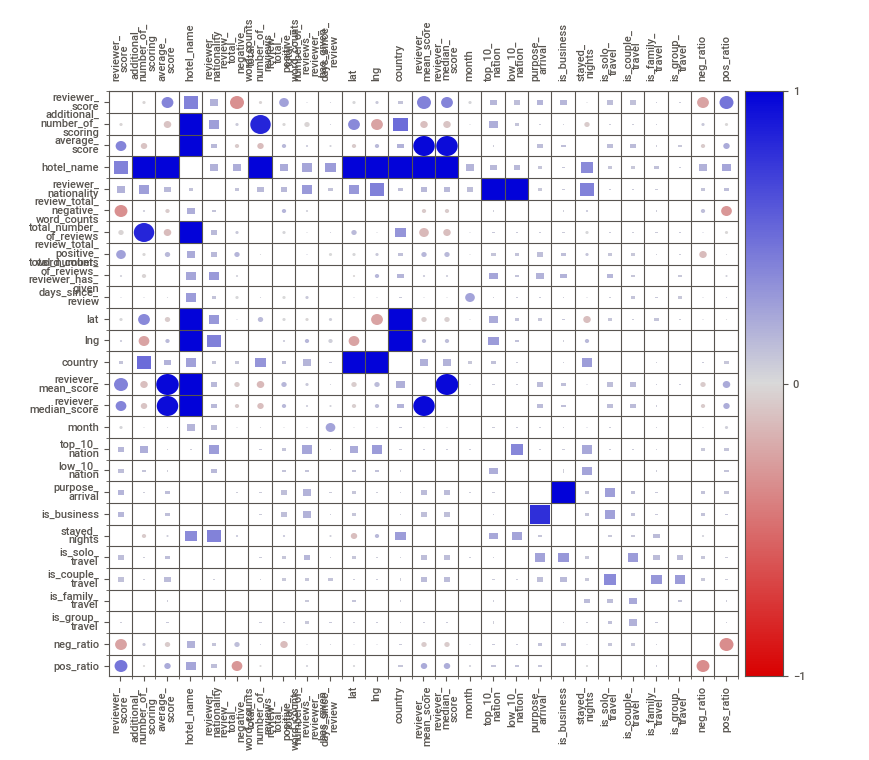
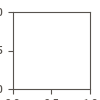

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


In [65]:
# ====================================================
os.environ['COMET_AUTO_LOG_DISABLE']='True'
# ====================================================
report.show_notebook(h=700, w=1100, layout='vertical')
os.environ['COMET_AUTO_LOG_DISABLE']='False'
# ====================================================

**Выводы из отчета**
  -  Парни с восточного побережья сенайского полуострова - лидеры по низким рейтингам. Парням с Турции то же что то не по феншую.
  -  Лидеры по высоким рейтингам - гости из Штатов, Канады, Австралии и, кто бы мог пудумать, парни из Израиля. Вывод об этом очевиден.
  -  "Туманный Альбион" лидер по низкому среднему рейтингу. Эвоно как.
  -  "Britannia International Hotel Canary Wharf" - первый из топов отелей с низким средним рейтингом. Наверное его стоит занести отдельным индикатором, он явно это заслужил.
  -  "Intercontinental London The O2" - заметно выделяется с высоким средним рейтингом. Можно по обоим рискнуть, но есть опасность переобучения.
  -  Странные два пика среднего рейтинга по мере устаревания даты отзывов. Какой то годовой цикл, возможно. Нужно капать глубже.
  -  Предсказуемое снижение среднего рейтинга у одиночных постояльцев. Они еще и коррелируют с бизнес-типом поездки.

In [66]:
# ## Рискнем, интересно же. 
# ## (ПыСы сомнительная вещь, всего два отеля из полторы тысячи. отказался от этой идеи)
# hotels_name = ['Britannia International Hotel Canary Wharf']
# hotels_df['down_score_leader'] = hotels_df['hotel_name'].apply(lambda x : 1 if x in hotels_name else 0)

In [67]:
# hotels_name = ['Intercontinental London The O2']
# hotels_df['up_score_leader'] = hotels_df['hotel_name'].apply(lambda x : 1 if x in hotels_name else 0)

In [68]:
# Плавно переходим к ML и подбору/перебору и оценки признаков

# Блок ML

## Подключение системы логирования

In [69]:
# раскоментируйте это если вам нужен трэкинг этапов Comet|ML
## ==========================================================
COMET_LOG_ENABLE=True
## ==========================================================
def delete_project(do=False):
    """Удаляет проект на comet.ml"""
    if not do:
        return
    api = comet.API()
    try:
        result = api.delete_project(
            workspace=WORKSPACE, 
            project_name=PROJECT,
            delete_experiments=True
        )
        print(result)
    except Exception as e:
        print(e)

EXPERIMENT_PARAMS = dict(workspace=WORKSPACE, project_name=PROJECT, 
    auto_output_logging="default", display_summary_level=1, 
    log_code=False, log_graph=False, auto_param_logging=False, 
    log_git_metadata=False, log_git_patch=False, 
    auto_metric_logging=False, auto_log_co2=False,
    log_env_details=False,# log_env_host=False
    # log_env_gpu=False, log_env_cpu=False,
)
##delete_project(True)

In [70]:
### Создаем comet.ml проект
## api_key in /<USERHOMEDIR>/.comet.config
if COMET_LOG_ENABLE:
    ## Удаляем проект и эксперименты для начала с "чистого листа"
    delete_project(True)

    api = comet.API()
    project = api.create_project(
        workspace=WORKSPACE, 
        project_name=PROJECT, 
        project_description='SFDS ML Workflow', 
        public=True,    
    )
    print('project:', project)
    #time.sleep(1)

    project_notes="""
    <a href="https://skillfactory.ru/">
        <img src="https://raw.githubusercontent.com/dhegl/sf_ds/64c052f95af5d042844ed56f765c2cbb566d1680/main/static/medium.svg" alt="Онлайн-школа SkillFactory" width="160px" align="right" />
    </a>
    # **SFDS EDA+TRAINING MODEL LEARNING PROJECT**  
    -  create learning project for model training experiments
    -  logging all workflow phases 

    |Begin version|State|
    |---|--:|
    |0.0.12|3|
    """
    results = api.set_project_notes(
        workspace=WORKSPACE, 
        project_name=PROJECT, 
        notes=project_notes
    )
    print('Send result', results)

<Response [200]>
project: {'projectId': 'd191d501c69a46b981bd949b6ea6a6f6'}
Send result {'msg': 'Saved', 'code': 200, 'data': None, 'sdk_error_code': 0}


In [71]:
RANDOM_SEED = 4242
TARGET = 'reviewer_score'
# Начинаем трекинг лога обучения с созданием эксперемента в comet.ML
exp_version = [1,0]
exp_log = {}
# По одному эксперементу на подбор признаков
# Первым идет бэйзлаин
hotels_df.head(3)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   

   additional_number_of_scoring review_date  average_score  \
0                           581  2016-02-19            8.4   
1                           299  2017-01-12            8.3   
2                            32  2016-10-18            8.9   

                          hotel_name reviewer_nationality  \
0                 The May Fair Hotel      United Kingdom    
1    Mercure London Bloomsbury Hotel      United Kingdom    
2  Legend Saint Germain by Elegancia               China    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   

   total_number_of_reviews      positive_review  ...  low_10_nation  \
0                     1994   Staff were amazing  ...              0   
1                     1361             location  ...              0   
2                      406          No Positive  ...              0   

   purpose_arrival  is_business stayed_nights  is_solo_travel  \
0          Leisure            0             2           False   
1         Business            1             1           False   
2          Leisure            0             3            True   

   is_couple_travel  is_family_travel is_group_travel  neg_ratio  pos_ratio  
0              True             False           False      0.000      0.559  
1              True             False           False      0.608      0.000  
2             False             False           False      0.663      0.000  

[3 rows x 32 columns]

## **Experiment 1.** (baseline+minmax)

### Подготовка к обучению

In [72]:
exp_version[1] += 1
exp_name = 'baseline'
if COMET_LOG_ENABLE:
    experiment = comet.Experiment(**EXPERIMENT_PARAMS)
    experiment.set_name(exp_name)
    experiment.add_tag('learning {}.{}'.format(exp_version[0], exp_version[1]))

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Python\\learning\\eda.kaggle\\project-3-kaggle\\code' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/dheglsfds/sfds-project-3/86462d90bd474f5eaefafb7fec38c14c



In [73]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386496 non-null  category      
 1   additional_number_of_scoring                386496 non-null  int64         
 2   review_date                                 386496 non-null  datetime64[ns]
 3   average_score                               386496 non-null  float64       
 4   hotel_name                                  386496 non-null  category      
 5   reviewer_nationality                        386496 non-null  category      
 6   negative_review                             386496 non-null  object        
 7   review_total_negative_word_counts           386496 non-null  int64         
 8   total_number_of_reviews                     386496 non-null  int64        

In [74]:
train_columns = []
train_num_columns = [
    'average_score',
    # 'reviever_mean_score',
    # 'reviever_median_score',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'total_number_of_reviews',
]
train_columns.extend(train_num_columns)
hotels_df[train_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 5 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386496 non-null  float64
 1   review_total_negative_word_counts           386496 non-null  int64  
 2   review_total_positive_word_counts           386496 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 4   total_number_of_reviews                     386496 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 25.8 MB


In [75]:
train_bin_columns = [
    # 'is_business',
    # 'is_solo_travel',
    # 'is_couple_travel',
    # 'is_family_travel',
    #'top_10_nation',
    #'low_10_nation',
]

train_cat_columns = [
    # 'reviewer_nationality',
    # 'month',
    # 'country',
]
train_columns.extend(train_cat_columns+train_bin_columns)
hotels_df[train_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 5 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386496 non-null  float64
 1   review_total_negative_word_counts           386496 non-null  int64  
 2   review_total_positive_word_counts           386496 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 4   total_number_of_reviews                     386496 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 25.8 MB


### Формирование тренировочного датасета

In [76]:
## Здесь могут быть ньюансы, выделим отдельным подблоком
train_data = hotels_df[train_columns+[TARGET]].copy()

### Нормализация, стандартизация и кодирование признаков

In [77]:
## Все булевые признаки переводим в числовые [0,1]
## convert bool fields to int
for column in train_data.columns:
    if train_data[column].dtype == 'bool':
        train_data[column] = train_data[column].astype(int)

In [78]:
## Binary Encode
# encode_cols=['reviewer_nationality']
# ce_binary = ce.BinaryEncoder(cols=encode_cols)
# train_data = ce_binary.fit_transform(train_data)

In [79]:
## One Hot Encode
#encode_cols=['month', 'country']
encode_cols=train_cat_columns
ce_onehot = ce.OneHotEncoder(cols=encode_cols, use_cat_names=True)
train_data = ce_onehot.fit_transform(train_data)

In [80]:
# Шкалирование числовых признаков
from sklearn.preprocessing import MinMaxScaler
_scaler = MinMaxScaler()
_scaler.fit(train_data[train_num_columns])
train_data[train_num_columns] = _scaler.fit_transform(train_data[train_num_columns])

In [81]:
# from sklearn.preprocessing import StandardScaler
# _scaler = StandardScaler()
# _scaler.fit(train_data)
# train_data[train_columns] = _scaler.fit_transform(train_data)

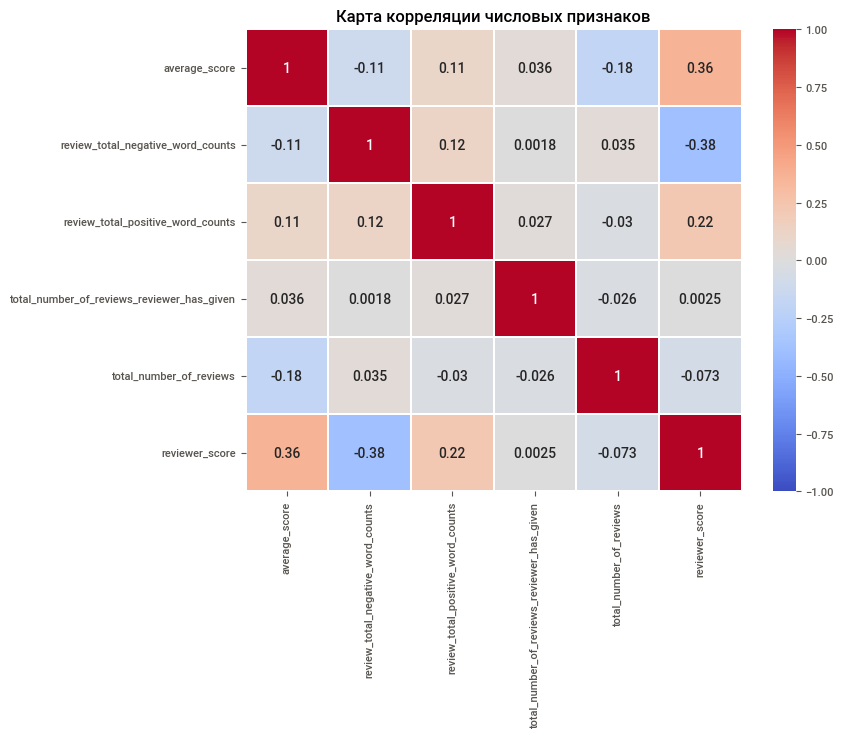

In [82]:
#pearson, spearman, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Карта корреляции числовых признаков')
matrix_corr = train_data[train_num_columns+[TARGET]].corr(method='pearson')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='pearson_correlation', step=exp_version[1]);

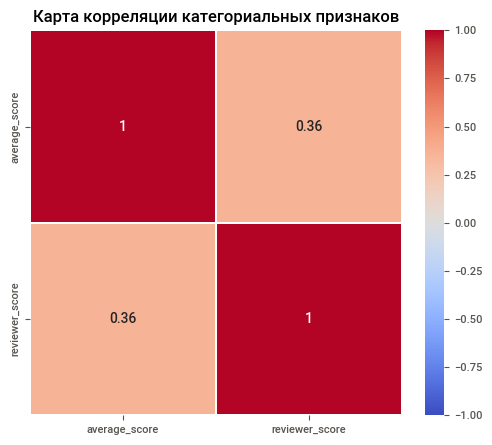

In [83]:
#pearson, spearman, kendall
num_as_cat_cols = [
    'average_score',
    # 'reviever_mean_score',
    # 'reviever_median_score',
] + [x for x in train_data.columns if train_data[x].nunique()==2]

heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Карта корреляции категориальных признаков')
matrix_corr = train_data[num_as_cat_cols+[TARGET]].corr(method='spearman').round(2)
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='spearman_correlation', step=exp_version[1]);

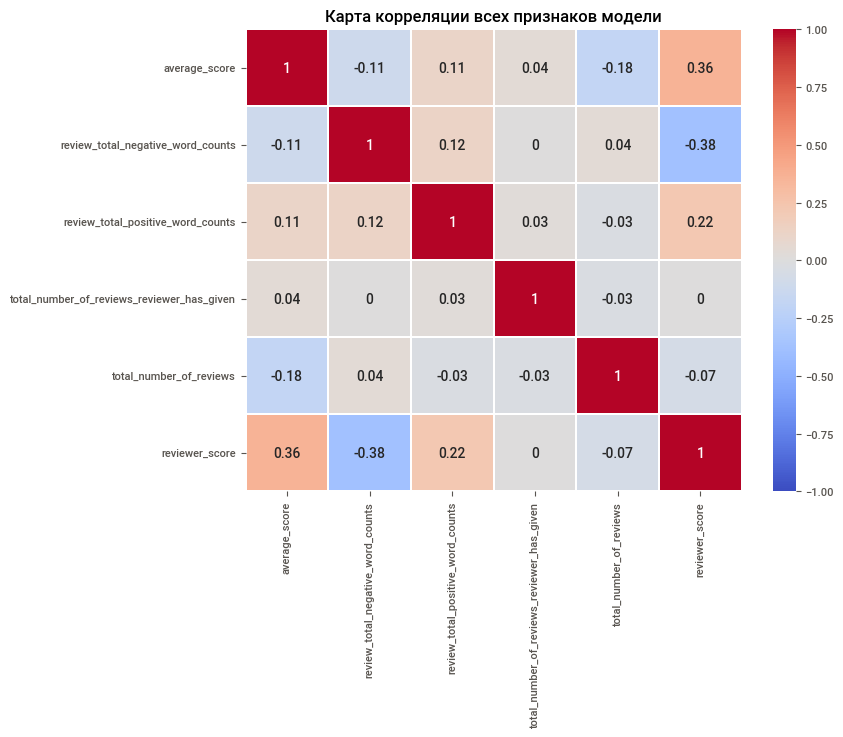

In [84]:
#pearson, spearman, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Карта корреляции всех признаков модели')
matrix_corr = train_data.corr(method='pearson').round(2)
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='all_predict_corr', step=exp_version[1]);

In [85]:
train_data.head(3)

average_score  review_total_negative_word_counts  \
0       0.695652                           0.007353   
1       0.673913                           0.007353   
2       0.804348                           0.014706   

   review_total_positive_word_counts  \
0                           0.010127   
1                           0.005063   
2                           0.000000   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                    0.016949                 0.117339   
1                                    0.036723                 0.079269   
2                                    0.036723                 0.021832   

   reviewer_score  
0            10.0  
1             6.3  
2             7.5

### Обучение модели

In [86]:
X = train_data.drop([TARGET], axis=1)
y = train_data[TARGET].values

#### Оценка признаков на значимость (anova, хи-квадрат)

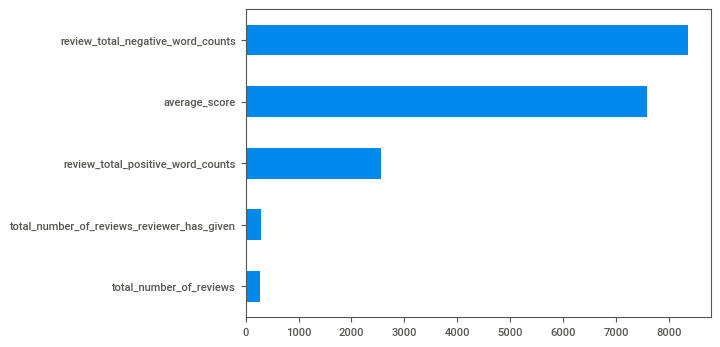

In [87]:
## непрерывные признаки 
num_cols = [x for x in X.columns if X[x].nunique()>2]

if num_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import f_classif # anova
    imp_num = pd.Series(f_classif(X[num_cols], y_)[0], index = num_cols)
    imp_num.sort_values(inplace = True)
    imp_num.plot(kind = 'barh');

In [88]:
# категориальные признаки (по сути все уже бинарные)
cat_cols = [x for x in X.columns if X[x].nunique()==2]

if cat_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import chi2 # хи-квадрат
    imp_cat = pd.Series(chi2(X[cat_cols], y_)[0], index=cat_cols)
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(kind='barh');

In [89]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [90]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
params = dict(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1,
    random_state=RANDOM_SEED)

model = RandomForestRegressor(**params)

# логируем гиперпараметры модели
params['model'] ='RandomForestRegressor'
params['target'] = TARGET
params['features_count'] = len(X.columns)
params['features_name']  = X.columns.to_list()
if COMET_LOG_ENABLE:
    experiment.log_parameters(parameters=params, step=exp_version[1]) #, step=1, prefix='comet_'
#display(params)

In [91]:
%%time
start_learn = time.time()
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)
#
learning_time = time.time() - start_learn

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s


CPU times: total: 2min 27s
Wall time: 43 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.9s finished


In [92]:
%%time
start_predict = time.time()
# Используем обученную модель для предсказания рейтинга
y_pred = model.predict(X_test)
#
predict_time = time.time() - start_predict

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


CPU times: total: 5.37 s
Wall time: 1.58 s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [93]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
model_metrics = {
    'MAPE': metrics.mean_absolute_percentage_error(y_test, y_pred),
    'features_count': len(X.columns),
    'learning_time': learning_time,
    # 'predict_time': predict_time,
}

# Наше Все
print('-------------------------')
print('MAPE:', model_metrics['MAPE'])
print('-------------------------')

# MAPE: 0.14155952662243707
# MAPE: 0.13839899541270664
# MAPE: 0.13790204359287050

-------------------------
MAPE: 0.14155952662243704
-------------------------


In [94]:
# def mean_absolute_percentage_error(y_test, y_pred):
#     return np.mean(np.abs((y_test - y_pred) / y_test))
# print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

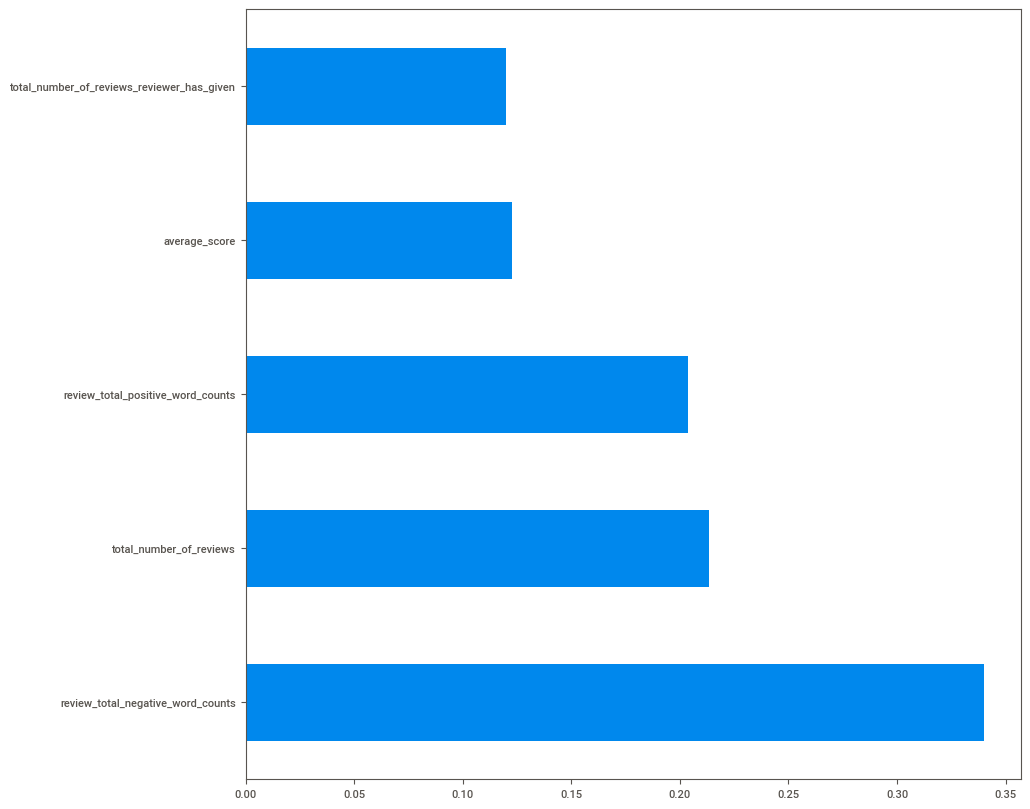

In [95]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
fig, ax = plt.subplots(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',ax=ax)

if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='feature_importances', step=exp_version[1]);

In [96]:
# Сохраняем метрики, закрываем логирование эксперимента
if COMET_LOG_ENABLE:
    experiment.log_metrics(model_metrics, step=exp_version[1])
    experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dheglsfds/sfds-project-3/86462d90bd474f5eaefafb7fec38c14c
COMET INFO:   Metrics:
COMET INFO:     MAPE           : 0.14155952662243704
COMET INFO:     features_count : 5
COMET INFO:     learning_time  : 43.04143762588501
COMET INFO:   Others:
COMET INFO:     Name : baseline
COMET INFO:   Parameters:
COMET INFO:     features_count : 5
COMET INFO:     features_name  : ['average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews']
COMET INFO:     model          : RandomForestRegressor
COMET INFO:     n_estimators   : 100
COMET INFO:

### Результаты

In [97]:
exp_log['{}.{}'.format(exp_version[0], exp_version[1])] = {'name':exp_name,'params':params, 'metrics': model_metrics}    
# Накопительный итог
for v, exp in exp_log.items():
    print(exp['name'], v)
    print('  mape:', round(exp['metrics']['MAPE'], 6))
    print('  feature count:', exp['params']['features_count'])
    print('  leaning time:', round(exp['metrics']['learning_time'], 2), 's')

baseline 1.1
  mape: 0.14156
  feature count: 5
  leaning time: 43.04 s


## Experiment 2. (extend features)

### Подготовка к обучению

In [98]:
exp_version[1] += 1
exp_name = 'exchenge'
if COMET_LOG_ENABLE:
    experiment = comet.Experiment(**EXPERIMENT_PARAMS)
    experiment.set_name(exp_name)
    experiment.add_tag('learning {}.{}'.format(exp_version[0], exp_version[1]))

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Python\\learning\\eda.kaggle\\project-3-kaggle\\code' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/dheglsfds/sfds-project-3/12b7f79a208141798649a391053094a9



In [99]:
train_columns = []
train_num_columns = [
    # 'average_score',
    'reviever_mean_score',
    # 'reviever_median_score',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'total_number_of_reviews',
    #'additional_number_of_scoring',
    # 'lat',
    # 'lng',
    'stayed_nights',
]
train_columns.extend(train_num_columns)

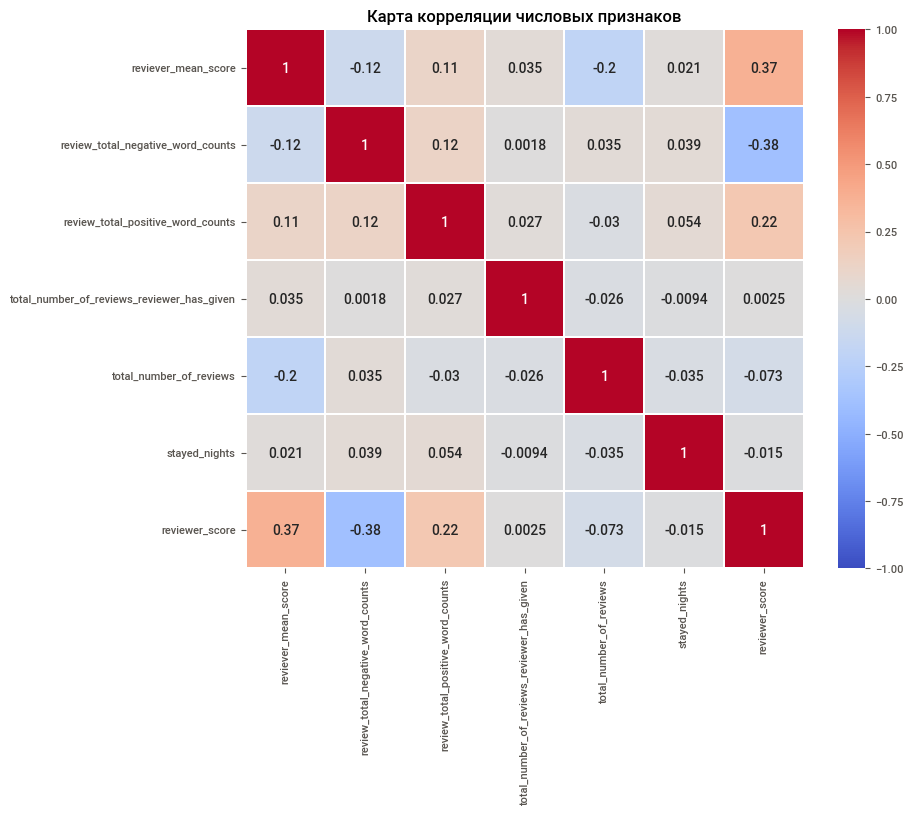

In [100]:
#pearson, pearson, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title('Карта корреляции числовых признаков')
matrix_corr = hotels_df[train_num_columns+[TARGET]].corr(method='pearson')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='pearson_correlation', step=exp_version[1]);

In [101]:
#hotels_df.
train_bin_columns = [
    'is_solo_travel',
    'is_couple_travel',
    'is_family_travel',
    'is_group_travel',
    'is_business',
    'top_10_nation',
    'low_10_nation',
]

train_cat_columns = [
    'month',
    'country',
    # 'reviewer_nationality',
]

train_columns.extend(train_bin_columns+train_cat_columns)
hotels_df[train_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviever_mean_score                         386496 non-null  float64
 1   review_total_negative_word_counts           386496 non-null  int64  
 2   review_total_positive_word_counts           386496 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 4   total_number_of_reviews                     386496 non-null  int64  
 5   stayed_nights                               386496 non-null  int32  
 6   is_solo_travel                              386496 non-null  bool   
 7   is_couple_travel                            386496 non-null  bool   
 8   is_family_travel                            386496 non-null  bool   
 9   is_group_travel                             386496 non-null  bool   
 

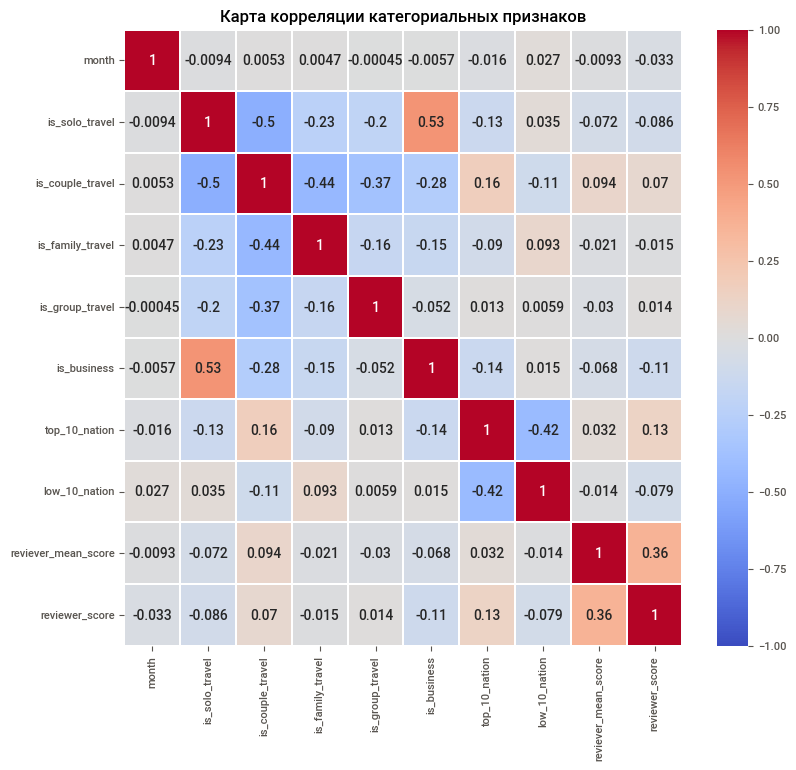

In [102]:
#pearson, spearman, kendall
num_as_cat_cols = [
    # 'average_score',
    'reviever_mean_score',
    # 'reviever_median_score',
]
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(9, 8))
ax.set_title('Карта корреляции категориальных признаков')
matrix_corr = hotels_df[train_cat_columns+train_bin_columns+num_as_cat_cols+[TARGET]].corr(method='spearman')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='spearman_correlation', step=exp_version[1]);

### Формирование тренировочного датасета

In [103]:
# Здесь могут быть ньюансы, выделим отдельным подблоком
train_data = hotels_df[train_columns + [TARGET]].copy()

### Нормализация, стандартизация и кодирование признаков

In [104]:
# Все булевые признаки переводим в числовые [0,1]

# convert bool fields to int
for column in train_data.columns:
    if train_data[column].dtype == 'bool':
        train_data[column] = train_data[column].astype(int)

In [105]:
# ## Binary Encode
# encode_cols=['reviewer_nationality']
# ce_binary = ce.BinaryEncoder(cols=encode_cols)
# train_data = ce_binary.fit_transform(train_data)

In [106]:
## One Hot Encode
encode_cols=['month', 'country'] # 
ce_onehot = ce.OneHotEncoder(cols=encode_cols, use_cat_names=True)
train_data = ce_onehot.fit_transform(train_data)
train_data.head(3)

reviever_mean_score  review_total_negative_word_counts  \
0                  8.3                                  3   
1                  8.4                                  3   
2                  9.0                                  6   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                           7                     1994   
1                                          14                     1361   
2                                          14                      406   

   stayed_nights  is_solo_travel  is_couple_travel  is_family_travel  \
0              2               0                 1                 0   
1              1               0                 1                 0   
2              3               1                 0                 0   

   is_group_travel  ...  month_7.0  month_4.0  month_8.0  \
0                0  ...          0          0          0   
1                0  ...          0          0          0   
2                0  ...          0          0          0   

   country_United Kingdom  country_France  country_Netherlands  country_Italy  \
0                       1               0                    0              0   
1                       1               0                    0              0   
2                       0               1                    0              0   

   country_Austria  country_Spain  reviewer_score  
0                0              0            10.0  
1                0              0             6.3  
2                0              0             7.5  

[3 rows x 32 columns]

In [107]:
## Лишее это, не помогло
# from sklearn.preprocessing import RobustScaler
# scaled_cols = ['review_total_positive_word_counts', 'review_total_negative_word_counts']
# _scaler = RobustScaler()
# _scaler.fit(train_data[scaled_cols])
# train_data[scaled_cols] = _scaler.fit_transform(train_data[scaled_cols])

In [108]:
from sklearn.preprocessing import MinMaxScaler
_scaler = MinMaxScaler()
_scaler.fit(train_data[train_num_columns])
train_data[train_num_columns] = _scaler.fit_transform(train_data[train_num_columns])
train_data.describe().round(2)

reviever_mean_score  review_total_negative_word_counts  \
count            386496.00                          386496.00   
mean                  0.72                               0.05   
std                   0.13                               0.07   
min                   0.00                               0.00   
25%                   0.65                               0.00   
50%                   0.74                               0.02   
75%                   0.80                               0.06   
max                   1.00                               1.00   

       review_total_positive_word_counts  \
count                          386496.00   
mean                                0.05   
std                                 0.05   
min                                 0.00   
25%                                 0.01   
50%                                 0.03   
75%                                 0.06   
max                                 1.00   

       total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
count                                   386496.00                386496.00   
mean                                         0.02                     0.16   
std                                          0.03                     0.14   
min                                          0.00                     0.00   
25%                                          0.00                     0.07   
50%                                          0.01                     0.13   
75%                                          0.02                     0.22   
max                                          1.00                     1.00   

       stayed_nights  is_solo_travel  is_couple_travel  is_family_travel  \
count      386496.00       386496.00         386496.00         386496.00   
mean            0.08            0.21              0.49              0.17   
std             0.05            0.41              0.50              0.38   
min             0.00            0.00              0.00              0.00   
25%             0.03            0.00              0.00              0.00   
50%             0.07            0.00              0.00              0.00   
75%             0.10            0.00              1.00              0.00   
max             1.00            1.00              1.00              1.00   

       is_group_travel  ...  month_7.0  month_4.0  month_8.0  \
count        386496.00  ...  386496.00  386496.00   386496.0   
mean              0.13  ...       0.10       0.08        0.1   
std               0.33  ...       0.29       0.28        0.3   
min               0.00  ...       0.00       0.00        0.0   
25%               0.00  ...       0.00       0.00        0.0   
50%               0.00  ...       0.00       0.00        0.0   
75%               0.00  ...       0.00       0.00        0.0   
max               1.00  ...       1.00       1.00        1.0   

       country_United Kingdom  country_France  country_Netherlands  \
count               386496.00       386496.00            386496.00   
mean                     0.51            0.12                 0.11   
std                      0.50            0.32                 0.31   
min                      0.00            0.00                 0.00   
25%                      0.00            0.00                 0.00   
50%                      1.00            0.00                 0.00   
75%                      1.00            0.00                 0.00   
max                      1.00            1.00                 1.00   

       country_Italy  country_Austria  country_Spain  reviewer_score  
count      386496.00        386496.00      386496.00       386496.00  
mean            0.07             0.08           0.12            8.40  
std             0.26             0.26           0.32            1.64  
min             0.00             0.00           0.00            2.50  
25%             0.00             0.00           0.00            7.50  
50

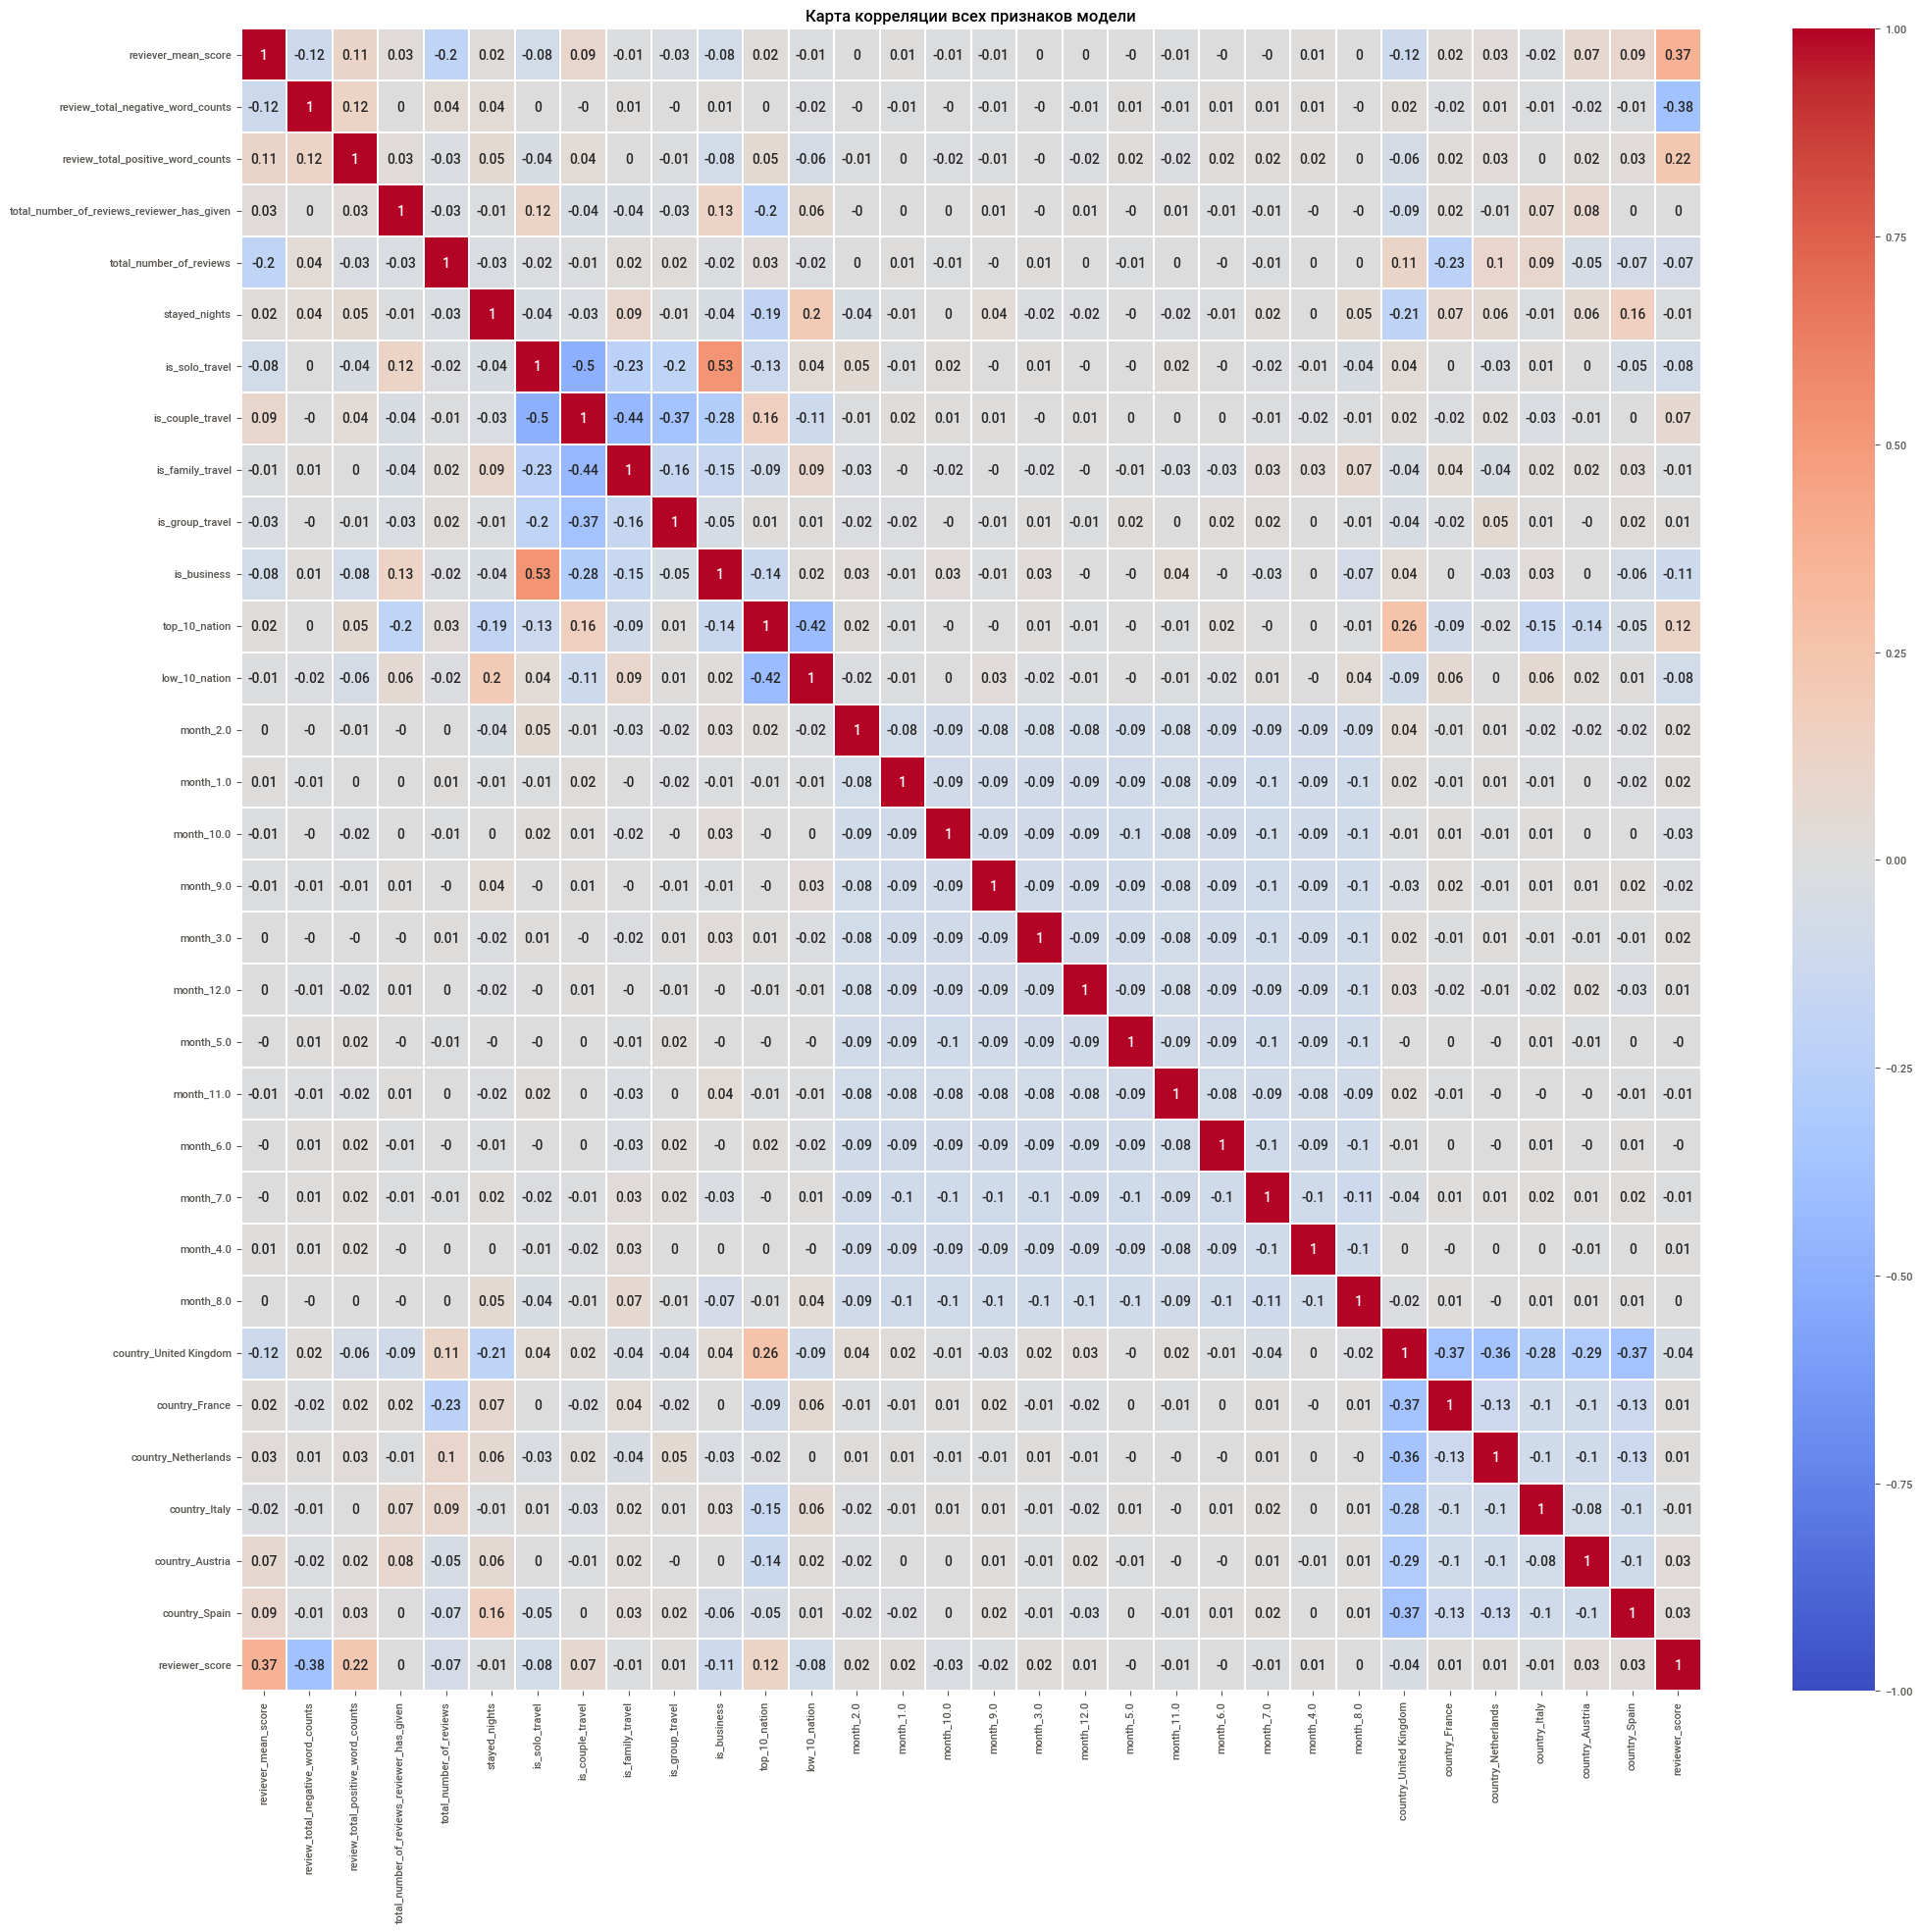

In [109]:
#pearson, spearman, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(24, 22))
ax.set_title('Карта корреляции всех признаков модели')
matrix_corr = train_data.corr(method='pearson').round(2)
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='all_predict_corr', step=exp_version[1]);

### Обучение модели

In [110]:
X = train_data.drop([TARGET], axis=1)
y = train_data[TARGET].values

#### Оценка признаков на значимость (anova, хи-квадрат)

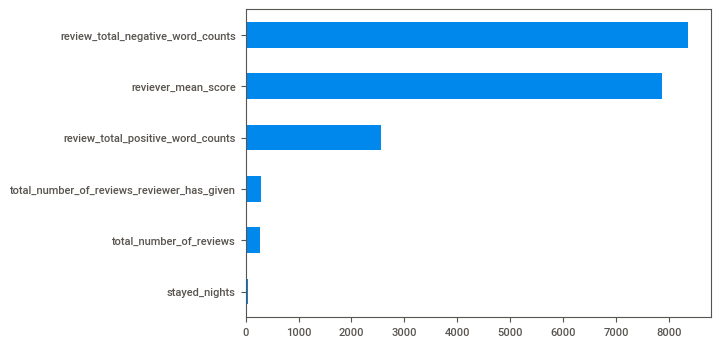

In [111]:
## непрерывные признаки
num_cols = [x for x in X.columns if X[x].nunique()>2]

if num_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import f_classif # anova
    imp_num = pd.Series(f_classif(X[num_cols], y_)[0], index = num_cols)
    imp_num.sort_values(inplace = True)
    imp_num.plot(kind = 'barh');

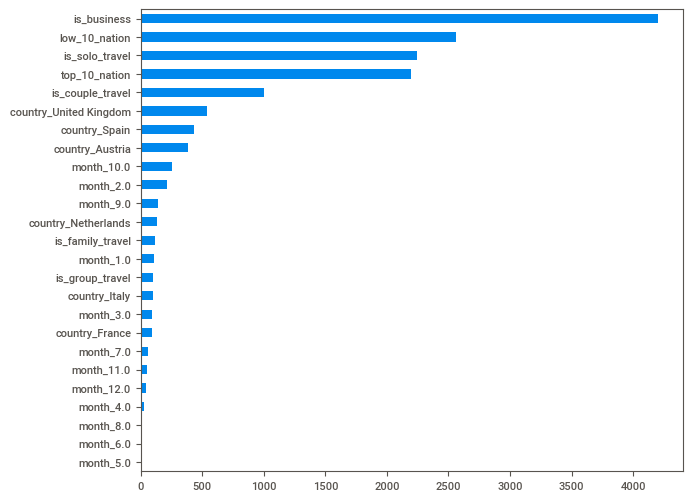

In [112]:
# категориальные признаки
cat_cols = [x for x in X.columns if X[x].nunique()==2]

if cat_cols:
    y_ = y.astype('int')

    from sklearn.feature_selection import chi2 # хи-квадрат
    imp_cat = pd.Series(chi2(X[cat_cols], y_)[0], index=cat_cols)
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(kind='barh', figsize=(7,6));

In [113]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [114]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
params = dict(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1,
    random_state=RANDOM_SEED)

model = RandomForestRegressor(**params)

# логируем гиперпараметры модели
params['model'] ='RandomForestRegressor'
params['target'] = TARGET
params['features_count'] = len(X.columns)
params['features_name']  = X.columns.to_list()
if COMET_LOG_ENABLE:
    experiment.log_parameters(parameters=params, step=exp_version[1]) #, step=1, prefix='comet_'
#display(params)

In [115]:
%%time
start_learn = time.time()

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

learning_time = time.time() - start_learn

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.0s


CPU times: total: 7min 3s
Wall time: 1min 55s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


In [116]:
%%time
start_predict = time.time()
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

predict_time = time.time() - start_predict

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


CPU times: total: 5.83 s
Wall time: 1.69 s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [117]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
model_metrics = {
    'MAPE': metrics.mean_absolute_percentage_error(y_test, y_pred),
    'features_count': len(X.columns),
    'learning_time': learning_time,
    # 'predict_time': predict_time,
}

# Наше Все
print('-------------------------')
print('MAPE:', model_metrics['MAPE'])
print('-------------------------')

# MAPE: 0.13563398464623694

-------------------------
MAPE: 0.13527112654125675
-------------------------


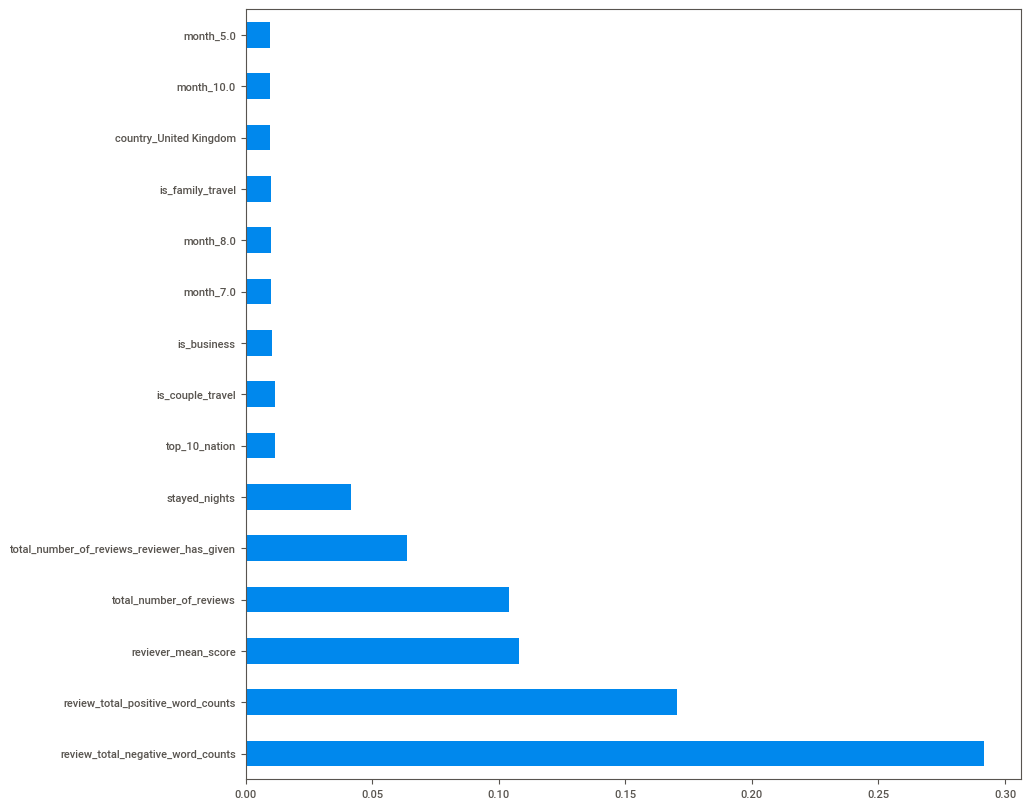

In [118]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
fig, ax = plt.subplots(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',ax=ax);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='feature_importances', step=exp_version[1]);

In [119]:
# Сохраняем метрики, закрываем логирование эксперимента
if COMET_LOG_ENABLE:
    experiment.log_metrics(model_metrics, step=exp_version[1])
    experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dheglsfds/sfds-project-3/12b7f79a208141798649a391053094a9
COMET INFO:   Metrics:
COMET INFO:     MAPE           : 0.13527112654125675
COMET INFO:     features_count : 31
COMET INFO:     learning_time  : 115.07357382774353
COMET INFO:   Others:
COMET INFO:     Name : exchenge
COMET INFO:   Parameters:
COMET INFO:     features_count : 31
COMET INFO:     features_name  : ['reviever_mean_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews', 'stayed_nights', 'is_solo_travel', 'is_couple_travel', 'is_family_travel', 'is_group_travel', 

### Результаты

In [120]:
exp_log['{}.{}'.format(exp_version[0], exp_version[1])] = {'name':exp_name,'params':params, 'metrics': model_metrics}    
# Накопительный итог
for v, exp in exp_log.items():
    print(exp['name'], v)
    print('  mape:', round(exp['metrics']['MAPE'], 6))
    print('  feature count:', exp['params']['features_count'])
    print('  leaning time:', round(exp['metrics']['learning_time'], 2), 's')

baseline 1.1
  mape: 0.14156
  feature count: 5
  leaning time: 43.04 s
exchenge 1.2
  mape: 0.135271
  feature count: 31
  leaning time: 115.07 s


## Experiment 3. (optimal extend features)

### Подготовка к обучению

In [121]:
exp_version[1] += 1
exp_name = 'optimal'
if COMET_LOG_ENABLE:
    experiment = comet.Experiment(**EXPERIMENT_PARAMS)
    experiment.set_name(exp_name)
    experiment.add_tag('learning {}.{}'.format(exp_version[0], exp_version[1]))

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Python\\learning\\eda.kaggle\\project-3-kaggle\\code' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/dheglsfds/sfds-project-3/1f1ce83817474707a6cb736c7ceb693c



In [122]:
train_columns = []
train_num_columns = [
    'average_score',
    # 'reviever_mean_score',
    # 'reviever_median_score',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'total_number_of_reviews',
    # 'additional_number_of_scoring',
    'lat',
    'lng',
    'stayed_nights',
    'neg_ratio', 
    'pos_ratio',
]
train_columns.extend(train_num_columns)

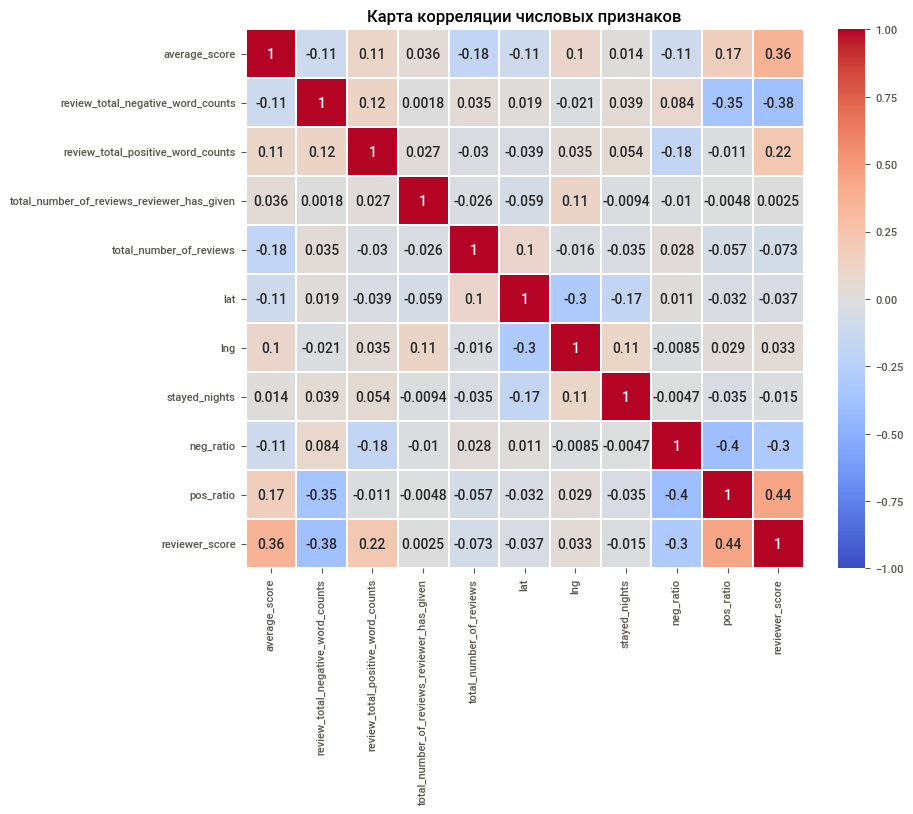

In [123]:
#pearson, pearson, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title('Карта корреляции числовых признаков')
matrix_corr = hotels_df[train_num_columns+[TARGET]].corr(method='pearson')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='pearson_correlation', step=exp_version[1]);

In [124]:
train_bin_columns = [
    'is_business',
    'is_solo_travel',
    'is_couple_travel',
    'is_group_travel',
    'is_family_travel',
    # 'top_10_nation',
    # 'low_10_nation',
]

train_cat_columns = [
    'month',
    # 'country',
    'reviewer_nationality',
]

train_columns.extend(train_cat_columns+train_bin_columns)
hotels_df[train_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               386496 non-null  float64 
 1   review_total_negative_word_counts           386496 non-null  int64   
 2   review_total_positive_word_counts           386496 non-null  int64   
 3   total_number_of_reviews_reviewer_has_given  386496 non-null  int64   
 4   total_number_of_reviews                     386496 non-null  int64   
 5   lat                                         386496 non-null  float64 
 6   lng                                         386496 non-null  float64 
 7   stayed_nights                               386496 non-null  int32   
 8   neg_ratio                                   386496 non-null  float64 
 9   pos_ratio                                   386496 non-null

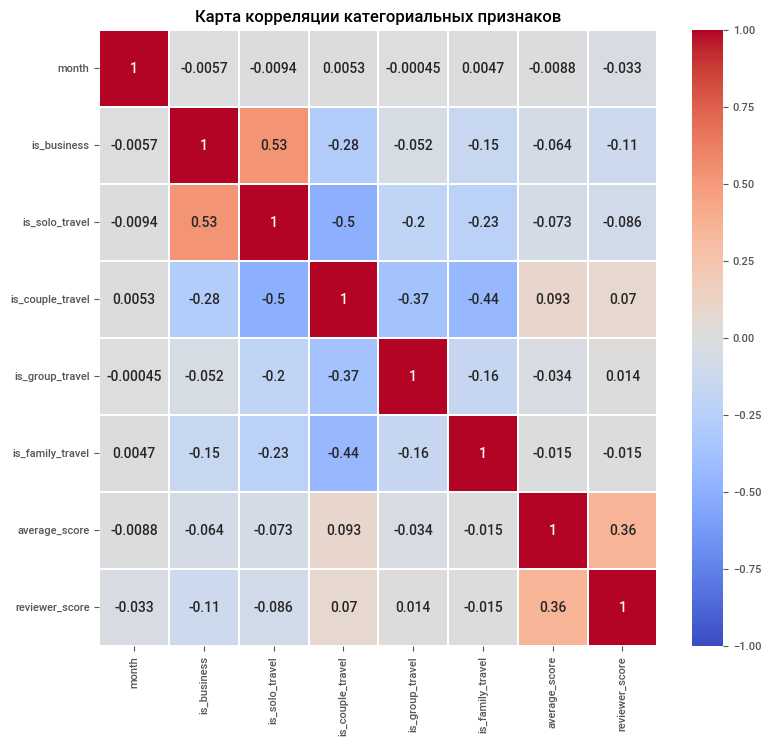

In [125]:
#pearson, spearman, kendall
num_as_cat_cols = [
    'average_score',
    # 'reviever_mean_score',
    # 'reviever_median_score',
]
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(9, 8))
ax.set_title('Карта корреляции категориальных признаков')
matrix_corr = hotels_df[train_cat_columns+train_bin_columns+num_as_cat_cols+[TARGET]].corr(method='spearman')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='spearman_correlation', step=exp_version[1]);

### Формирование тренировочного датасета

In [126]:
# Здесь могут быть ньюансы, выделим отдельным подблоком
train_data = hotels_df[train_columns + [TARGET]].copy()

### Нормализация, стандартизация и кодирование признаков

In [127]:
# Все булевые признаки переводим в числовые [0,1]

# convert bool fields to int
for column in train_data.columns:
    if train_data[column].dtype == 'bool':
        train_data[column] = train_data[column].astype(int)

In [128]:
# Binary Encode
encode_cols=['reviewer_nationality']
ce_binary = ce.BinaryEncoder(cols=encode_cols)
train_data = ce_binary.fit_transform(train_data)

In [129]:
# One Hot Encode
#encode_cols=['month', 'country'] 
encode_cols=['month'] 
ce_onehot = ce.OneHotEncoder(cols=encode_cols, use_cat_names=True)
train_data = ce_onehot.fit_transform(train_data)
train_data.head(5)

average_score  review_total_negative_word_counts  \
0            8.4                                  3   
1            8.3                                  3   
2            8.9                                  6   
3            7.5                                  0   
4            8.5                                  4   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                           7                     1994   
1                                          14                     1361   
2                                          14                      406   
3                                           8                      607   
4                                          10                     7586   

         lat       lng  stayed_nights  neg_ratio  pos_ratio  ...  \
0  51.507894 -0.143671              2      0.000      0.559  ...   
1  51.521009 -0.123097              1      0.608      0.000  ...   
2  48.845377  2.325643              3      0.663      0.000  ...   
3  48.888697  2.394540              1      0.000      0.767  ...   
4  52.385601  4.847060              6      0.073      0.340  ...   

   reviewer_nationality_4  reviewer_nationality_5  reviewer_nationality_6  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       1   
3                       0                       0                       0   
4                       0                       0                       1   

   reviewer_nationality_7  is_business  is_solo_travel  is_couple_travel  \
0                       1            0               0                 1   
1                       1            1               0                 1   
2                       0            0               1                 0   
3                       1            0               1                 0   
4                       1            1               0                 1   

   is_group_travel  is_family_travel  reviewer_score  
0                0                 0            10.0  
1                0                 0             6.3  
2                0                 0             7.5  
3                0                 0            10.0  
4                0                 0             9.6  

[5 rows x 36 columns]

In [130]:
from sklearn.preprocessing import MinMaxScaler
_scaler = MinMaxScaler()
_scaler.fit(train_data[train_num_columns])
train_data[train_num_columns] = _scaler.fit_transform(train_data[train_num_columns])
train_data.describe().round(2)

average_score  review_total_negative_word_counts  \
count      386496.00                          386496.00   
mean            0.70                               0.05   
std             0.12                               0.07   
min             0.00                               0.00   
25%             0.63                               0.00   
50%             0.70                               0.02   
75%             0.78                               0.06   
max             1.00                               1.00   

       review_total_positive_word_counts  \
count                          386496.00   
mean                                0.05   
std                                 0.05   
min                                 0.00   
25%                                 0.01   
50%                                 0.03   
75%                                 0.06   
max                                 1.00   

       total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
count                                   386496.00                386496.00   
mean                                         0.02                     0.16   
std                                          0.03                     0.14   
min                                          0.00                     0.00   
25%                                          0.00                     0.07   
50%                                          0.01                     0.13   
75%                                          0.02                     0.22   
max                                          1.00                     1.00   

             lat        lng  stayed_nights  neg_ratio  pos_ratio  ...  \
count  386496.00  386496.00      386496.00  386496.00  386496.00  ...   
mean        0.73       0.19           0.08       0.06       0.29  ...   
std         0.31       0.28           0.05       0.10       0.22  ...   
min         0.00       0.00           0.00       0.00       0.00  ...   
25%         0.62       0.01           0.03       0.00       0.12  ...   
50%         0.92       0.02           0.07       0.00       0.26  ...   
75%         0.92       0.31           0.10       0.09       0.42  ...   
max         1.00       1.00           1.00       1.00       1.00  ...   

       reviewer_nationality_4  reviewer_nationality_5  reviewer_nationality_6  \
count               386496.00               386496.00               386496.00   
mean                     0.26                    0.32                    0.18   
std                      0.44                    0.47                    0.39   
min                      0.00                    0.00                    0.00   
25%                      0.00                    0.00                    0.00   
50%                      0.00                    0.00                    0.00   
75%                      1.00                    1.00                    0.00   
max                      1.00                    1.00                    1.00   

       reviewer_nationality_7  is_business  is_solo_travel  is_couple_travel  \
count               386496.00    386496.00       386496.00         386496.00   
mean                     0.71         0.16            0.21              0.49   
std                      0.46         0.37            0.41              0.50   
min                      0.00         0.00            0.00              0.00   
25%                      0.00         0.00            0.00              0.00   
50%                      1.00         0.00            0.00              0.00   
75%                      1.00         0.00            0.00              1.00   
max                      1.00         1.00            1.00              1.00   

       is_group_travel  is_family_travel  reviewer_score  
count        386496.00         386496.00       386496.00  
mean              0.13              0.17            8.40  
std               0.33              0.38            1.64  
min               0.00        

In [131]:
# from sklearn.preprocessing import StandardScaler
# _scaler = StandardScaler()
# _scaler.fit(train_data)
# train_data[train_columns] = _scaler.fit_transform(train_data)

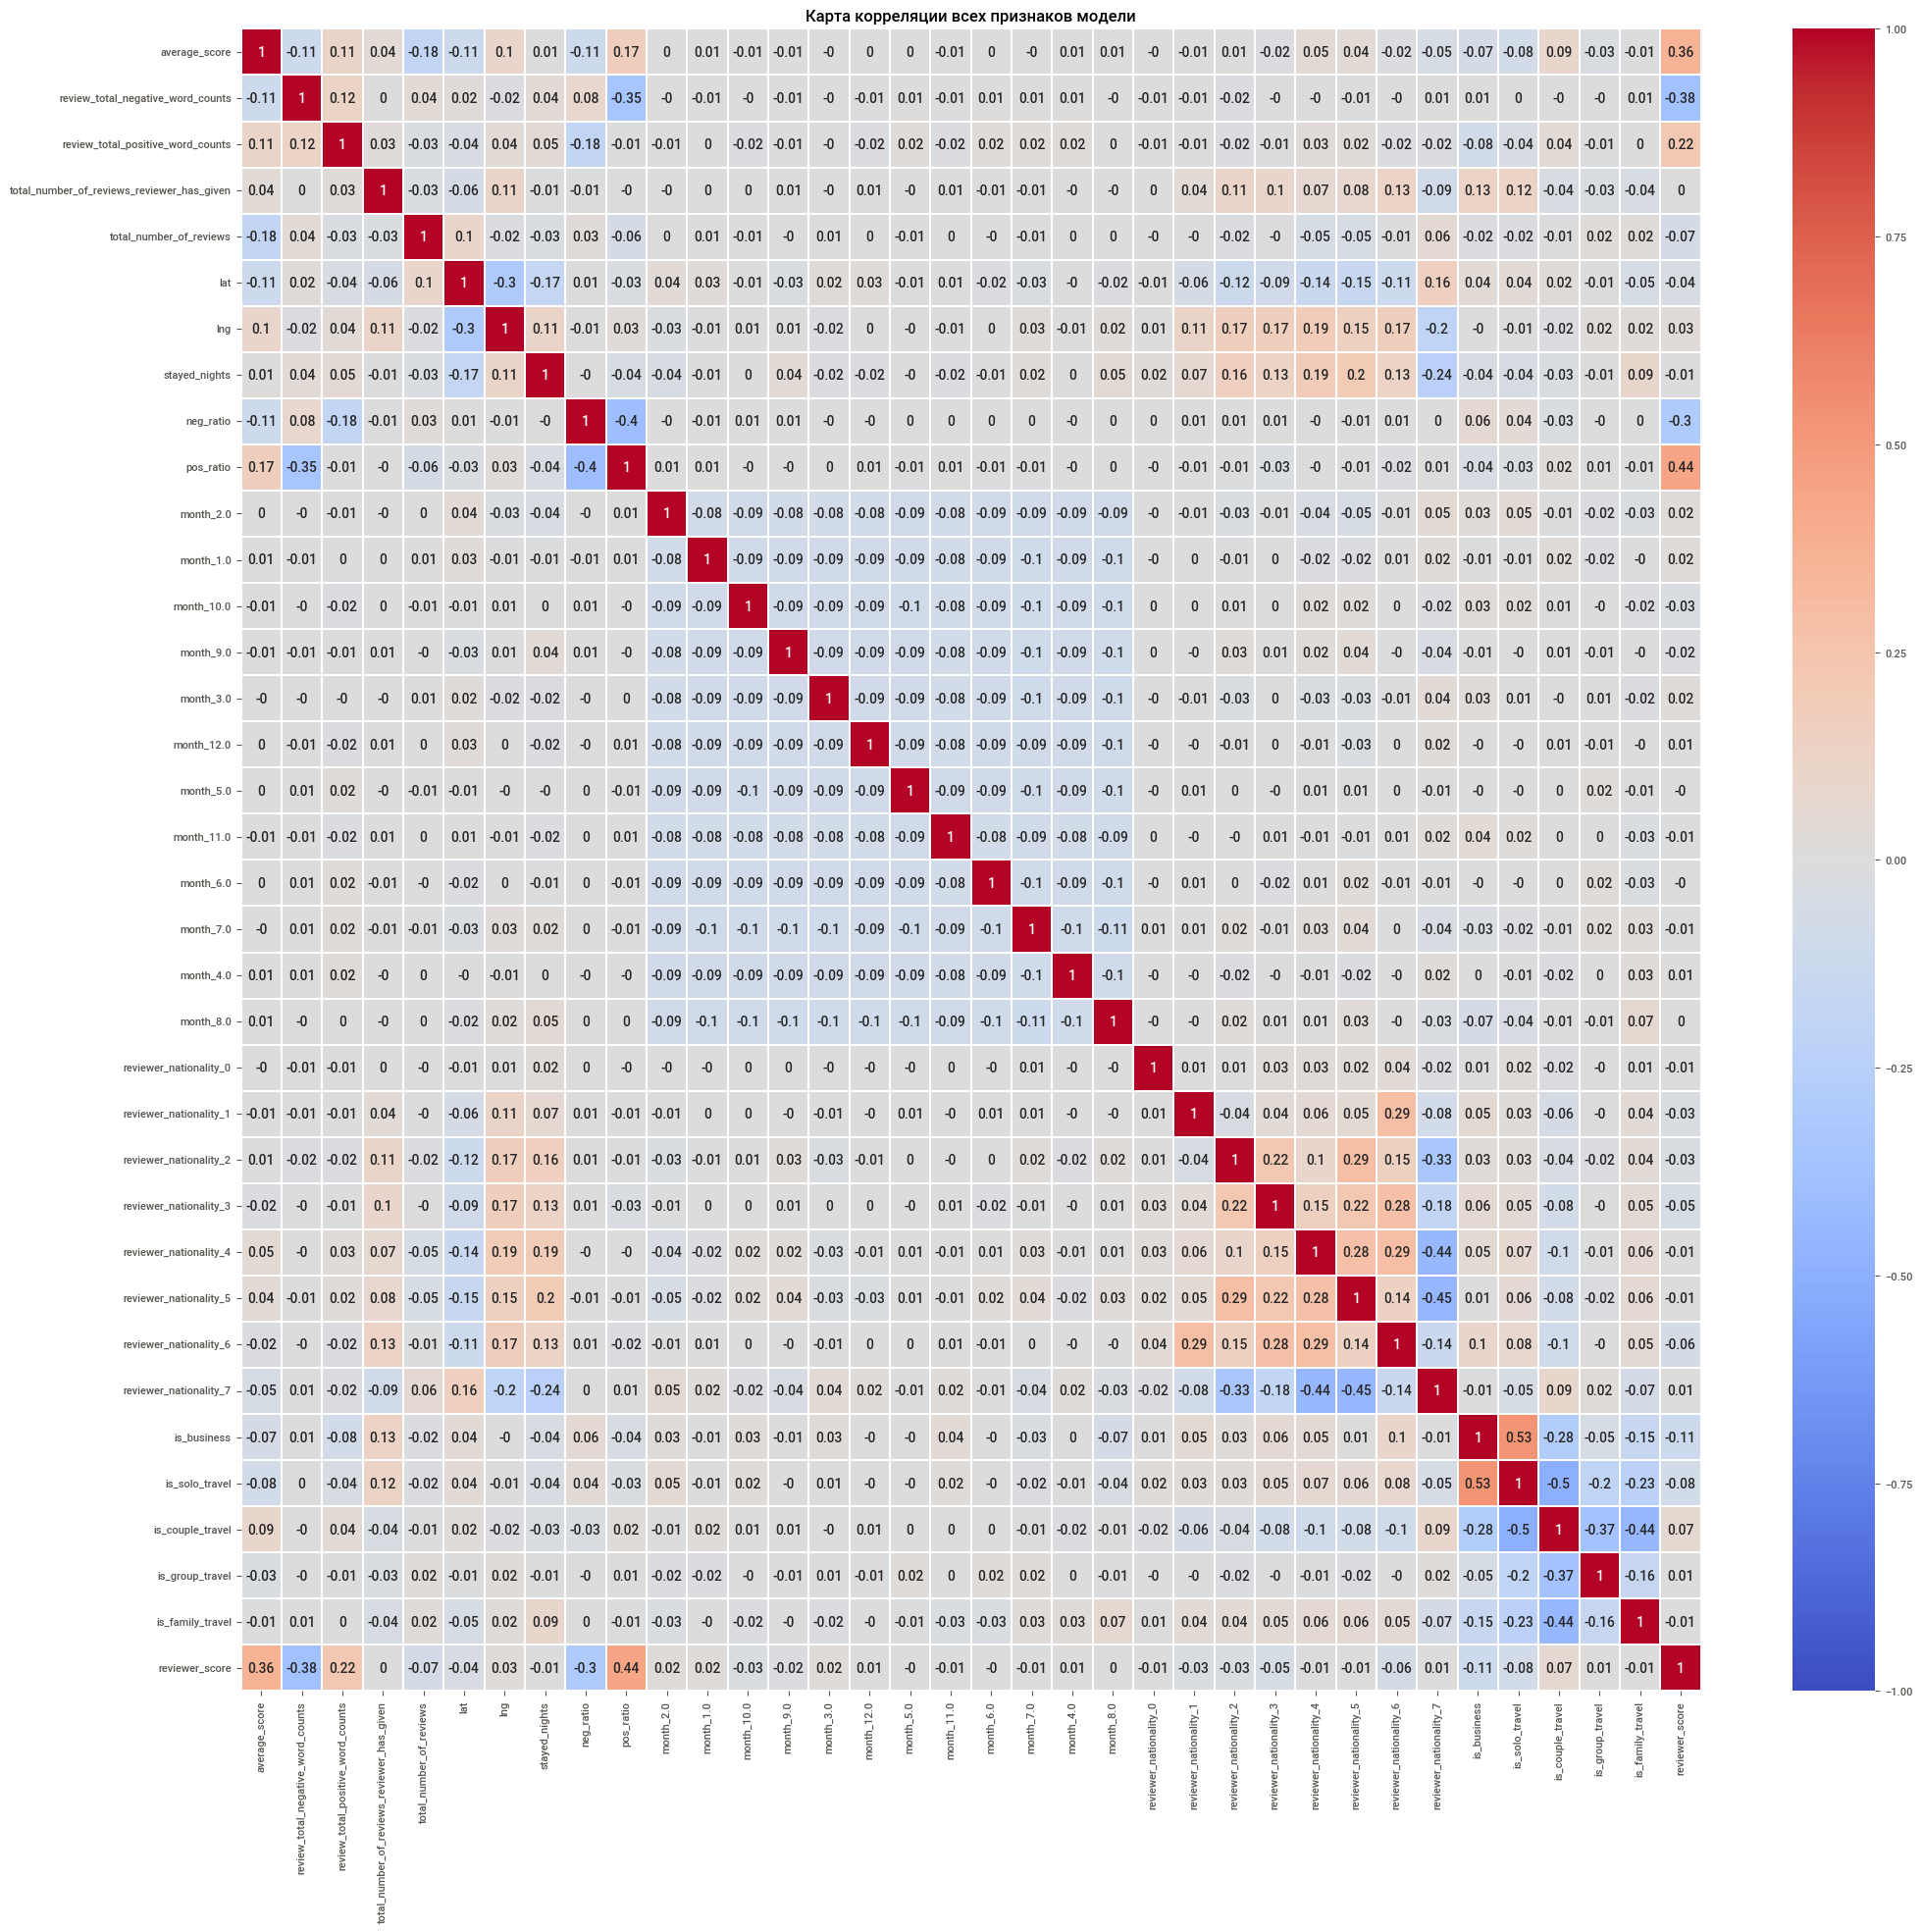

In [132]:
#pearson, spearman, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(24, 22))
ax.set_title('Карта корреляции всех признаков модели')
matrix_corr = train_data.corr(method='pearson').round(2)
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='all_predict_corr', step=exp_version[1]);

### Обучение модели

In [133]:
X = train_data.drop([TARGET], axis=1)
y = train_data[TARGET].values

#### Оценка признаков на значимость (anova, хи-квадрат)

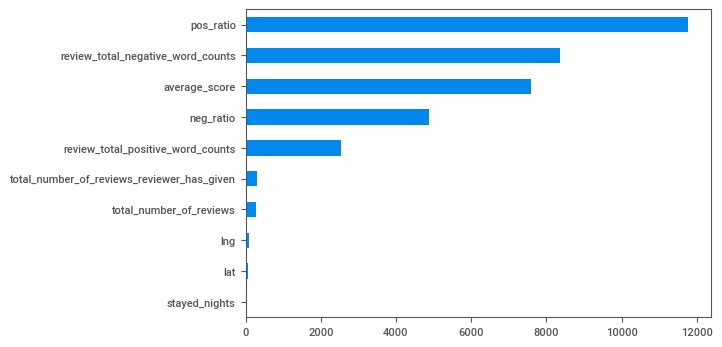

In [134]:
## непрерывные признаки
num_cols = [x for x in X.columns if X[x].nunique()>2]

if num_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import f_classif # anova
    imp_num = pd.Series(f_classif(X[num_cols], y_)[0], index = num_cols)
    imp_num.sort_values(inplace = True)
    imp_num.plot(kind = 'barh');
# О, как. Интерсно, что скажет модель.

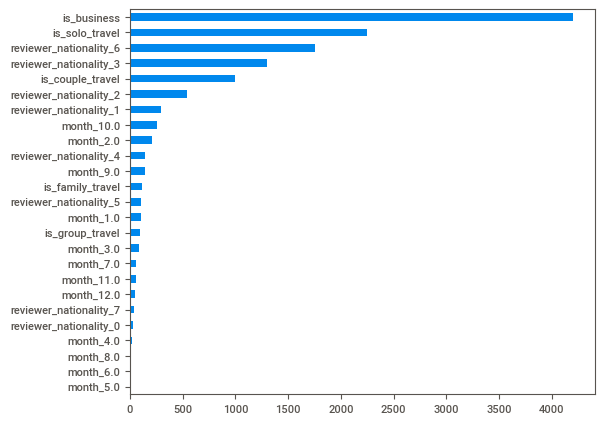

In [135]:
# категориальные признаки
cat_cols = [x for x in X.columns if X[x].nunique()==2]

if cat_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import chi2 # хи-квадрат
    imp_cat = pd.Series(chi2(X[cat_cols], y_)[0], index=cat_cols)
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(kind='barh', figsize=(6,5));
#erunda kokaya to

In [136]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [137]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
params = dict(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1,
    random_state=RANDOM_SEED)

model = RandomForestRegressor(**params)

# логируем гиперпараметры модели
params['model'] ='RandomForestRegressor'
params['target'] = TARGET
params['features_count'] = len(X.columns)
params['features_name']  = X.columns.to_list()

if COMET_LOG_ENABLE:
    experiment.log_parameters(parameters=params, step=exp_version[1]) #, step=1, prefix='comet_'

#display(params)

In [138]:
%%time
start_learn = time.time()

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

learning_time = time.time() - start_learn

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


CPU times: total: 9min 33s
Wall time: 2min 33s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


In [139]:
%%time
start_predict = time.time()
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

predict_time = time.time() - start_predict

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


CPU times: total: 5.99 s
Wall time: 1.68 s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [140]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
model_metrics = {
    'MAPE': metrics.mean_absolute_percentage_error(y_test, y_pred),
    'features_count': len(X.columns),
    'learning_time': learning_time,
    # 'predict_time': predict_time,
}

# Наше Все
print('--------------------------')
print('MAPE:', model_metrics['MAPE'])
print('--------------------------')

# MAPE: 0.12805043431577218

--------------------------
MAPE: 0.12803328434338665
--------------------------


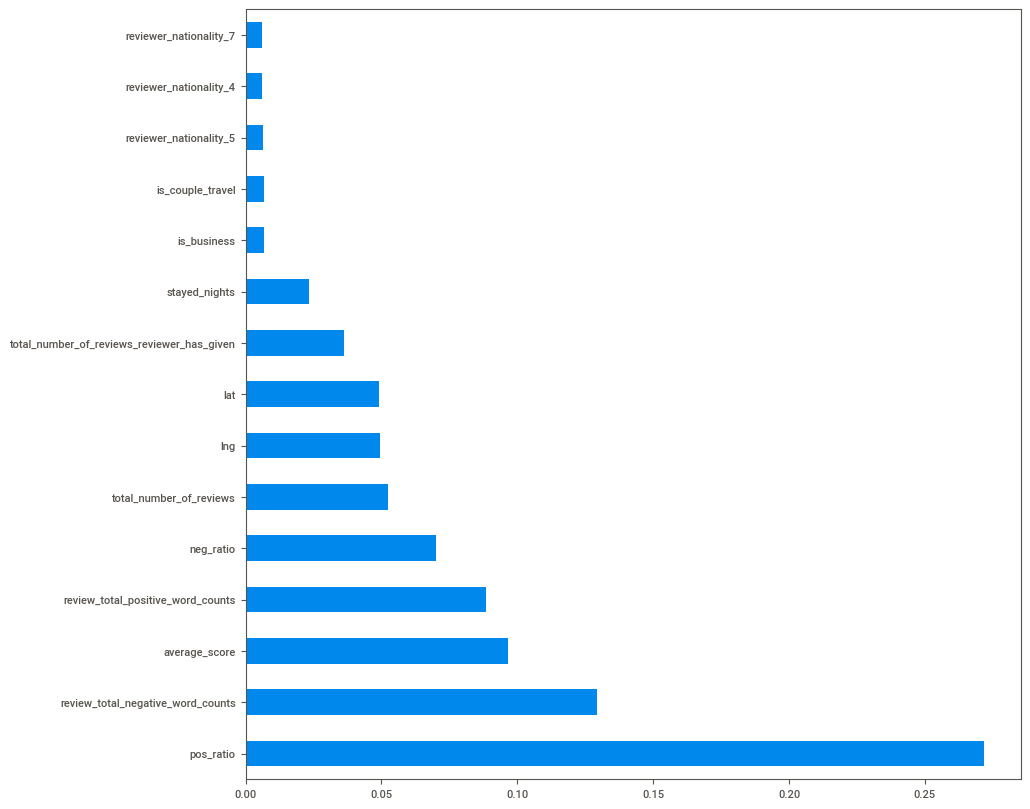

In [141]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
fig, ax = plt.subplots(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',ax=ax);

if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='feature_importances');

In [142]:
# Сохраняем метрики, закрываем логирование эксперимента
if COMET_LOG_ENABLE:
    experiment.log_metrics(model_metrics, step=exp_version[1])
    experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dheglsfds/sfds-project-3/1f1ce83817474707a6cb736c7ceb693c
COMET INFO:   Metrics:
COMET INFO:     MAPE           : 0.12803328434338665
COMET INFO:     features_count : 35
COMET INFO:     learning_time  : 153.14375925064087
COMET INFO:   Others:
COMET INFO:     Name : optimal
COMET INFO:   Parameters:
COMET INFO:     features_count : 35
COMET INFO:     features_name  : ['average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews', 'lat', 'lng', 'stayed_nights', 'neg_ratio', 'pos_ratio', 'month_2.0', 'month_1.0', 'month_10.0', 'mon

### Результаты

In [143]:
exp_log['{}.{}'.format(exp_version[0], exp_version[1])] = {'name':exp_name,'params':params, 'metrics': model_metrics}    
# Накопительный итог
for v, exp in exp_log.items():
    print(exp['name'], v)
    print('  mape:', round(exp['metrics']['MAPE'], 6))
    print('  feature count:', exp['params']['features_count'])
    print('  leaning time:', round(exp['metrics']['learning_time'], 2), 's')

baseline 1.1
  mape: 0.14156
  feature count: 5
  leaning time: 43.04 s
exchenge 1.2
  mape: 0.135271
  feature count: 31
  leaning time: 115.07 s
optimal 1.3
  mape: 0.128033
  feature count: 35
  leaning time: 153.14 s


## Experiment 4. (extrime extend features)

### Подготовка к обучению

In [144]:
exp_version[1] += 1
exp_name = 'extrime'
if COMET_LOG_ENABLE:
    experiment = comet.Experiment(**EXPERIMENT_PARAMS)
    experiment.set_name(exp_name)
    experiment.add_tag('learning {}.{}'.format(exp_version[0], exp_version[1]))

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Python\\learning\\eda.kaggle\\project-3-kaggle\\code' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/dheglsfds/sfds-project-3/5347811e0fa9477f9680a400d64210c0



In [145]:
train_columns = []
train_num_columns = [
    # 'average_score',
    'reviever_mean_score',
    # 'reviever_median_score',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'total_number_of_reviews',
    #'additional_number_of_scoring',
    'lat',
    'lng',
    'stayed_nights',
    'neg_ratio', 
    'pos_ratio',
    #'days_since_review',
]
train_columns.extend(train_num_columns)

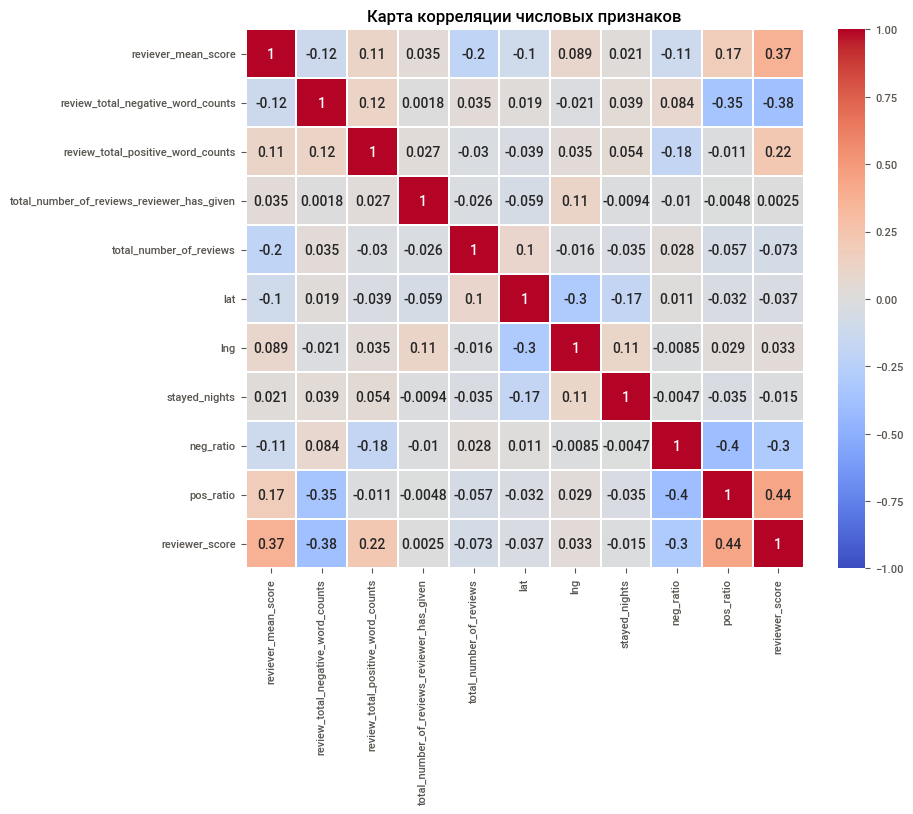

In [146]:
#pearson, pearson, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title('Карта корреляции числовых признаков')
matrix_corr = hotels_df[train_columns+[TARGET]].corr(method='pearson')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='pearson_correlation', step=exp_version[1]);

In [147]:
train_bin_columns = [
    'is_solo_travel',
    'is_couple_travel',
    'is_group_travel',
    'is_family_travel',
    'is_business',
    'low_10_nation',
    'top_10_nation',
    # 'up_score_leader',
    # 'down_score_leader'
]
train_cat_columns = [
    'month',
    'country',
    'reviewer_nationality',
]

train_columns.extend(train_cat_columns+train_bin_columns)
hotels_df[train_columns + [TARGET]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   reviever_mean_score                         386496 non-null  float64 
 1   review_total_negative_word_counts           386496 non-null  int64   
 2   review_total_positive_word_counts           386496 non-null  int64   
 3   total_number_of_reviews_reviewer_has_given  386496 non-null  int64   
 4   total_number_of_reviews                     386496 non-null  int64   
 5   lat                                         386496 non-null  float64 
 6   lng                                         386496 non-null  float64 
 7   stayed_nights                               386496 non-null  int32   
 8   neg_ratio                                   386496 non-null  float64 
 9   pos_ratio                                   386496 non-null

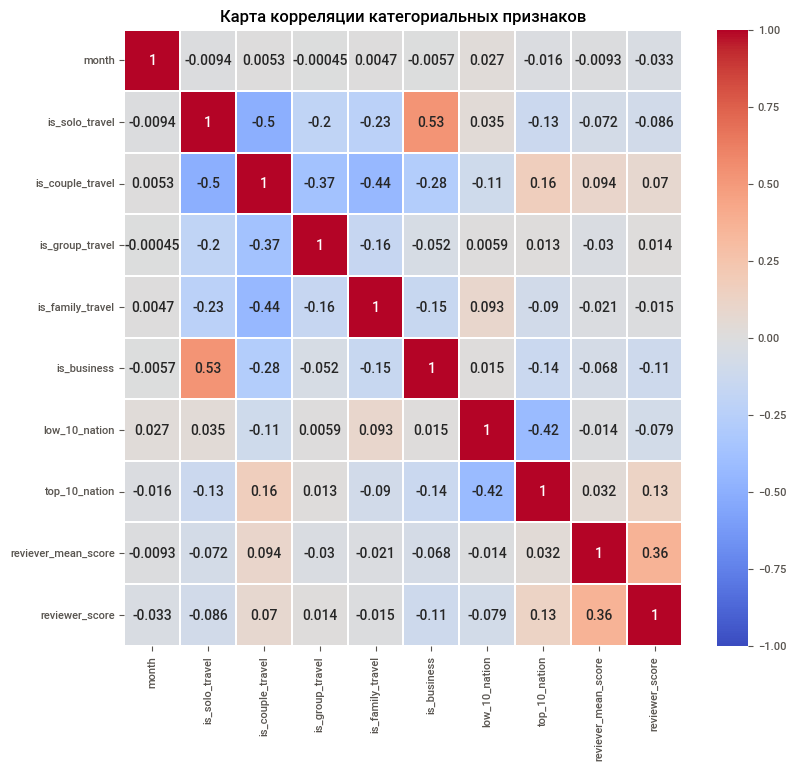

In [148]:
#pearson, spearman, kendall
num_as_cat_cols = [
    # 'average_score',
    'reviever_mean_score',
    # 'reviever_median_score',
]
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(9, 8))
ax.set_title('Карта корреляции категориальных признаков')
matrix_corr = hotels_df[train_cat_columns+train_bin_columns+num_as_cat_cols+[TARGET]].corr(method='spearman')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='spearman_correlation', step=exp_version[1]);

### Формирование тренировочного датасета

In [149]:
# Здесь могут быть ньюансы, выделим отдельным подблоком
train_data = hotels_df[train_columns + [TARGET]].copy()
train_data.head(2)

reviever_mean_score  review_total_negative_word_counts  \
0                  8.3                                  3   
1                  8.4                                  3   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                           7                     1994   
1                                          14                     1361   

         lat       lng  stayed_nights  neg_ratio  pos_ratio  ...  \
0  51.507894 -0.143671              2      0.000      0.559  ...   
1  51.521009 -0.123097              1      0.608      0.000  ...   

          country reviewer_nationality is_solo_travel  is_couple_travel  \
0  United Kingdom      United Kingdom           False              True   
1  United Kingdom      United Kingdom           False              True   

   is_group_travel  is_family_travel  is_business  low_10_nation  \
0            False             False            0              0   
1            False             False            1              0   

   top_10_nation  reviewer_score  
0              1            10.0  
1              1             6.3  

[2 rows x 21 columns]

### Нормализация, стандартизация и кодирование признаков

In [150]:
# Все булевые признаки переводим в числовые [0,1]

# convert bool fields to int
for column in train_data.columns:
    if train_data[column].dtype == 'bool':
        train_data[column] = train_data[column].astype(int)

In [151]:
# Binary Encode
encode_cols=['reviewer_nationality']
ce_binary = ce.BinaryEncoder(cols=encode_cols)
train_data = ce_binary.fit_transform(train_data)

In [152]:
# One Hot Encode
encode_cols=['month', 'country'] 
#encode_cols=['month'] 
ce_onehot = ce.OneHotEncoder(cols=encode_cols, use_cat_names=True)
train_data = ce_onehot.fit_transform(train_data)
train_data.head(5)

reviever_mean_score  review_total_negative_word_counts  \
0                  8.3                                  3   
1                  8.4                                  3   
2                  9.0                                  6   
3                  6.9                                  0   
4                  8.5                                  4   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                           7                     1994   
1                                          14                     1361   
2                                          14                      406   
3                                           8                      607   
4                                          10                     7586   

         lat       lng  stayed_nights  neg_ratio  pos_ratio  ...  \
0  51.507894 -0.143671              2      0.000      0.559  ...   
1  51.521009 -0.123097              1      0.608      0.000  ...   
2  48.845377  2.325643              3      0.663      0.000  ...   
3  48.888697  2.394540              1      0.000      0.767  ...   
4  52.385601  4.847060              6      0.073      0.340  ...   

   reviewer_nationality_6  reviewer_nationality_7  is_solo_travel  \
0                       0                       1               0   
1                       0                       1               0   
2                       1                       0               1   
3                       0                       1               1   
4                       1                       1               0   

   is_couple_travel  is_group_travel  is_family_travel  is_business  \
0                 1                0                 0            0   
1                 1                0                 0            1   
2                 0                0                 0            0   
3                 0                0                 0            0   
4                 1                0                 0            1   

   low_10_nation  top_10_nation  reviewer_score  
0              0              1            10.0  
1              0              1             6.3  
2              0              1             7.5  
3              0              1            10.0  
4              0              0             9.6  

[5 rows x 44 columns]

In [153]:
from sklearn.preprocessing import MinMaxScaler
_scaler = MinMaxScaler()
_scaler.fit(train_data[train_num_columns])
train_data[train_num_columns] = _scaler.fit_transform(train_data[train_num_columns])
train_data.describe().round(2)

reviever_mean_score  review_total_negative_word_counts  \
count            386496.00                          386496.00   
mean                  0.72                               0.05   
std                   0.13                               0.07   
min                   0.00                               0.00   
25%                   0.65                               0.00   
50%                   0.74                               0.02   
75%                   0.80                               0.06   
max                   1.00                               1.00   

       review_total_positive_word_counts  \
count                          386496.00   
mean                                0.05   
std                                 0.05   
min                                 0.00   
25%                                 0.01   
50%                                 0.03   
75%                                 0.06   
max                                 1.00   

       total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
count                                   386496.00                386496.00   
mean                                         0.02                     0.16   
std                                          0.03                     0.14   
min                                          0.00                     0.00   
25%                                          0.00                     0.07   
50%                                          0.01                     0.13   
75%                                          0.02                     0.22   
max                                          1.00                     1.00   

             lat        lng  stayed_nights  neg_ratio  pos_ratio  ...  \
count  386496.00  386496.00      386496.00  386496.00  386496.00  ...   
mean        0.73       0.19           0.08       0.06       0.29  ...   
std         0.31       0.28           0.05       0.10       0.22  ...   
min         0.00       0.00           0.00       0.00       0.00  ...   
25%         0.62       0.01           0.03       0.00       0.12  ...   
50%         0.92       0.02           0.07       0.00       0.26  ...   
75%         0.92       0.31           0.10       0.09       0.42  ...   
max         1.00       1.00           1.00       1.00       1.00  ...   

       reviewer_nationality_6  reviewer_nationality_7  is_solo_travel  \
count               386496.00               386496.00       386496.00   
mean                     0.18                    0.71            0.21   
std                      0.39                    0.46            0.41   
min                      0.00                    0.00            0.00   
25%                      0.00                    0.00            0.00   
50%                      0.00                    1.00            0.00   
75%                      0.00                    1.00            0.00   
max                      1.00                    1.00            1.00   

       is_couple_travel  is_group_travel  is_family_travel  is_business  \
count         386496.00        386496.00         386496.00    386496.00   
mean               0.49             0.13              0.17         0.16   
std                0.50             0.33              0.38         0.37   
min                0.00             0.00              0.00         0.00   
25%                0.00             0.00              0.00         0.00   
50%                0.00             0.00              0.00         0.00   
75%                1.00             0.00              0.00         0.00   
max                1.00             1.00              1.00         1.00   

       low_10_nation  top_10_nation  reviewer_score  
count      386496.00      386496.00       386496.00  
mean            0.08           0.66            8.40  
std             0.28           0.47            1.64  
min             0.00           0.00            2.50  
25%             0.00           0.00            7.50  
50%  

In [154]:
# from sklearn.preprocessing import StandardScaler
# _scaler = StandardScaler()
# _scaler.fit(train_data)
# train_data[train_columns] = _scaler.fit_transform(train_data)

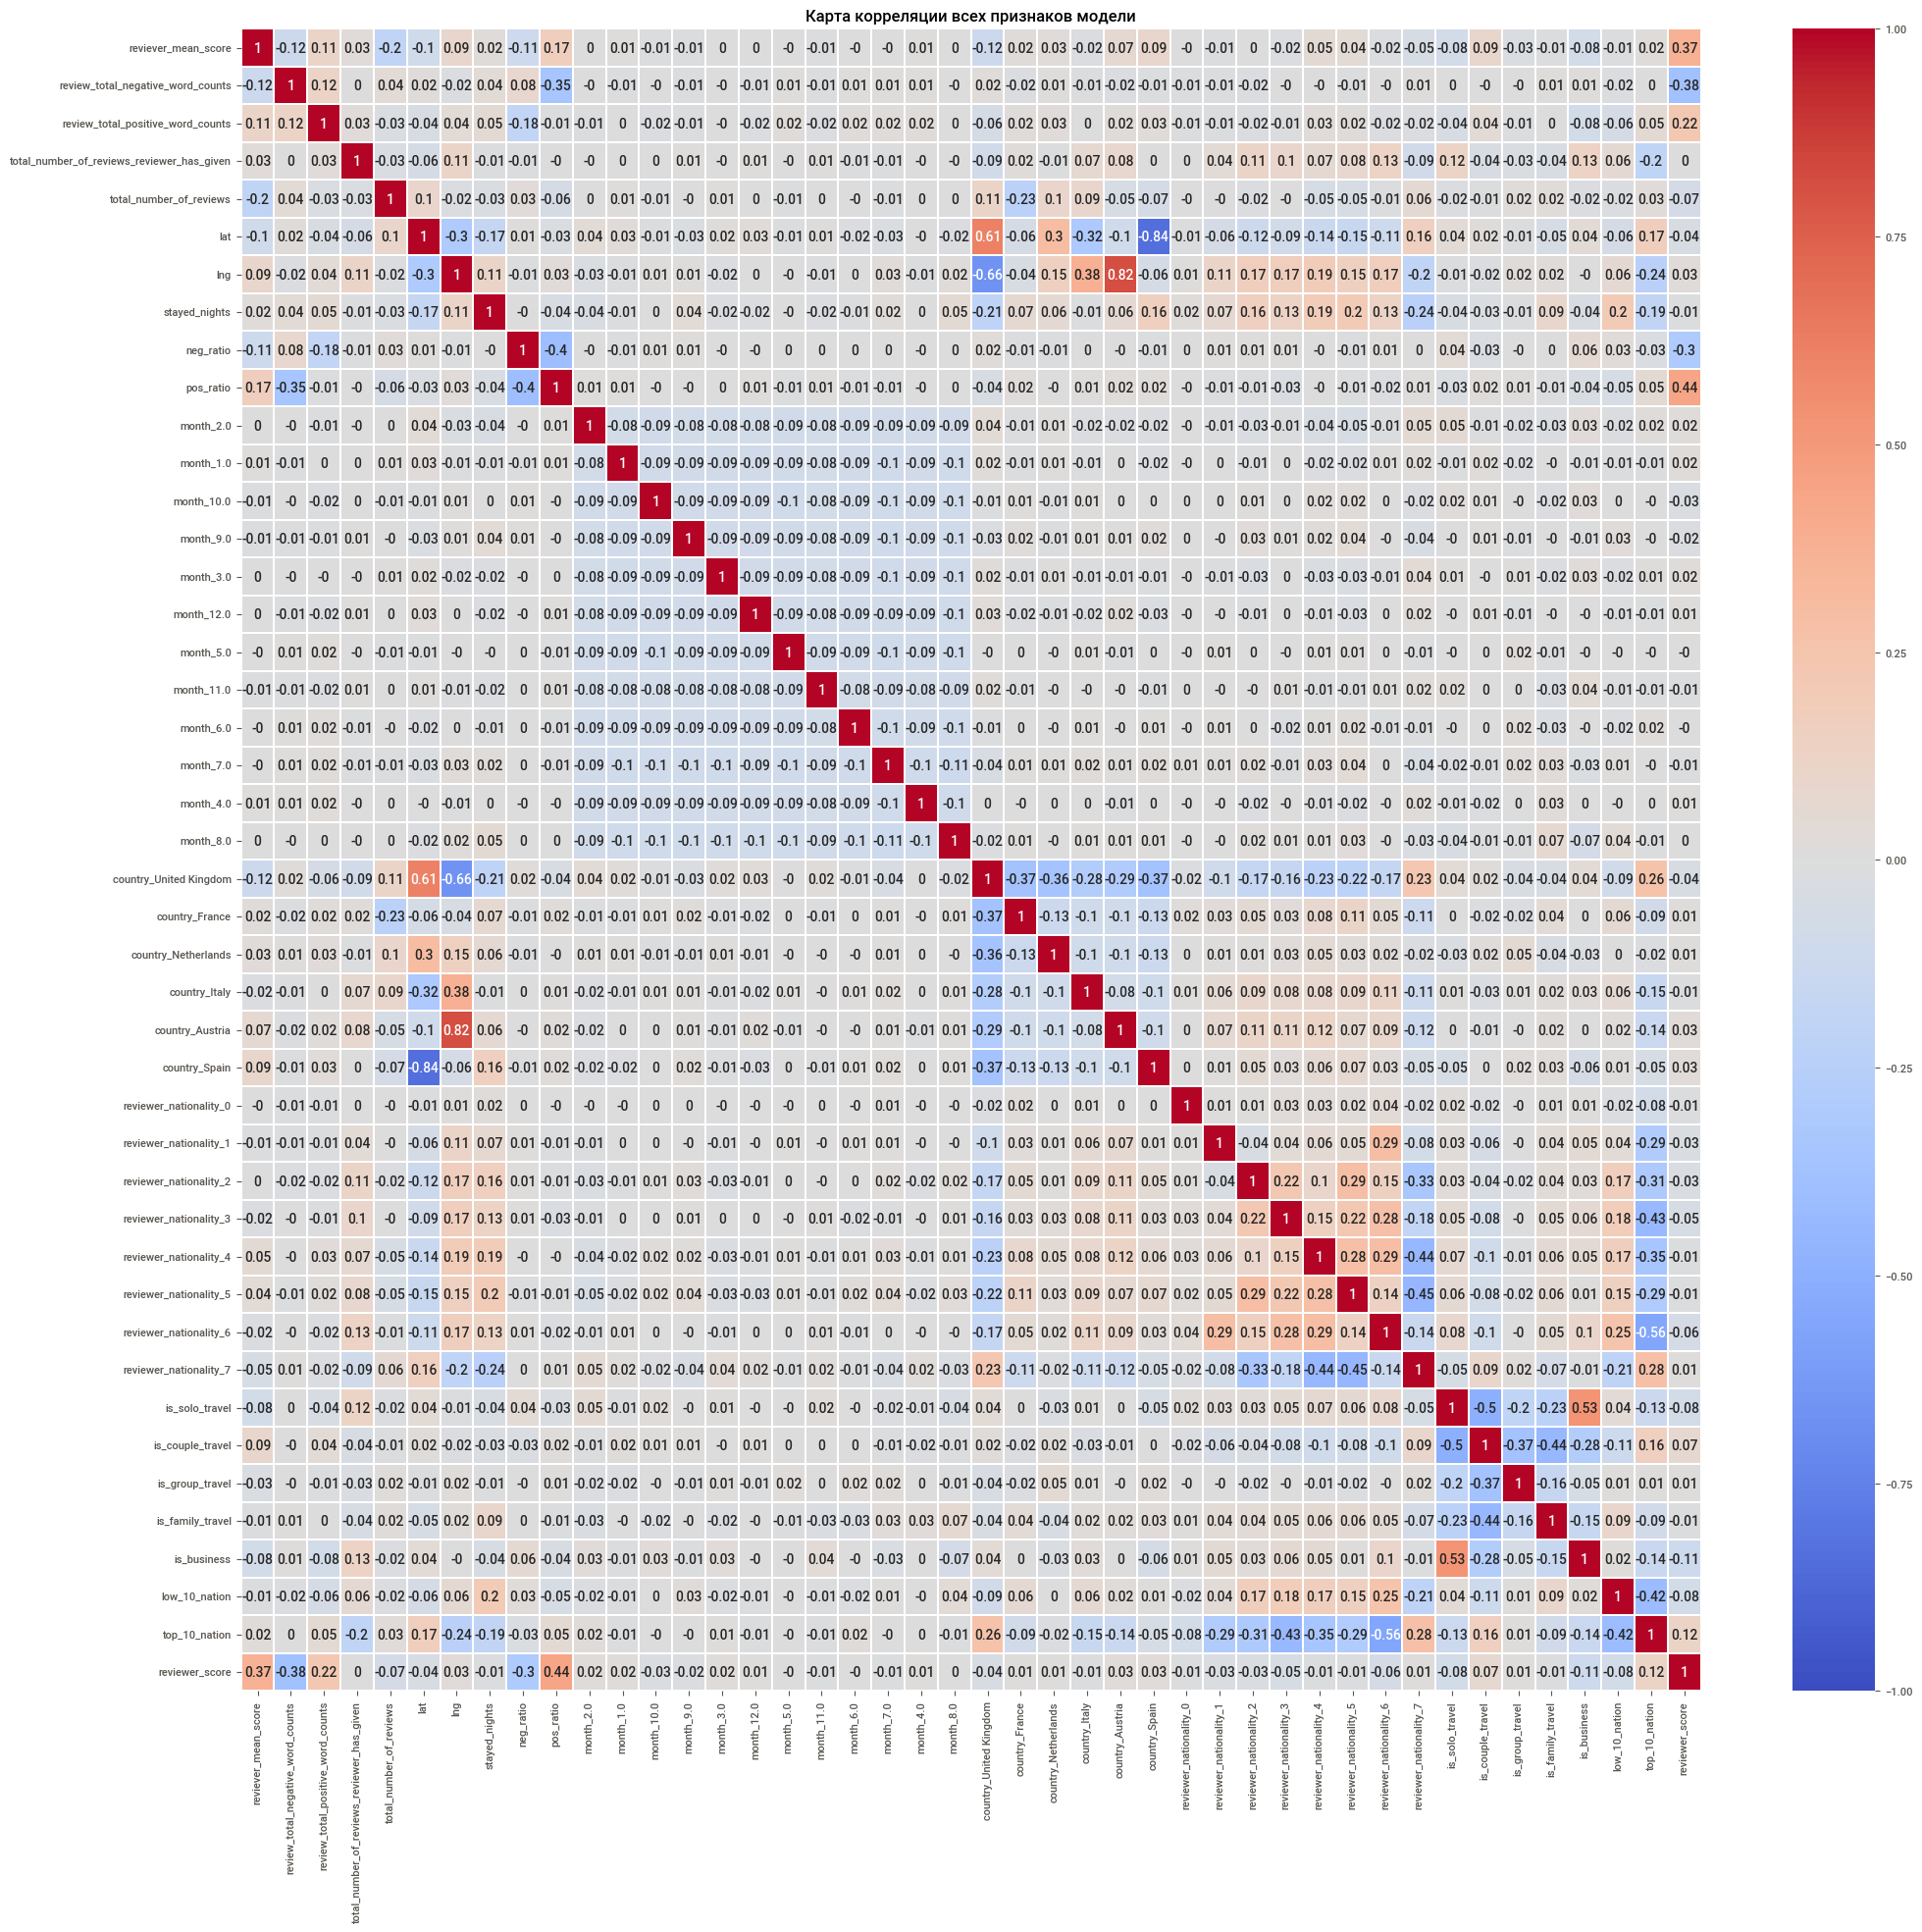

In [155]:
#pearson, spearman, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(24, 22))
ax.set_title('Карта корреляции всех признаков модели')
matrix_corr = train_data.corr(method='pearson').round(2)
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='all_predict_corr', step=exp_version[1]);

### Обучение модели

In [156]:
X = train_data.drop([TARGET], axis=1)
y = train_data[TARGET].values

#### Оценка признаков на значимость (anova, хи-квадрат)

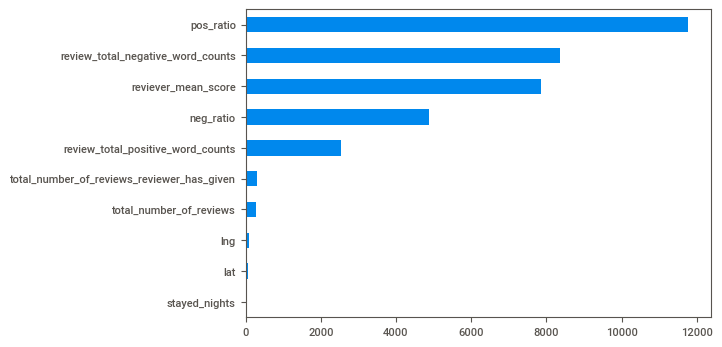

In [157]:
## непрерывные признаки
num_cols = [x for x in X.columns if X[x].nunique()>2]

if num_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import f_classif # anova
    imp_num = pd.Series(f_classif(X[num_cols], y_)[0], index = num_cols)
    imp_num.sort_values(inplace = True)
    imp_num.plot(kind = 'barh');
# О, как. Интерсно, что скажет модель.

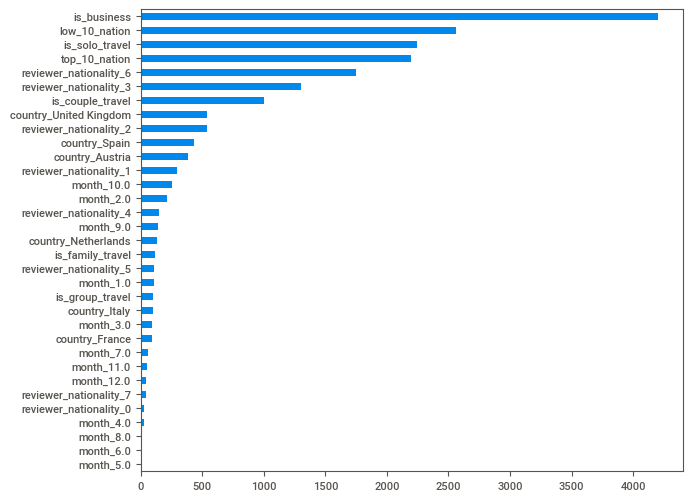

In [158]:
# категориальные признаки
cat_cols = [x for x in X.columns if X[x].nunique()==2]

if cat_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import chi2 # хи-квадрат
    imp_cat = pd.Series(chi2(X[cat_cols], y_)[0], index=cat_cols)
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(kind='barh', figsize=(7,6));
#erunda kakaya to

In [159]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [160]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
params = dict(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1,
    random_state=RANDOM_SEED)

model = RandomForestRegressor(**params)

# логируем гиперпараметры модели
params['model'] ='RandomForestRegressor'
params['target'] = TARGET
params['features_count'] = len(X.columns)
params['features_name']  = X.columns.to_list()

if COMET_LOG_ENABLE:
    experiment.log_parameters(parameters=params, step=exp_version[1]) #, step=1, prefix='comet_'
#display(params)

In [161]:
%%time
start_learn = time.time()

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

learning_time = time.time() - start_learn

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


CPU times: total: 10min 57s
Wall time: 2min 56s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


In [162]:
%%time
start_predict = time.time()
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

predict_time = time.time() - start_predict

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


CPU times: total: 6.27 s
Wall time: 1.94 s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [163]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
model_metrics = {
    'MAPE': metrics.mean_absolute_percentage_error(y_test, y_pred),
    'features_count': len(X.columns),
    'learning_time': learning_time,
    # 'predict_time': predict_time,
}

# Наше Все
print('--------------------------')
print('MAPE:', model_metrics['MAPE'])
print('--------------------------')

# MAPE: 0.12805043431577218
# MAPE: 0.12801268826507775
# MAPE: 0.12760662118105054

--------------------------
MAPE: 0.1276965122287925
--------------------------


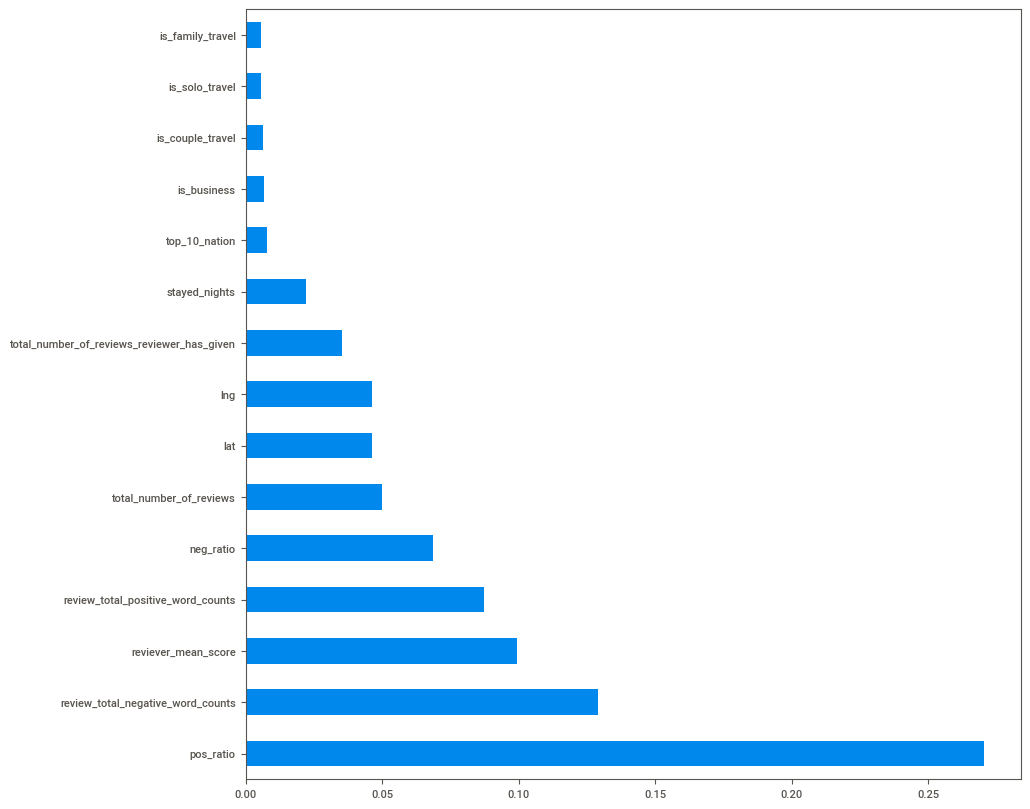

In [164]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
# И мы их выведем!
fig, ax = plt.subplots(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',ax=ax);
if COMET_LOG_ENABLE:
    experiment.log_figure(figure_name='feature_importances');

In [165]:
# Сохраняем метрики, закрываем логирование эксперимента
if COMET_LOG_ENABLE:
    experiment.log_metrics(model_metrics, step=exp_version[1])
    experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dheglsfds/sfds-project-3/5347811e0fa9477f9680a400d64210c0
COMET INFO:   Metrics:
COMET INFO:     MAPE           : 0.1276965122287925
COMET INFO:     features_count : 43
COMET INFO:     learning_time  : 176.54359412193298
COMET INFO:   Others:
COMET INFO:     Name : extrime
COMET INFO:   Parameters:
COMET INFO:     features_count : 43
COMET INFO:     features_name  : ['reviever_mean_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews', 'lat', 'lng', 'stayed_nights', 'neg_ratio', 'pos_ratio', 'month_2.0', 'month_1.0', 'month_10.0',

### Результаты

In [166]:
exp_log['{}.{}'.format(exp_version[0], exp_version[1])] = {'name':exp_name,'params':params, 'metrics': model_metrics}    
# Накопительный итог
for v, exp in exp_log.items():
    print(exp['name'], v)
    print('  mape:', round(exp['metrics']['MAPE'], 6))
    print('  feature count:', exp['params']['features_count'])
    print('  leaning time:', round(exp['metrics']['learning_time'], 2), 's')

baseline 1.1
  mape: 0.14156
  feature count: 5
  leaning time: 43.04 s
exchenge 1.2
  mape: 0.135271
  feature count: 31
  leaning time: 115.07 s
optimal 1.3
  mape: 0.128033
  feature count: 35
  leaning time: 153.14 s
extrime 1.4
  mape: 0.127697
  feature count: 43
  leaning time: 176.54 s


In [167]:
# Выбрать эксперименты, начиная с нижнего и нажать кнопачку Diff в нижней области фрэйма
if COMET_LOG_ENABLE:
    experiment.display_project()

In [168]:
print('END')

END


## Вывод

*  Только (и только) кропотливая работа с данными на этапе подготовки, анализа и конструирования дает не только понимание с чем приходится иметь дело, но улучшение результата на этапе машинного обучения.

>Насмотря на то что датасет далек от промышленого, это было занимательное приключение. Надеюсь в блоке ML мне раскажут чем это я тут таким занимался.

*SF DST-148 Дмитрий Орлов Март-Апрель 2023*

<a href="https://skillfactory.ru/courses/data-science">
    <img src="https://raw.githubusercontent.com/dhegl/sf_ds/64c052f95af5d042844ed56f765c2cbb566d1680/main/static/small.svg" alt="Онлайн-школа SkillFactory Курсы по Data Science" width="120px" align="left" >
</a>